In [1]:
!pwd
import os
os.chdir('/Users/miguelmartins/Projects/hybrid-hmm')
!pwd
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

/Users/miguelmartins/Projects/hybrid-hmm/notebooks
/Users/miguelmartins/Projects/hybrid-hmm


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from utility_functions.metrics import schmidt_metrics

In [576]:
import scipy.stats as stats
import itertools
from typing import Dict, List



def paired_t_test_statistics(samples, alpha=0.05):
    n = len(samples)
    pairings = tuple(prod for prod in itertools.product(samples, samples))
    name_pairs = [(pair[0][0], pair[1][0]) for pair in pairings]
    paired_t_test = [stats.ttest_rel(pair[0][1], pair[1][1]) for pair in pairings]
    matrix = [1 if (p_v:= pair.pvalue) <= alpha else 0 for pair in paired_t_test]
    return name_pairs, paired_t_test, np.array(matrix).reshape((n,n))


def plot_t_test_matrix(mat, ticks, metric_name=''):
    mat_ = mat.copy().astype(np.float32)
    for i in range(mat.shape[0]):
        mat_[i, i] = 0.5
    fig, ax = plt.subplots()
    ax.matshow(mat_, cmap='gray', vmin=0, vmax=1, )
    
    ax.set_xticks(range(len(ticks)))
    ax.set_xticklabels(ticks, rotation='vertical')
    ax.set_yticks(range(len(ticks)))
    ax.set_yticklabels(ticks, rotation='horizontal')
    ax.set_title(r'Paired $t$-Test $n=10$')
    plt.savefig('filename.png', dpi=1200)
    
def get_boxplot_stats(datum):
    if type(datum) is not np.ndarray:
        raise TypeError('Input must be a numpy array.')
    box_stats = {}
    pd_stats = pd.DataFrame(datum).describe()
    box_stats['Q1'] = pd_stats.loc['25%'].values[0]
    box_stats['median'] = np.median(datum)
    box_stats['Q3'] = pd_stats.loc['75%'].values[0]
    box_stats['IQR'] = box_stats['Q3'] - box_stats['Q1']
    box_stats['lower_bound'] = box_stats['Q1'] - 1.5 * box_stats['IQR']
    box_stats['upper_bound'] = box_stats['Q3'] + 1.5 * box_stats['IQR']
    box_stats['lower_whisker'] = np.min(datum[datum >= box_stats['lower_bound']])
    box_stats['upper_whisker'] = np.max(datum[datum <= box_stats['upper_bound']])
    return box_stats



In [4]:
!pwd

/Users/miguelmartins/Projects/hybrid-hmm


In [6]:
!ls results/hybrid/circor/hmm_mmi_circor_envelops_nnonly_adam1e3/2022-09-07_15:29:09


ground_truth.mat out_seq.mat      p_states.mat     viterbi.mat


In [4]:
def schmidt_fold(gt, _h_vit):
    n_folds = gt.shape[0]
    mean_fold_ppv = []
    mean_fold_sensitivity = []
    for fold in range(n_folds):
        n_sounds = gt[fold].shape[0]
        ppv, sensitivity = [], []
        for sound in range(n_sounds):
            ppv_, sensitivity_ = schmidt_metrics(gt[fold][sound], _h_vit[fold][sound])
            ppv.append(ppv_)
            sensitivity.append(sensitivity_)
        mean_fold_ppv.append(np.mean(ppv))
        mean_fold_sensitivity.append(np.mean(sensitivity))

    return mean_fold_ppv, mean_fold_sensitivity

In [5]:
def read_results(path: str):
    gt = sio.loadmat(path + '/ground_truth.mat', squeeze_me=True)['ground_truth']
    cnn = sio.loadmat(path + '/out_seq.mat', squeeze_me=True)['out_seq']
    vit = sio.loadmat(path + '/viterbi.mat', squeeze_me=True)['viterbi']
    return gt, cnn, vit

In [6]:
def get_accuracy(gt, cnn, n_folds=10):
    acc_folds = []
    for fold in range(n_folds):
        accuracy = []
        for sound in range(len(gt[fold])):
            try:
                accuracy.append(accuracy_score(gt[fold][sound], cnn[fold][sound]))
            except:
                print("fold", fold, "sound", sound, " ", gt[fold][sound].shape, cnn[fold][sound].shape)
                pass
        acc_folds.append(np.mean(accuracy))
    return acc_folds

In [7]:

def metrics_model(path: str):
    gt, cnn, vit = read_results(path)
    accuracy = get_accuracy(gt, vit)
    ppv, sensitivity = schmidt_fold(gt, vit)
    return accuracy, ppv, sensitivity

In [466]:
!ls 


circor_hybrid_cle_env = metrics_model('results/hybrid/circor/hmm_completelikelihood_circor_envelops_joint/2022-07-14_21:38:18')
circor_unet_cre_env = metrics_model('results/unet/circor/unet/2022-06-20_10_40_26')
circor_hybrid_1epoch = metrics_model('results/hybrid/circor/hmm_completelikelihood_circor_envelops_joint/2022-07-19_17:09:36')
# v não é nn only. é nn + HMM com SGD com learning rate 1e-4
circor_hybrid_env_cl_nn_only = metrics_model('results/hybrid/circor/hmm_completelikelihood_circor_envelops_joint/2022-07-22_18:36:22')
circor_nn_only_env_cl = metrics_model('results/hybrid/circor/hmm_completelikelihood_circor_envelops_nnonly/2022-07-31_16:50:27')

circor_nn_only_env_mmi_1e4 = metrics_model('results/hybrid/circor/hmm_mmi_circor_envelops_nnonly_adam1e4/2022-08-22_13:56:23')
circor_nn_only_env_mmi_1e3 = metrics_model('results/hybrid/circor/hmm_mmi_circor_envelops_nnonly_adam1e3/2022-09-07_15:29:09')

circor_fernando = metrics_model('results/fernando/circor/fernando_CE_physio16_mfcc_joint/2022-09-16_15_46_30')

PCG_example.png                   models
README.md                         notebook
checkpoint                        notebooks
circor_100_nogaps_50hz.npy        ph16_ppv.png
circor_100_raw_50hz.npy           ph16_sens.png
circor_ppv.png                    random_init.data-00000-of-00001
circor_sens.png                   random_init.index
circor_springer_np.npy            requirements.txt.py
custom_train_functions            results
data_processing                   test.txt
datasets                          test1.png
filename.png                      test2.png
fine_tune_comparison.png          test3.png
fine_tune_comparison_less_dpi.png test4.png
fine_tune_final.png               tests
fine_tune_final2.png              train_scripts
loss_functions                    utility_functions


In [12]:
!ls results/fernando/circor/fernando_CE_physio16_mfcc_joint/2022-09-16_15_46_30

ground_truth.mat     test_indexes.mat     viterbi.mat
out_seq.mat          train_indexes.mat    weights_fold0.hdf5
p_states.mat         trans_mat.mat        weights_fold1.hdf5
p_states_fold_0.npy  trans_mat_fold_0.npy weights_fold2.hdf5
p_states_fold_1.npy  trans_mat_fold_1.npy weights_fold3.hdf5
p_states_fold_2.npy  trans_mat_fold_2.npy weights_fold4.hdf5
p_states_fold_3.npy  trans_mat_fold_3.npy weights_fold5.hdf5
p_states_fold_4.npy  trans_mat_fold_4.npy weights_fold6.hdf5
p_states_fold_5.npy  trans_mat_fold_5.npy weights_fold7.hdf5
p_states_fold_6.npy  trans_mat_fold_6.npy weights_fold8.hdf5
p_states_fold_7.npy  trans_mat_fold_7.npy weights_fold9.hdf5
p_states_fold_8.npy  trans_mat_fold_8.npy
p_states_fold_9.npy  trans_mat_fold_9.npy


In [12]:
gt, cnn, vit = read_results('results/hybrid/circor/hmm_completelikelihood_circor_envelops_joint/2022-07-14_21:38:18')

In [501]:
def print_metric(vec, name):
    print(f"{name}")
    for v in vec:
        print(f'{v} \\\\')
        
mnn = {'CL-NNOnly': ph16_hmm_nnonly_cl_env,
                   'CL-NNonly-PSD': ph_16_hmm_nnonly_cl_psd,
      'CL-NNonly-MFCC': ph_16_hmm_nnonly_cl_mfcc,}
    
print_metric(ph_16_hmm_nnonly_cl_mfcc[1], "env sens")

env sens
0.9534396078389973 \\
0.9373899365268299 \\
0.9029271799984594 \\
0.894256600070597 \\
0.9607455974901763 \\
0.9775674589397285 \\
0.9338325245266977 \\
0.9314268553845232 \\
0.9680094861400722 \\
0.9478536555791721 \\


## Circor: MNNs vs U-Net and Fernando

CL-NN only seems to be the most resiliant MNN model (uncoment plots to check differences).


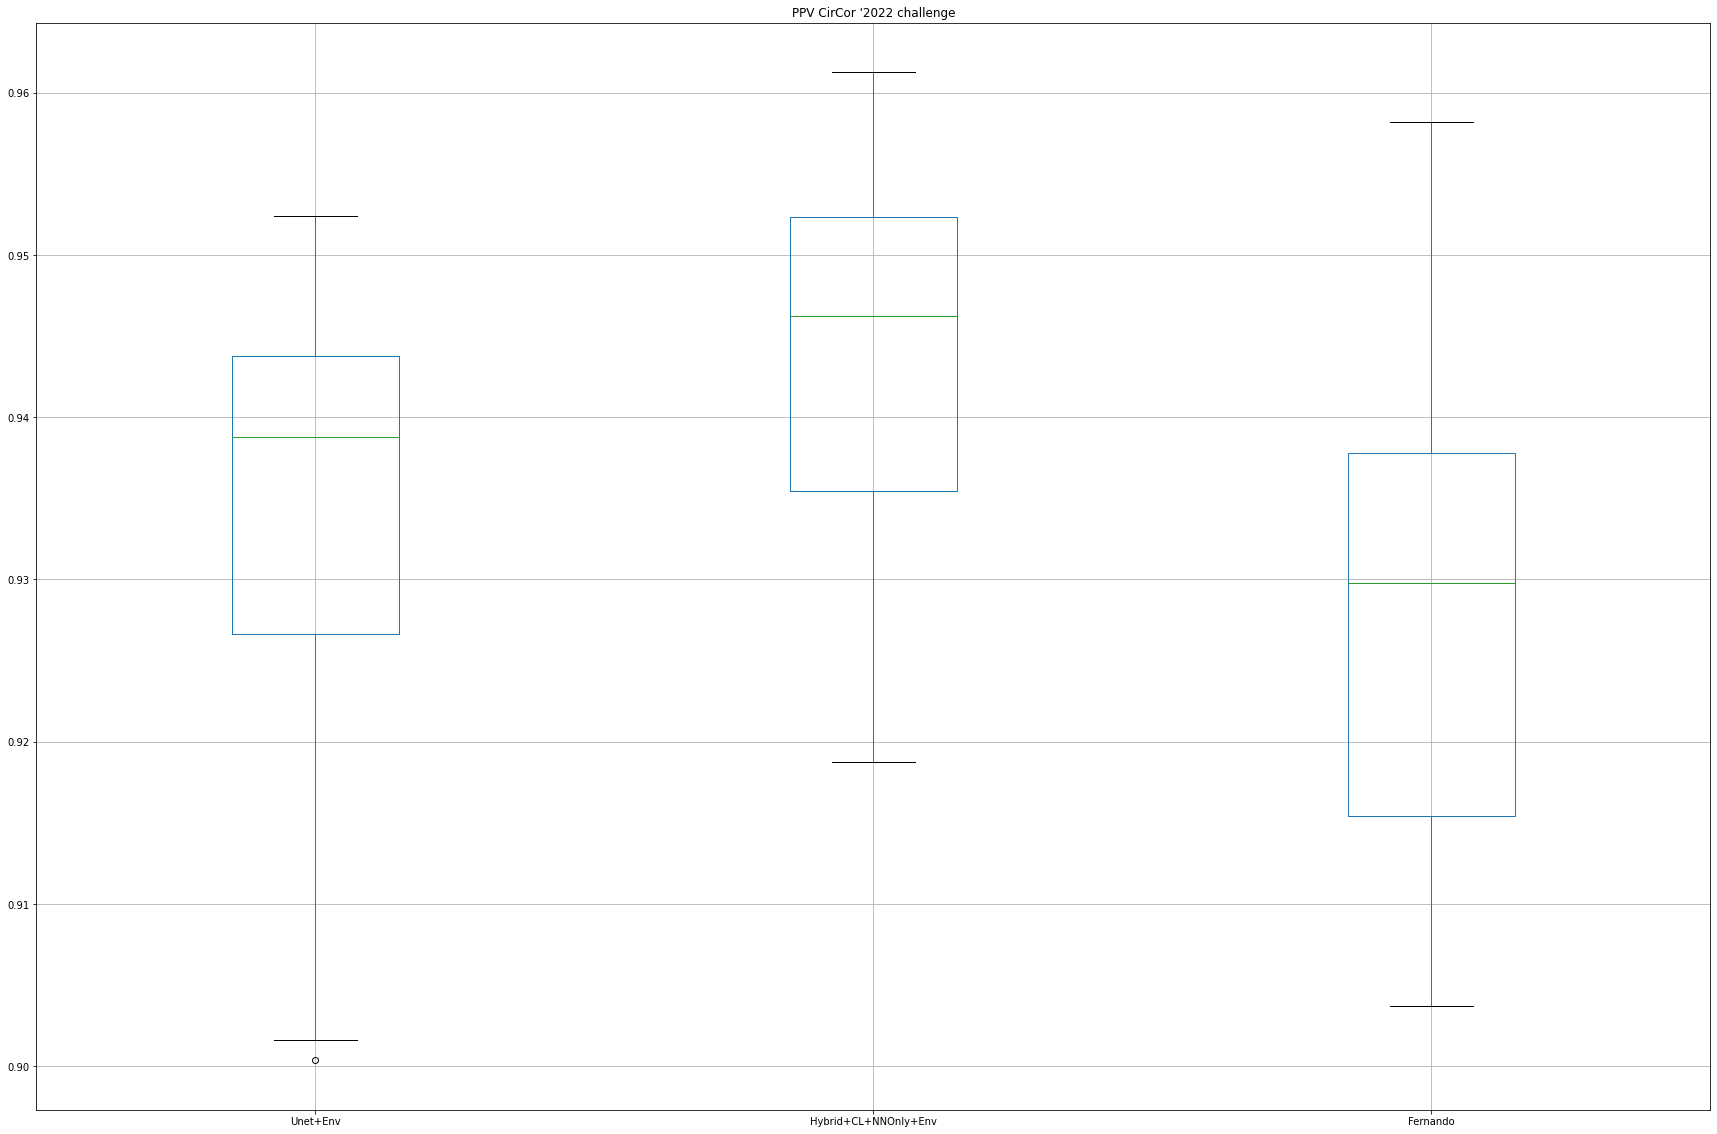

In [469]:
df = pd.DataFrame({
    'Unet+Env': circor_unet_cre_env[1],
    # 'Hybrid+CL+SGDHMM1e4+Env': circor_hybrid_env_cl_nn_only[1],
    'Hybrid+CL+NNOnly+Env': circor_nn_only_env_cl[1],
    # 'Hybrid+MMI+NNOnly+Env': circor_nn_only_env_mmi_1e4[1],
    'Fernando': circor_fernando[1]
                   })

boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('PPV CirCor \'2022 challenge')
plt.show()

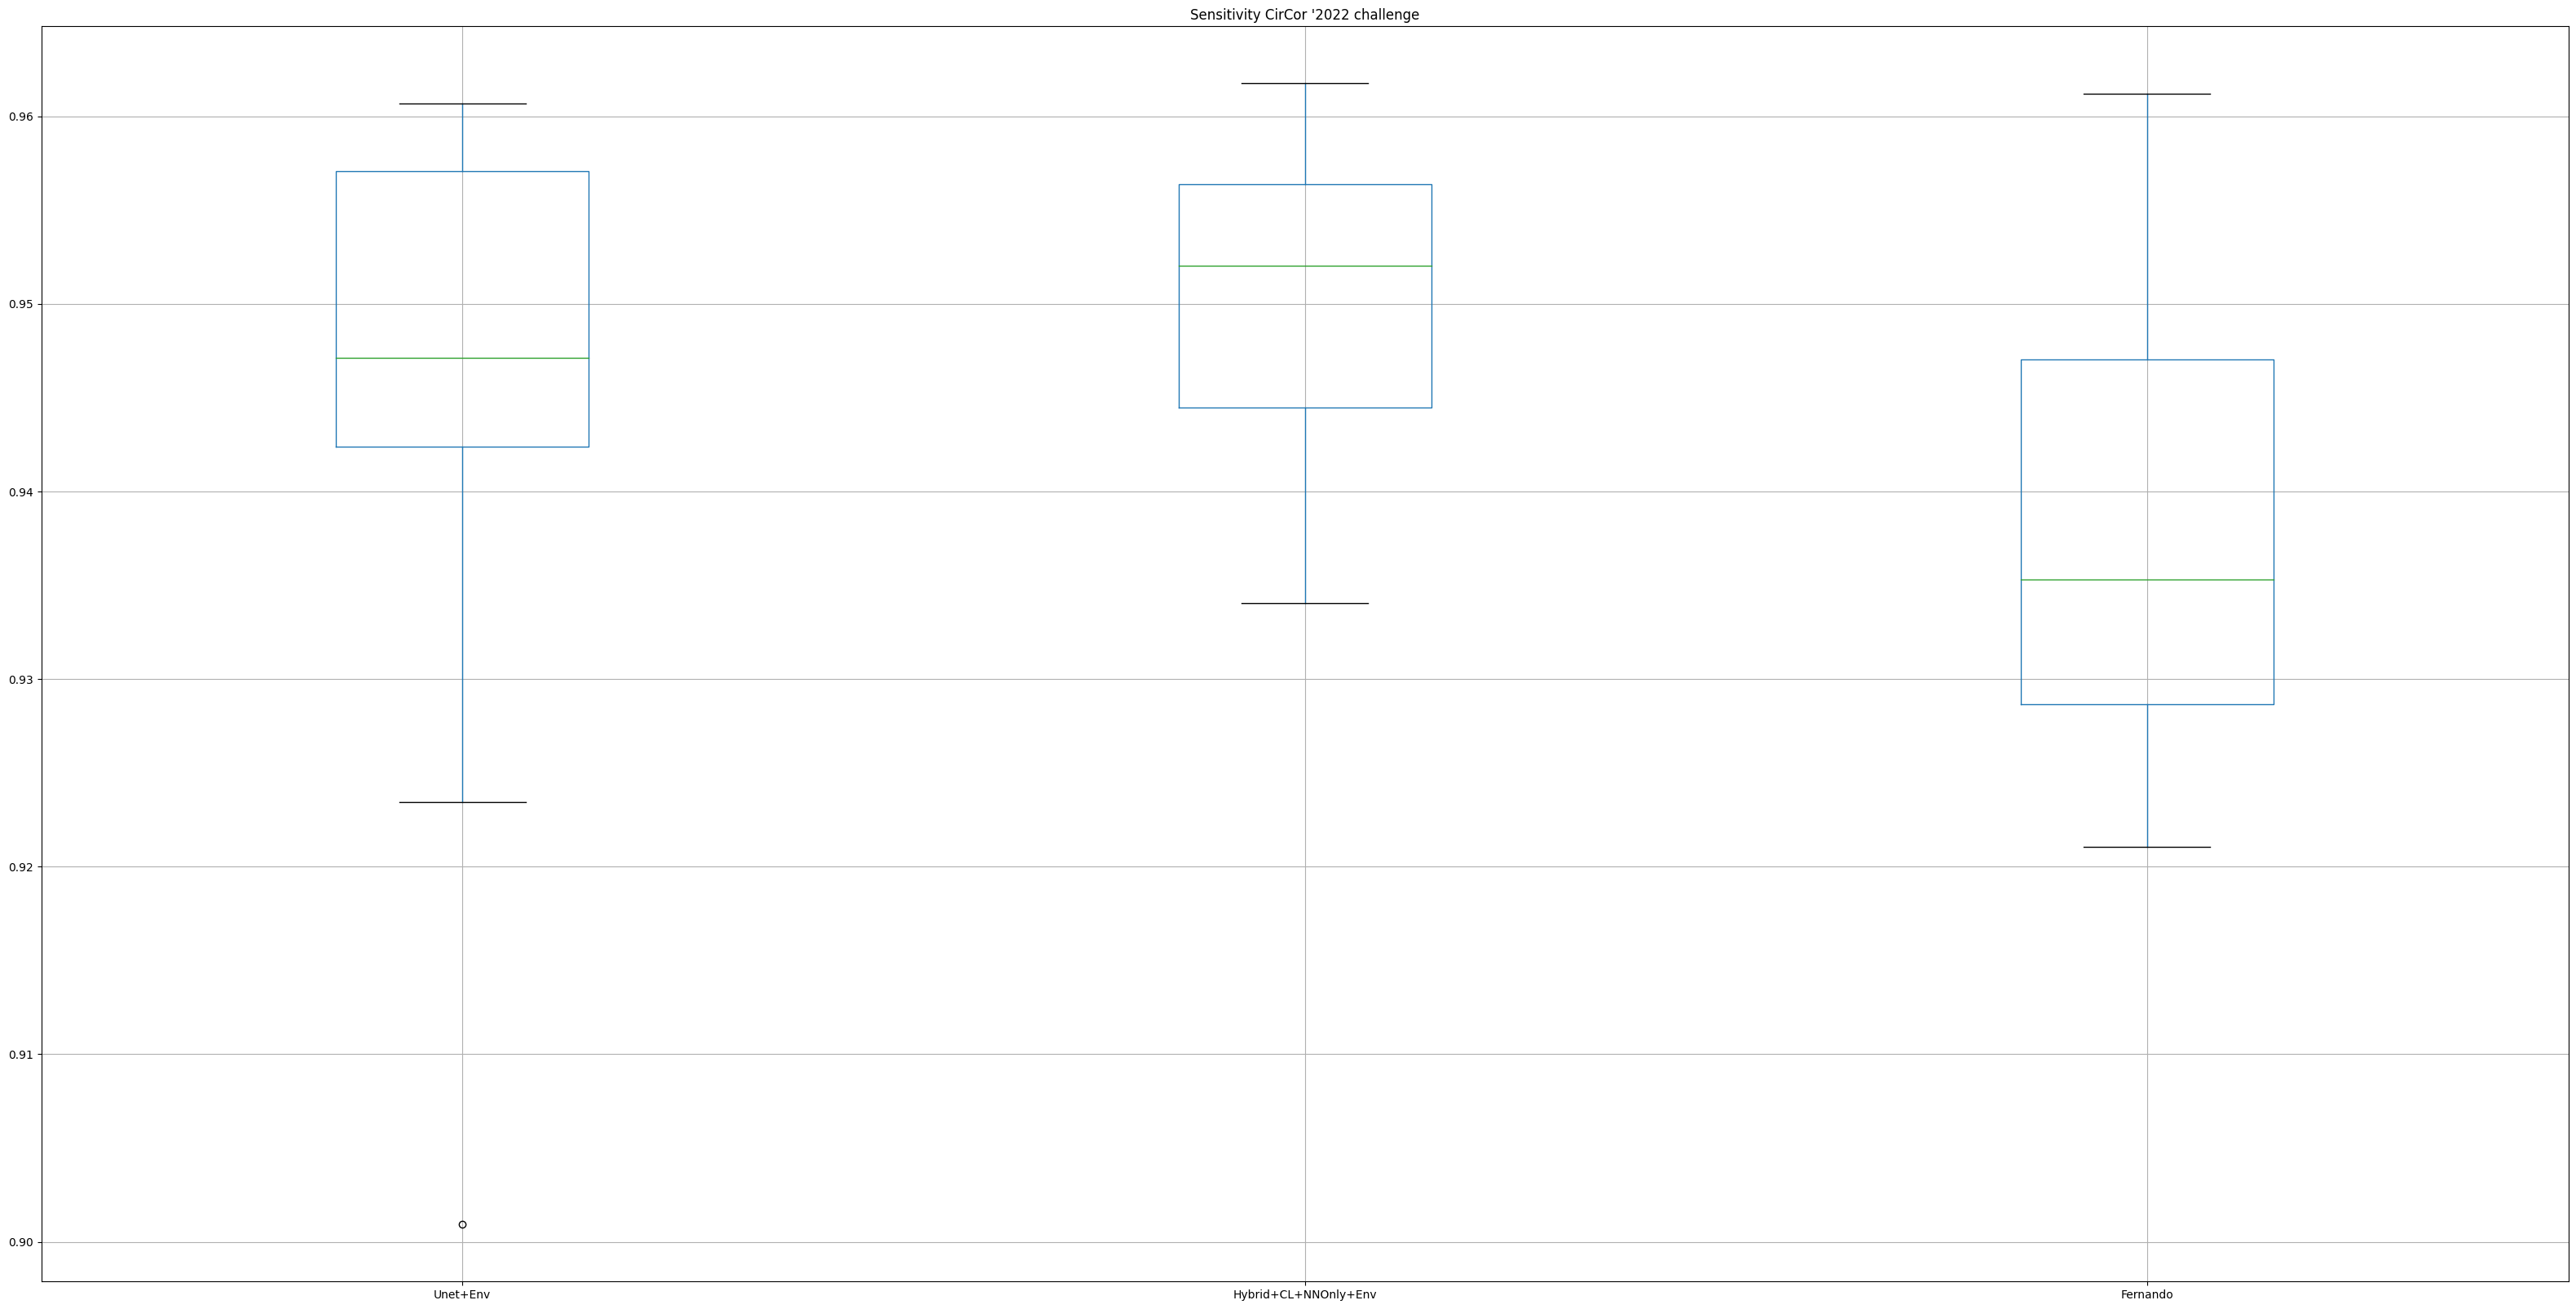

In [104]:
df = pd.DataFrame({
    'Unet+Env': circor_unet_cre_env[2],
    # 'Hybrid+CL+SGDHMM1e4+Env': circor_hybrid_env_cl_nn_only[2],
    'Hybrid+CL+NNOnly+Env': circor_nn_only_env_cl[2],
    # 'Hybrid+MMI+NNOnly+Env': circor_nn_only_env_mmi_1e3[2],
    'Fernando': circor_fernando[2]
    
                   })

boxplot = df.boxplot(column=list(df.keys()), figsize=(40,20))
plt.title('Sensitivity CirCor \'2022 challenge')
plt.show()

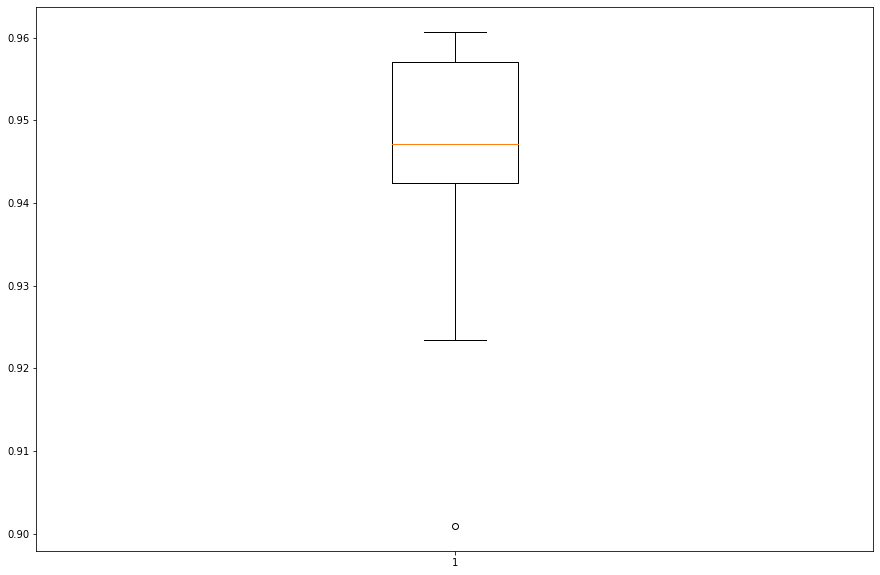

In [482]:
#boxplot = df.boxplot(column=list(df.keys()))
plt.boxplot(circor_unet_cre_env[2])['whiskers']

In [465]:

df = pd.DataFrame({
    'Unet+Env': circor_unet_cre_env[1],
    'Hybrid+CL+Env': circor_hybrid_cle_env[1],
    'Hybrid1epoch': circor_hybrid_1epoch[1],
    'Hybrid+CL+SGDHMM1e4+Env': circor_hybrid_env_cl_nn_only[1],
    'Hybrid+CL+NNOnly+Env': circor_nn_only_env_cl[1],
    'Hybrid+MMI+NNOnly+Env': circor_nn_only_env_mmi_1e4[1],
    
                   })

boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('PPV CirCor \'2022 challenge')
plt.show()


NameError: name 'circor_unet_cre_env' is not defined

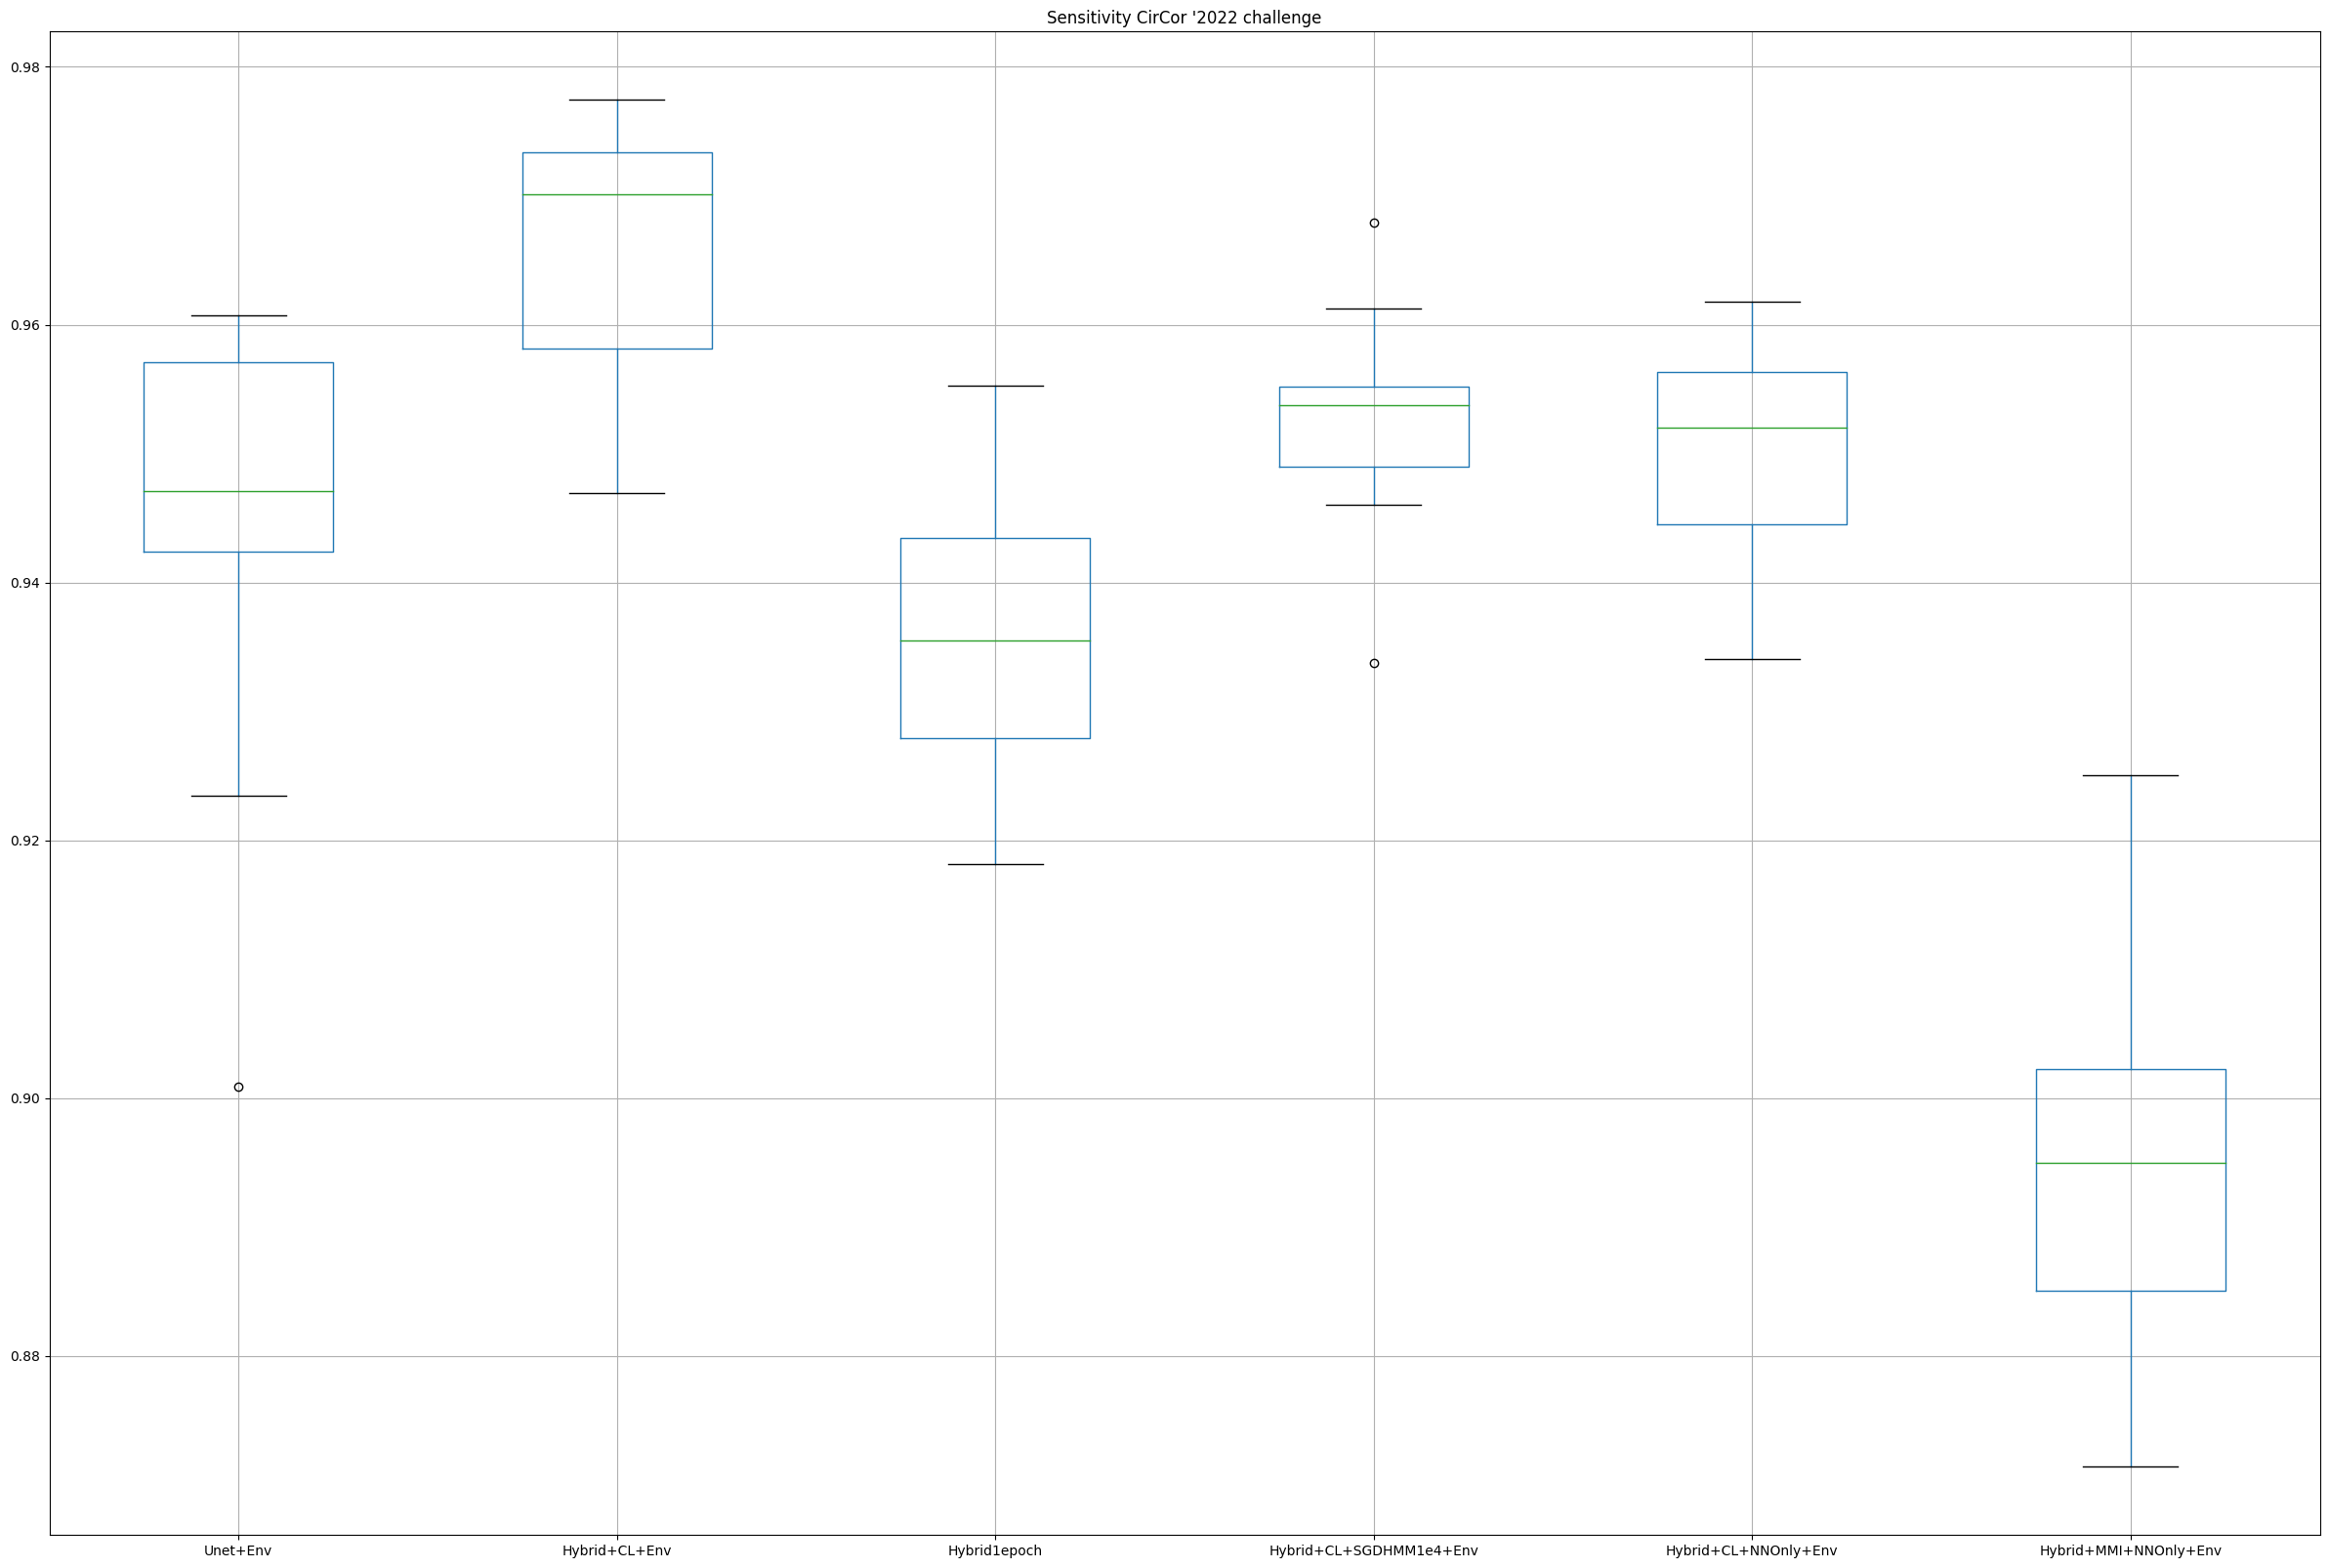

In [10]:
df = pd.DataFrame({
    'Unet+Env': circor_unet_cre_env[2],
    'Hybrid+CL+Env': circor_hybrid_cle_env[2],
    'Hybrid1epoch': circor_hybrid_1epoch[2],
    'Hybrid+CL+SGDHMM1e4+Env': circor_hybrid_env_cl_nn_only[2],
    'Hybrid+CL+NNOnly+Env': circor_nn_only_env_cl[2],
    'Hybrid+MMI+NNOnly+Env': circor_nn_only_env_mmi_1e4[2],
    
                   })

boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('Sensitivity CirCor \'2022 challenge')
plt.show()



## Statistical analysis Circor: Pairwise t-Test

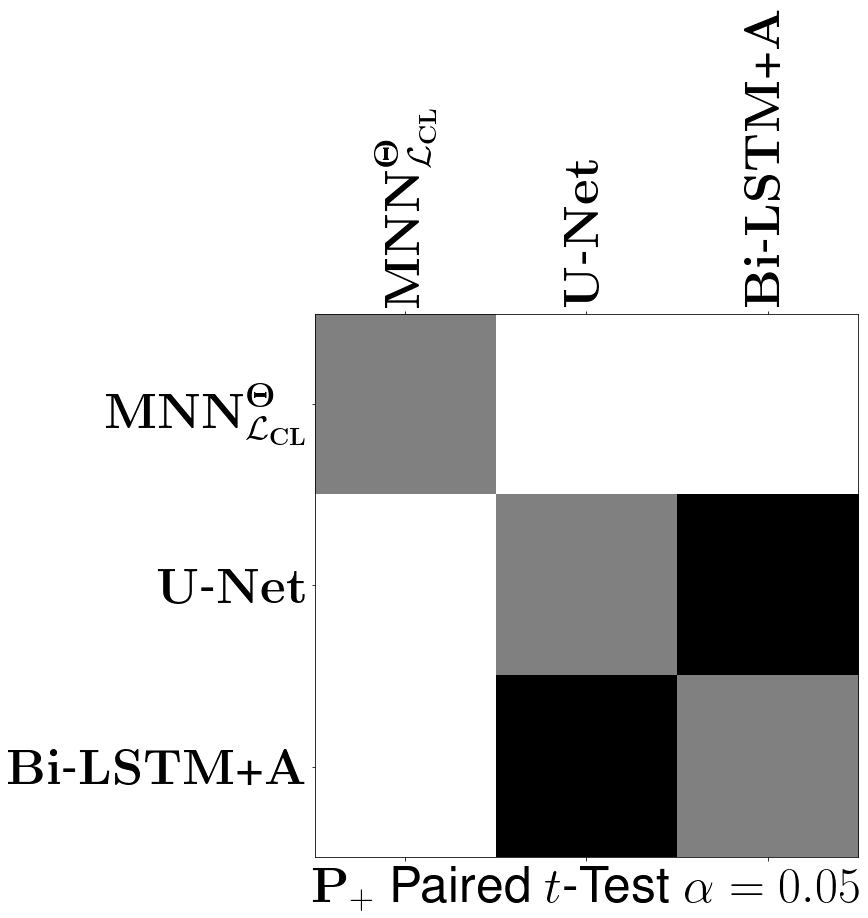

In [627]:
models_circor = {'MNN': circor_nn_only_env_cl,
    'U-Net': circor_unet_cre_env,
                 'Fernando': circor_fernando,
                 }


ppv = tuple((x, tuple(y[1])) for x, y in models_circor.items())
sens = tuple((x, tuple(y[2])) for x, y in models_circor.items())
    
pairs_ppv, t_stats_ppv, mat_ppv = paired_t_test_statistics(ppv)
ticks = [r'$\mathrm{\mathbf{MNN}}^{\mathbf{\Theta}}_{\mathcal{L}_\mathrm{\mathbf{CL}}}$','$\mathbf{U}$-$\mathbf{Net}$', '$\mathbf{Bi}$-$\mathbf{LSTM}$+$\mathbf{A}$']
plot_t_test_matrix(mat_ppv, ticks, '$\mathbf{P}_+$')

plt.savefig('circor_ppv.png', dpi=400, bbox_inches='tight',)


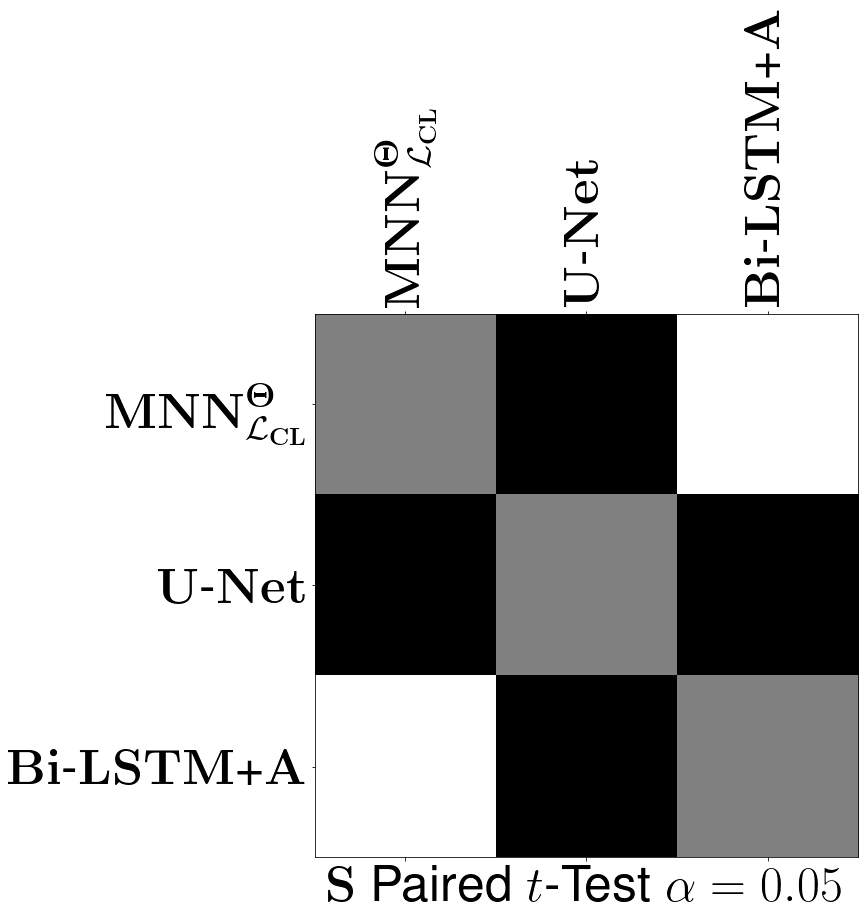

In [628]:
pairs_ppv, t_stats_ppv, mat_ppv = paired_t_test_statistics(sens)
ticks = [r'$\mathrm{\mathbf{MNN}}^{\mathbf{\Theta}}_{\mathcal{L}_\mathrm{\mathbf{CL}}}$','$\mathbf{U}$-$\mathbf{Net}$', '$\mathbf{Bi}$-$\mathbf{LSTM}$+$\mathbf{A}$']
plot_t_test_matrix(mat_ppv, ticks, '$\mathbf{S}$')

plt.savefig('circor_sens.png', dpi=400, bbox_inches='tight',)


In [558]:
def paired_t_test_statistics(samples, alpha=0.05):
    n = len(samples)
    pairings = tuple(prod for prod in itertools.product(samples, samples))
    name_pairs = [(pair[0][0], pair[1][0]) for pair in pairings]
    for pair in pairings:
        try:
            print(pair[0][0], pair[1][0])
            sp_v = stats.wilcoxon(pair[0][1], pair[1][1])
            print(stats.wilcoxon(pair[0][1], pair[1][1]))
            print()
        except:
            continue
    paired_t_test = [stats.ranksums(pair[0][1], pair[1][1]) for pair in pairings]
    matrix = [1 if (p_v:= pair.pvalue) <= alpha else 0 for pair in paired_t_test]
    return name_pairs, paired_t_test, np.array(matrix).reshape((n,n))

U-Net U-Net
U-Net Fernando
WilcoxonResult(statistic=13.0, pvalue=0.16015625)

U-Net MNN
WilcoxonResult(statistic=24.0, pvalue=0.76953125)

Fernando U-Net
WilcoxonResult(statistic=13.0, pvalue=0.16015625)

Fernando Fernando
Fernando MNN
WilcoxonResult(statistic=7.0, pvalue=0.037109375)

MNN U-Net
WilcoxonResult(statistic=24.0, pvalue=0.76953125)

MNN Fernando
WilcoxonResult(statistic=7.0, pvalue=0.037109375)

MNN MNN


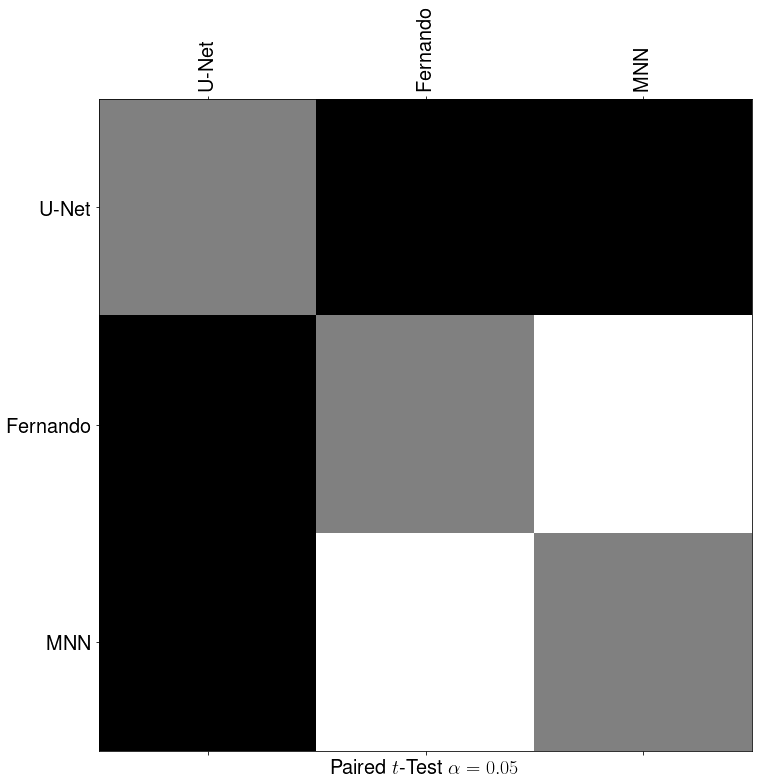

In [560]:
pairs_sens, t_stats_sens, mat_sens = paired_t_test_statistics(sens)
ticks = [name[1] for name in pairs_sens[:3]]
plot_t_test_matrix(mat_sens, ticks)

## Rerun Physionet'16
Should results suck on physionet, try mmi / CL Adam 1e-4

In [467]:
ph16_crosse_unet_env = metrics_model('results/unet/unet/2022-02-26_07_49_39')
ph16_fernando_CE_mfcc = metrics_model('results/rerun/fernando/fernando_CE_physio16_mfcc_joint/2022-09-17_07_52_13/')
ph16_hmm_nnonly_mmi_env = metrics_model('results/rerun/hybrid/hmm_nnonly_mmi_env_physio16/2022-09-17_10_08_14')
ph16_hmm_hybrid_mmi_env = metrics_model('results/rerun/hybrid/hmm_hybrid_mmi_env_physio16/2022-09-16_15_46_30')
ph16_hmm_nnonly_cl_env = metrics_model('results/rerun/hybrid/hmm_nnonly_cl_env_physio16/2022-09-18_09_38_31')
ph_16_hmm_hybird_cl_env = metrics_model('results/rerun/hybrid/hmm_hybrid_cl_env_physio16/2022-09-19_10_57_50')
ph_16_hmm_nnonly_cl_mfcc = metrics_model('results/rerun/hybrid/mfcc/2022-09-20_08_01_55')
ph_16_hmm_nnonly_cl_psd = metrics_model('results/rerun/hybrid/psd/hmm_nnonly_cl_psd_ph16/2022-09-26_11_51_19')

In [20]:
!ls results/rerun/hybrid/hmm_cl_ph16_circor/2022-09-29_10_51_18



ground_truth.mat  p_states.mat      train_indexes.mat viterbi.mat
out_seq.mat       test_indexes.mat  trans_mat.mat


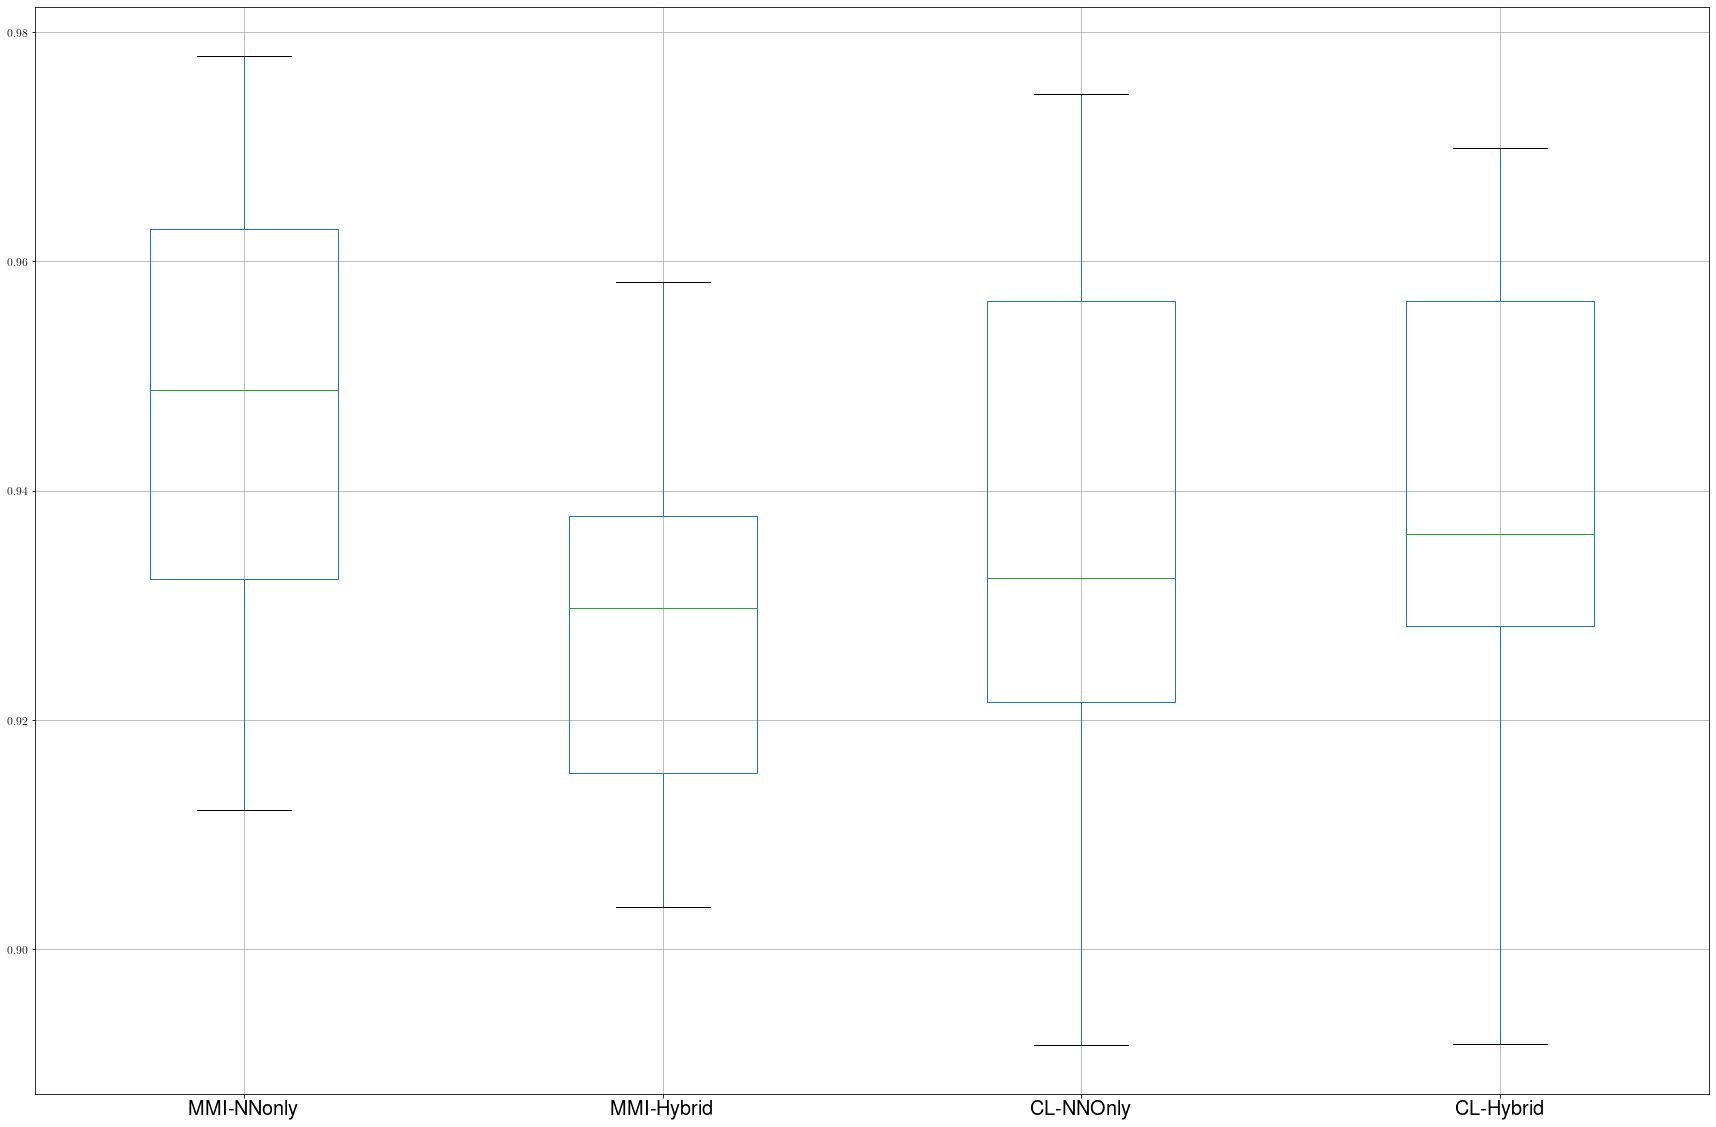

In [472]:
# ppv
ph16_mnns = df = pd.DataFrame({'MMI-NNonly': ph16_hmm_nnonly_mmi_env[1], 
                   'MMI-Hybrid': ph16_hmm_hybrid_mmi_env[1],
                   'CL-NNOnly': ph16_hmm_nnonly_cl_env[1],
                   'CL-Hybrid': ph_16_hmm_hybird_cl_env[1],})
                   # 'CL-NNonly-MFCC': ph_16_hmm_nnonly_cl_mfcc[1],
                   # 'CL-NNonly-PSD': ph_16_hmm_nnonly_cl_psd[1]})

boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))


0.94192898391212+-0.023005043292384664
0.9335772616666412+-0.021254075513862183


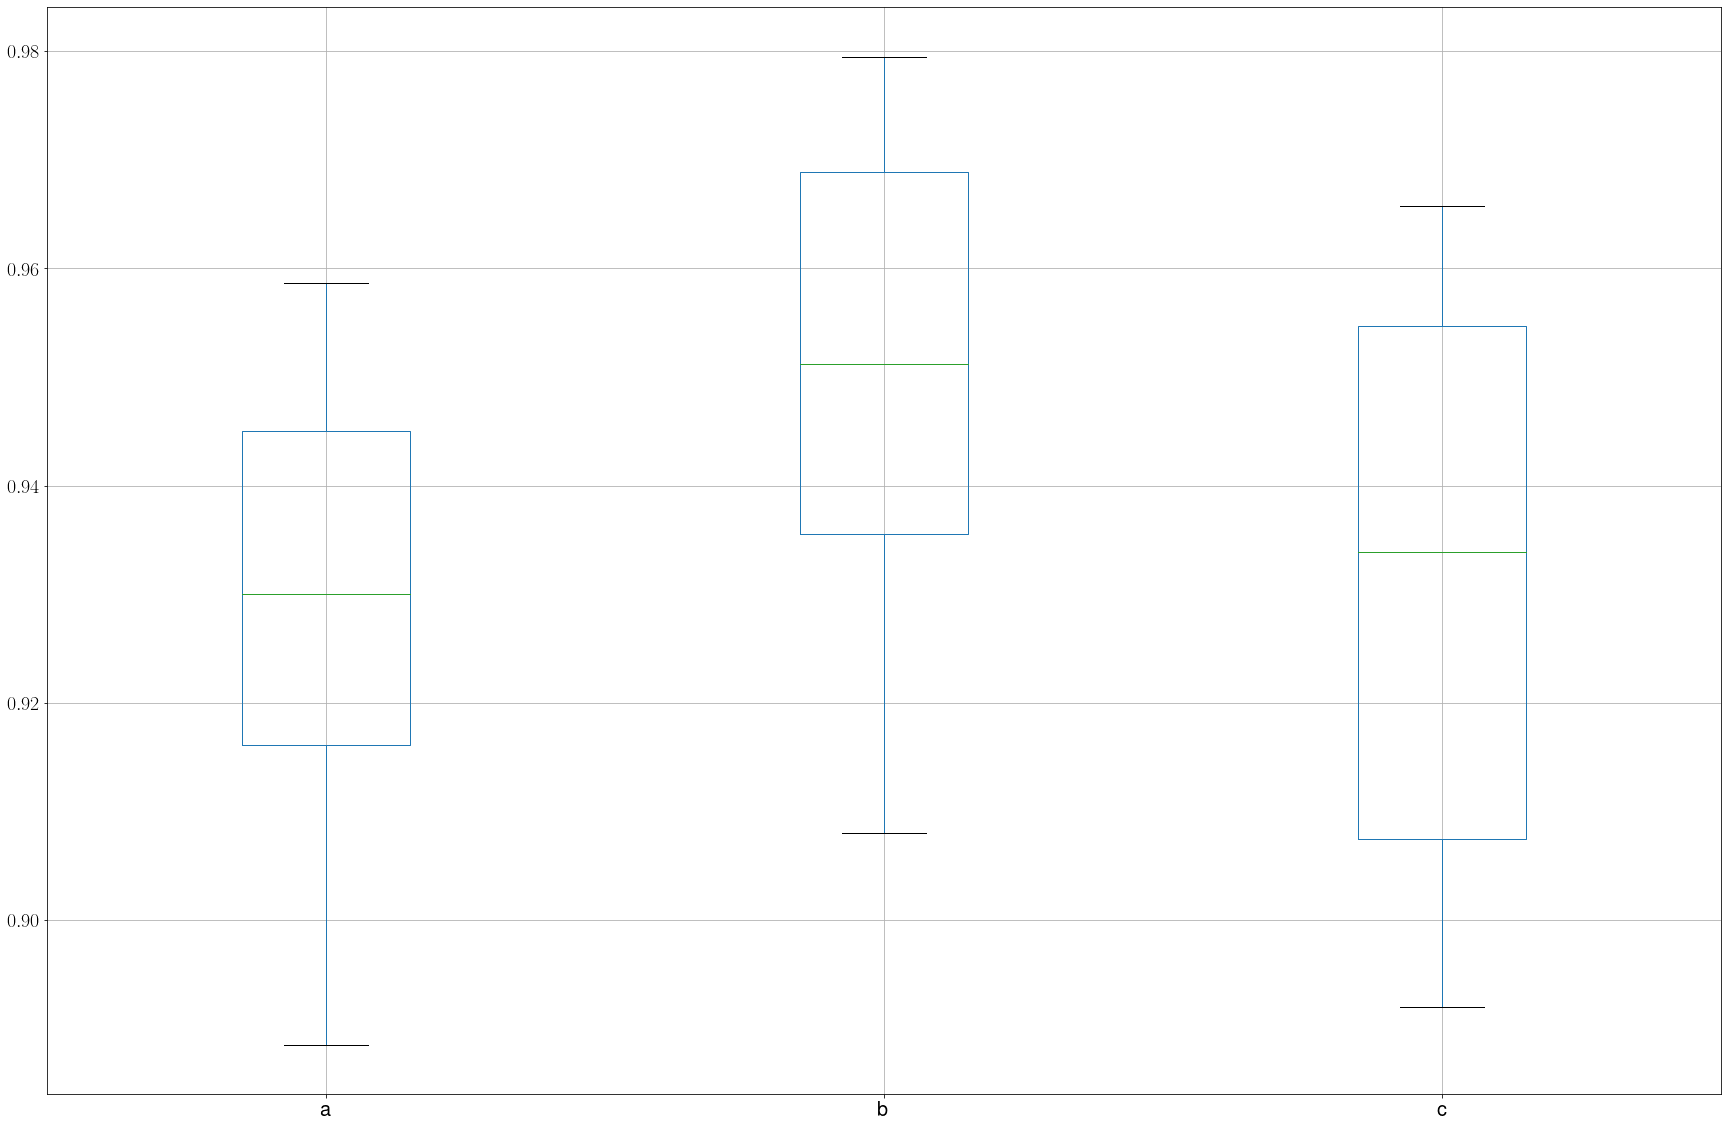

In [534]:
# ppv

ph16_mnns = df = pd.DataFrame({'a':ph_16_hmm_hybird_cl_env[2],
                               'b': ph_16_hmm_nnonly_cl_psd[2],
                               'c':ph_16_hmm_nnonly_cl_mfcc[2] })
                   # 'CL-NNonly-MFCC': ph_16_hmm_nnonly_cl_mfcc[1],
                   # 'CL-NNonly-PSD': ph_16_hmm_nnonly_cl_psd[1]})

boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
# ppv = 2*PR / P + r
f_measure = lambda x: (2 *np.array(x[1])*np.array(x[2]))/(np.array(x[1]) + np.array(x[2]))



#f_measure(ph16_hmm_nnonly_mmi_env), f_measure()

print(f'{np.mean(f_measure(ph16_hmm_nnonly_cl_env))}+-{np.std(f_measure(ph16_hmm_nnonly_cl_env))}')
print(f'{np.mean(f_measure(ph_16_hmm_hybird_cl_env))}+-{np.std(f_measure(ph_16_hmm_hybird_cl_env))}')

In [505]:
print_metric(f_measure(ph_16_hmm_hybird_cl_env), 'MMI-NNonly')

MMI-NNonly
0.9575673835893092 \\
0.9357549329630083 \\
0.9184861087210338 \\
0.890123728649956 \\
0.9512309519684689 \\
0.9642579468880215 \\
0.9223290553707519 \\
0.9204712955256074 \\
0.9486070124426806 \\
0.9269442005475749 \\


['$\\mathrm{\\mathbf{MNN}}^{\\mathbf{\\Theta}}_{\\mathcal{L}_\\mathrm{\\mathbf{MMI}}}$', '$\\mathrm{\\mathbf{MNN}}^{\\mathbf{\\Psi}}_{\\mathcal{L}_\\mathrm{\\mathbf{MMI}}}$', '$\\mathrm{\\mathbf{MNN}}^{\\mathbf{\\Theta}}_{\\mathcal{L}_\\mathrm{\\mathbf{CL}}}$', '$\\mathrm{\\mathbf{MNN}}^{\\mathbf{\\Psi}}_{\\mathcal{L}_\\mathrm{\\mathbf{CL}}}$']


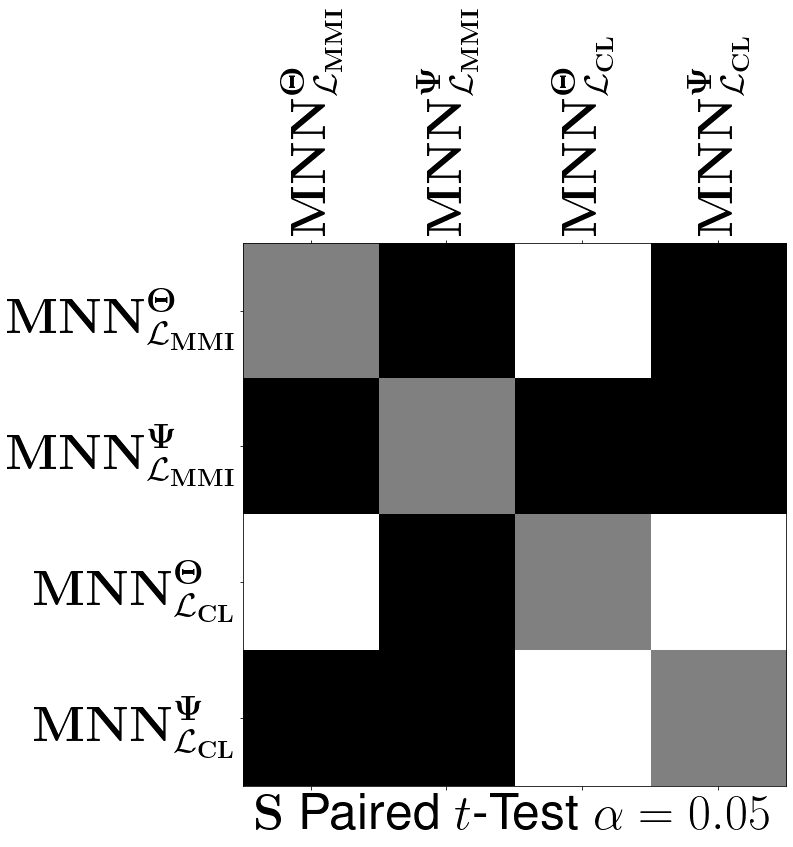

In [592]:
import itertools
val_dict = {'MMI-NNonly': ph16_hmm_nnonly_mmi_env[2], 
                   'MMI-Hybrid': ph16_hmm_hybrid_mmi_env[2],
                   'CL-NNOnly': ph16_hmm_nnonly_cl_env[2],
                   'CL-Hybrid': ph_16_hmm_hybird_cl_env[2]
           }


ppv = tuple((x, y) for x, y in val_dict.items())
#sens = tuple((x, tuple(y[0])) for x, y in val_dict.items())
def plot_t_test_matrix(mat, ticks, metric_name=''):
    mat_ = mat.copy().astype(np.float32)
    for i in range(mat.shape[0]):
        mat_[i, i] = 0.5
    fig, ax = plt.subplots()
    ax.matshow(mat_, cmap='gray', vmin=0, vmax=1, )
    
    ax.set_xticks(range(len(ticks)))
    ax.set_xticklabels(ticks, rotation='vertical')
    ax.set_yticks(range(len(ticks)))
    ax.set_yticklabels(ticks, rotation='horizontal')
    #ax.set_title(f'{metric_name} Paired $t$-Test $n=10$')
    plt.xlabel(f'{metric_name}' + r' Paired $t$-Test $\alpha=0.05$')
    #plt.savefig(f'{metric_name}.png', dpi=1200, bbox_inches='tight',)
    
pairs, t_stats, mat = paired_t_test_statistics(ppv)
ticks = list(val_dict.keys())
ticks = ['$\mathrm{\mathbf{MNN}}^{\mathbf{\Theta}}_{\mathcal{L}_\mathrm{\mathbf{MMI}}}$',
        '$\mathrm{\mathbf{MNN}}^{\mathbf{\Psi}}_{\mathcal{L}_\mathrm{\mathbf{MMI}}}$',
        '$\mathrm{\mathbf{MNN}}^{\mathbf{\Theta}}_{\mathcal{L}_\mathrm{\mathbf{CL}}}$',
        '$\mathrm{\mathbf{MNN}}^{\mathbf{\Psi}}_{\mathcal{L}_\mathrm{\mathbf{CL}}}$']
print(ticks)
#plt.figure(dpi=400)
plot_t_test_matrix(mat, ticks, r'$\mathbf{S}$')
plt.savefig('mnn_sens_ph16.png', dpi=400, bbox_inches='tight',)


In [590]:
!open .

['$\\mathbf{X}_{\\mathrm{Env}}$', '$\\mathbf{X}_{\\mathrm{PSD}}$', '$\\mathbf{X}_{\\mathrm{MFCC}}$']


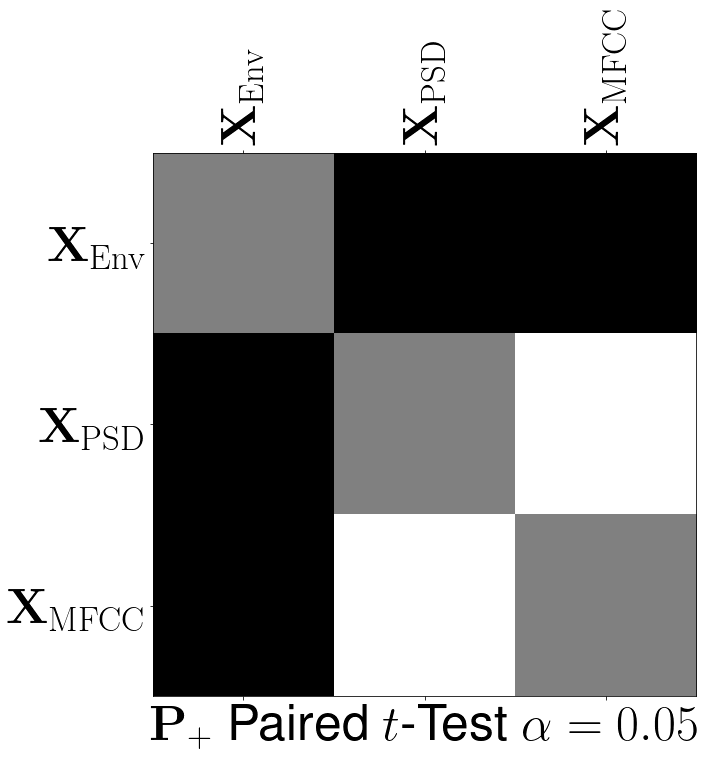

In [599]:
val_dict = {'a':ph_16_hmm_hybird_cl_env, 'b': ph_16_hmm_nnonly_cl_psd, 'c':ph_16_hmm_nnonly_cl_mfcc }

ppv = tuple((x, y[0]) for x, y in val_dict.items())
sens = tuple((x, y[1]) for x, y in val_dict.items())
pairs, t_stats, mat = paired_t_test_statistics(ppv)
ticks = list(val_dict.keys())
ticks = ['$\mathbf{X}_{\mathrm{Env}}$',
        '$\mathbf{X}_{\mathrm{PSD}}$',
        '$\mathbf{X}_{\mathrm{MFCC}}$',]
print(ticks)
#plt.figure(dpi=400)
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE) 
plot_t_test_matrix(mat, ticks, r'$\mathbf{P}_+$')
plt.savefig('features-ppv.png', dpi=400, bbox_inches='tight',)

['$\\mathbf{X}_{\\mathrm{Env}}$', '$\\mathbf{X}_{\\mathrm{PSD}}$', '$\\mathbf{X}_{\\mathrm{MFCC}}$']


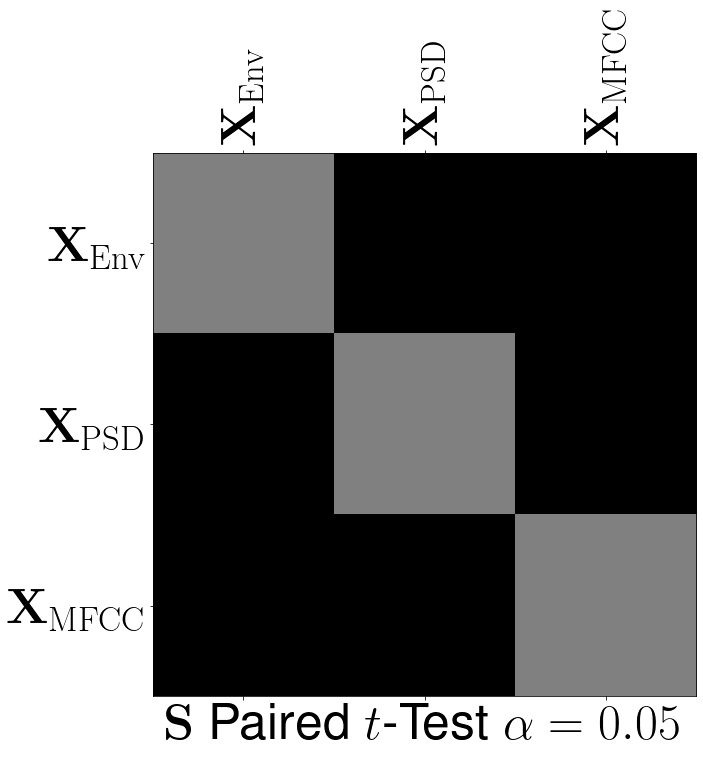

In [600]:
pairs, t_stats, mat = paired_t_test_statistics(sens)
ticks = list(val_dict.keys())
ticks = ['$\mathbf{X}_{\mathrm{Env}}$',
        '$\mathbf{X}_{\mathrm{PSD}}$',
        '$\mathbf{X}_{\mathrm{MFCC}}$',]
print(ticks)
#plt.figure(dpi=400)
plot_t_test_matrix(mat, ticks, r'$\mathbf{S}$')
plt.savefig('features-sens.png', dpi=400, bbox_inches='tight',)

In [601]:
!open .

Text(0.5, 1.0, "PPV Physionet'2016 challenge")

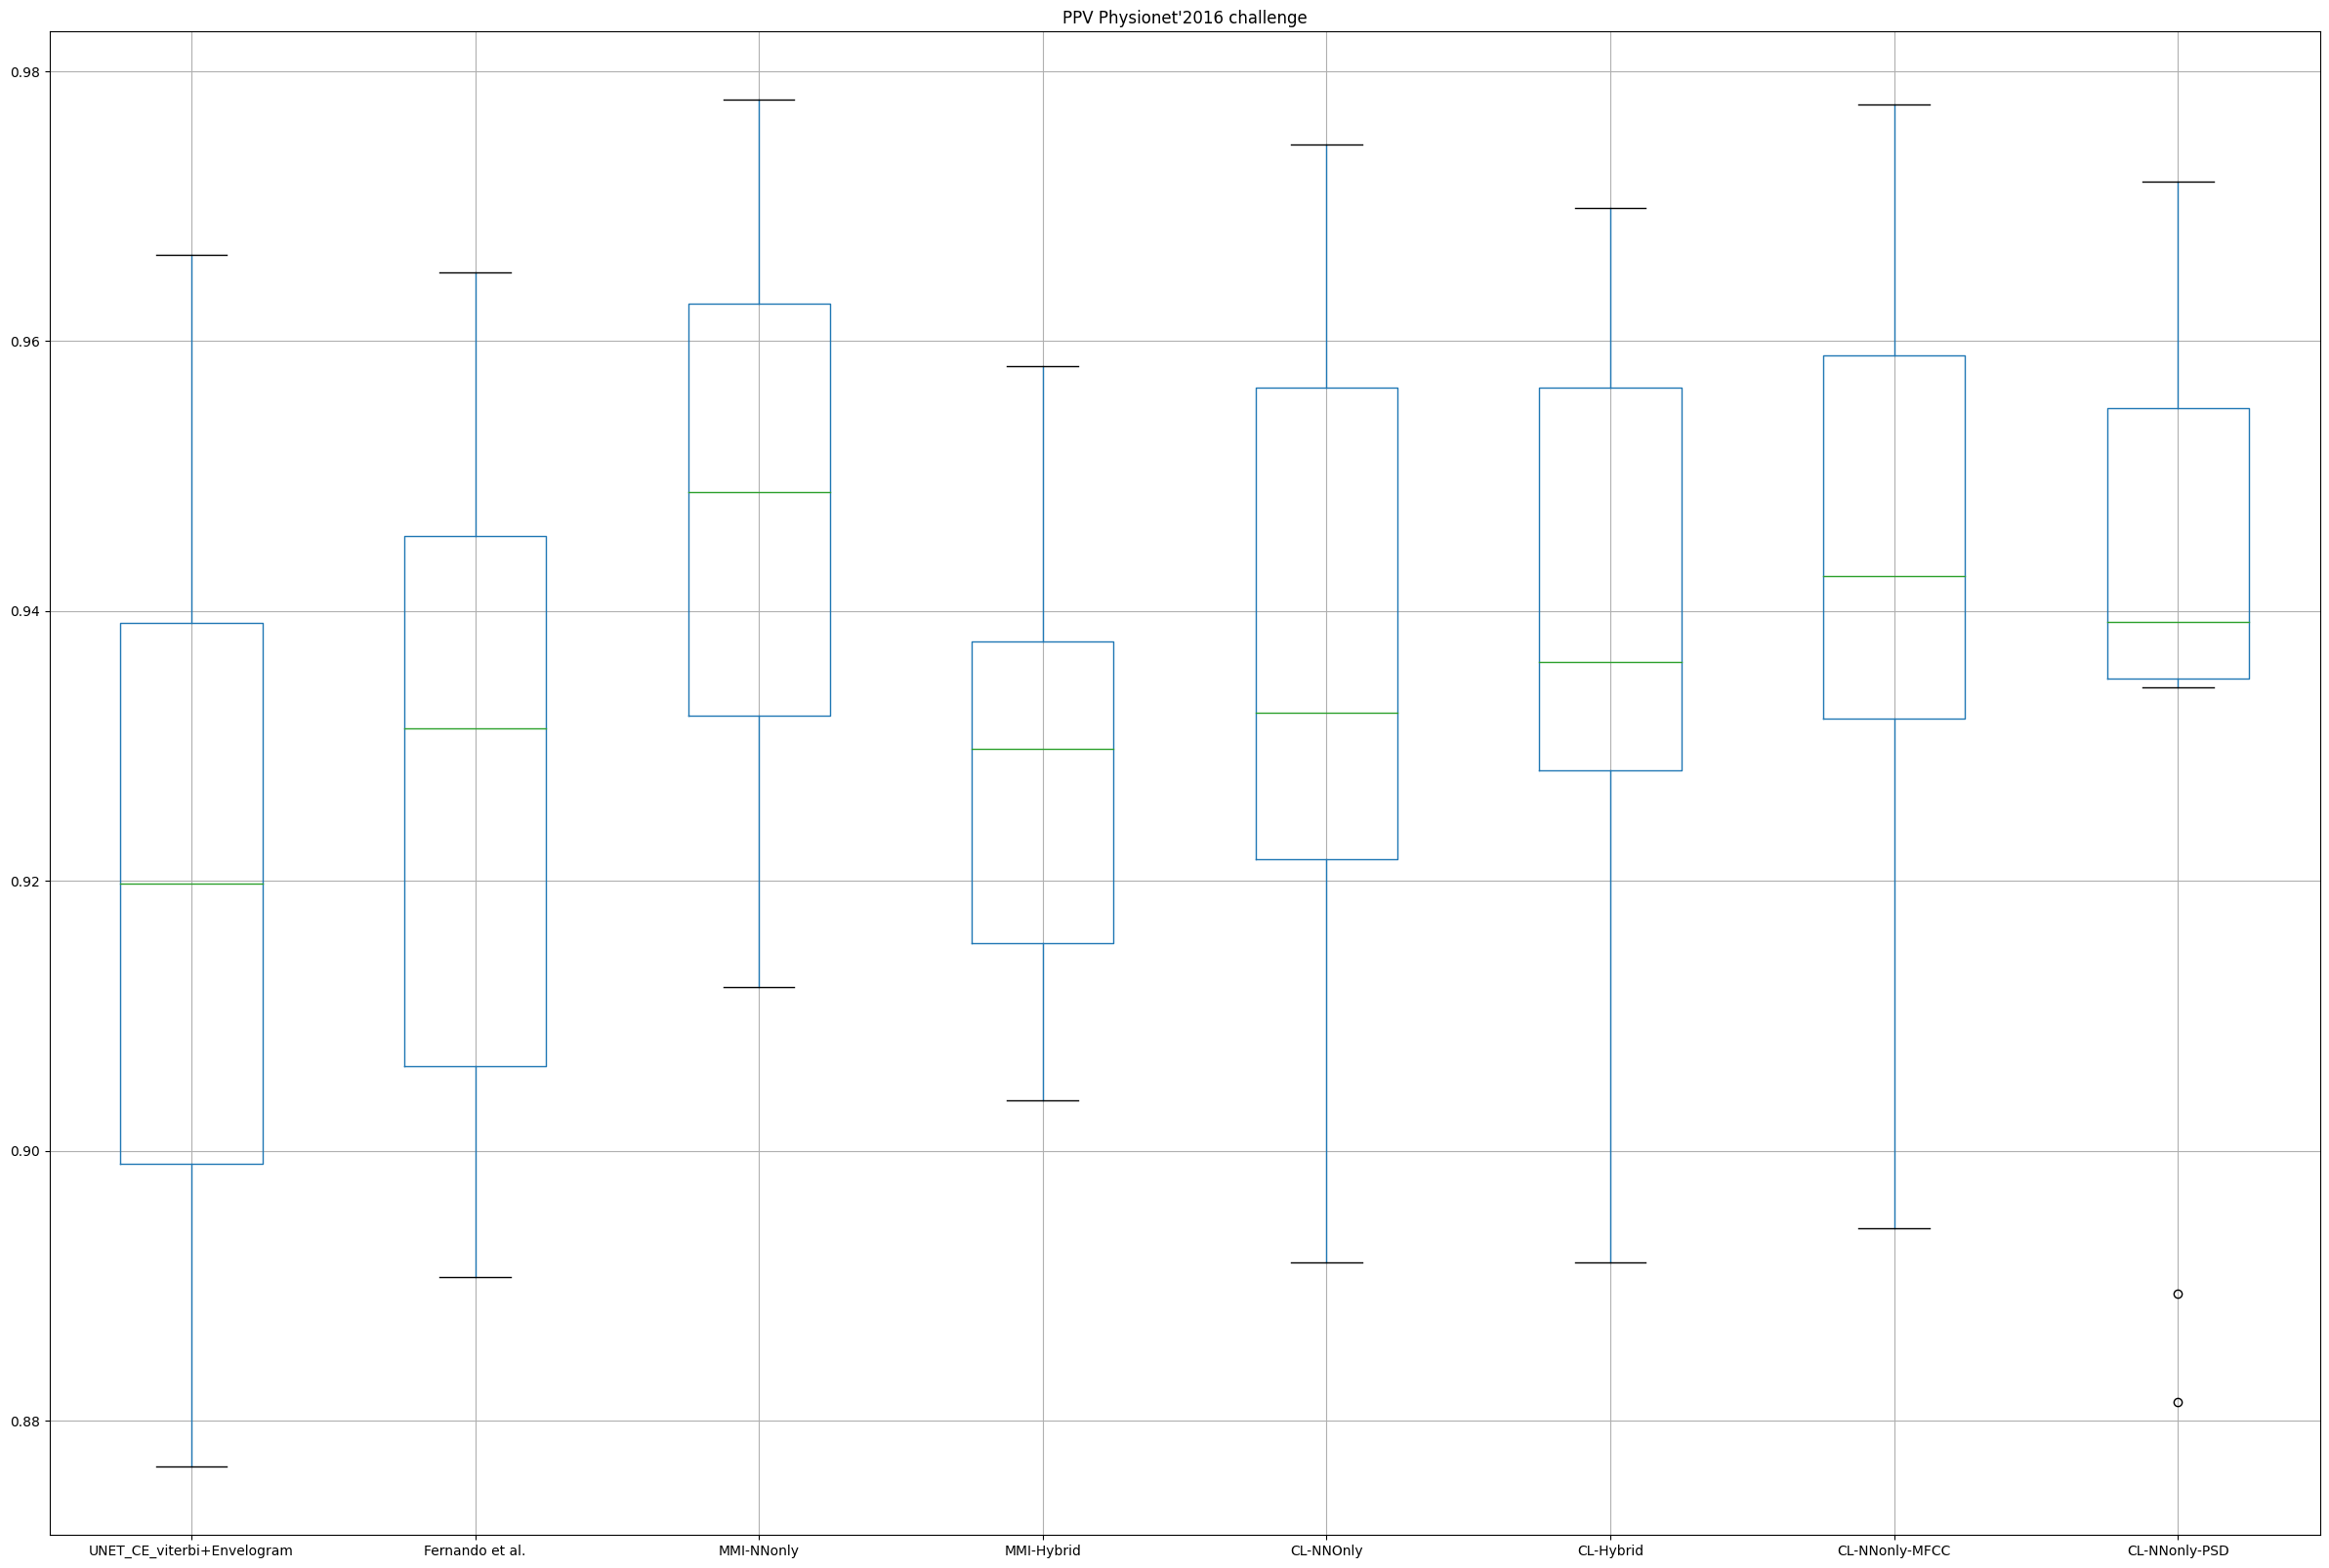

In [21]:
df = pd.DataFrame({'UNET_CE_viterbi+Envelogram': ph16_crosse_unet_env[1],
                   'Fernando et al.': ph16_fernando_CE_mfcc[1],
                   'MMI-NNonly': ph16_hmm_nnonly_mmi_env[1], 
                   'MMI-Hybrid': ph16_hmm_hybrid_mmi_env[1],
                   'CL-NNOnly': ph16_hmm_nnonly_cl_env[1],
                   'CL-Hybrid': ph_16_hmm_hybird_cl_env[1],
                   'CL-NNonly-MFCC': ph_16_hmm_nnonly_cl_mfcc[1],
                   'CL-NNonly-PSD': ph_16_hmm_nnonly_cl_psd[1]
                   }) # no grads CL, no grads MMI,  CL envelogram, corrected fernando
boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('PPV Physionet\'2016 challenge')


Text(0.5, 1.0, "Sens Physionet'2016 challenge")

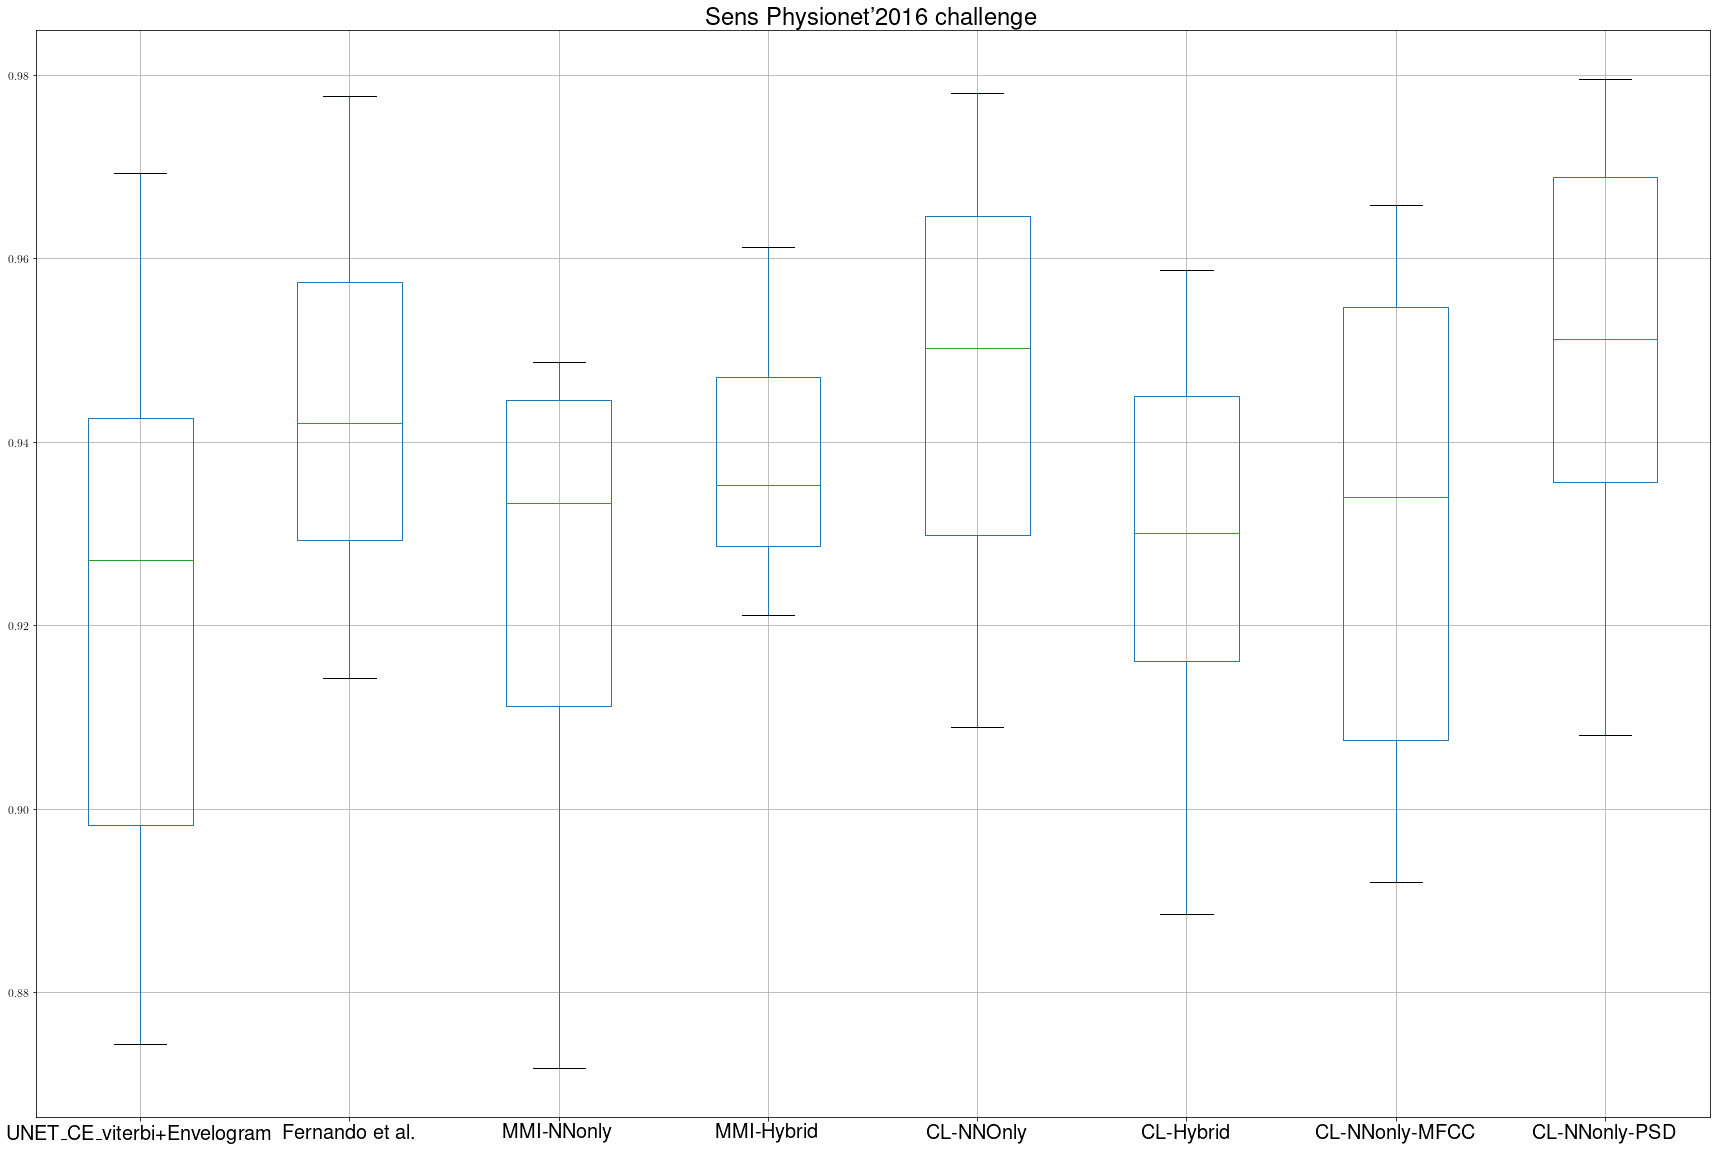

In [479]:
df = pd.DataFrame({'UNET_CE_viterbi+Envelogram': ph16_crosse_unet_env[2],
                   'Fernando et al.': ph16_fernando_CE_mfcc[2],
                   'MMI-NNonly': ph16_hmm_nnonly_mmi_env[2], 
                   'MMI-Hybrid': ph16_hmm_hybrid_mmi_env[2],
                   'CL-NNOnly': ph16_hmm_nnonly_cl_env[2],
                   'CL-Hybrid': ph_16_hmm_hybird_cl_env[2],
                   'CL-NNonly-MFCC': ph_16_hmm_nnonly_cl_mfcc[2],
                   'CL-NNonly-PSD': ph_16_hmm_nnonly_cl_psd[2]
                   }) # no grads CL, no grads MMI,  CL envelogram, corrected fernando
boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('Sens Physionet\'2016 challenge')

In [28]:
# ppv
ph16_mnns = {'MMI-NNonly': ph16_hmm_nnonly_mmi_env[1], 
                   'MMI-Hybrid': ph16_hmm_hybrid_mmi_env[1],
                   'CL-NNOnly': ph16_hmm_nnonly_cl_env[1],
                   'CL-Hybrid': ph_16_hmm_hybird_cl_env[1],
                   'CL-NNonly-MFCC': ph_16_hmm_nnonly_cl_mfcc[1],
                   'CL-NNonly-PSD': ph_16_hmm_nnonly_cl_psd[1]}

get_boxplot_stats(np.array(ph16_mnns['MMI-NNonly'])) , ph16_mnns['MMI-NNonly']

def print_for_tikz(lst):
    for i in lst:
        print(f"{i} \\\\")

        
        
for i in ['MMI-NNonly', 'MMI-Hybrid', 'CL-NNOnly', 'CL-Hybrid']:
    print(i)
    print_for_tikz(ph16_mnns[i])
    print('*'*10)
    print()


MMI-NNonly
0.9553971580431537 \\
0.9485308023757721 \\
0.9121550773968308 \\
0.9152812468339278 \\
0.9778888119494582 \\
0.9722400006231395 \\
0.9342356002516128 \\
0.9490768952671952 \\
0.9652473887429165 \\
0.9316115889680601 \\
**********

MMI-Hybrid
0.9343151418882716 \\
0.9333232509271304 \\
0.9262887018594234 \\
0.938925698035983 \\
0.914381963624666 \\
0.958177631935309 \\
0.9184537072154318 \\
0.9089033403499405 \\
0.9037119619080892 \\
0.956309189202954 \\
**********

CL-NNOnly
0.947065363576784 \\
0.9295637360658968 \\
0.908518620708735 \\
0.8916944772849247 \\
0.9706909030512288 \\
0.9745946437633035 \\
0.9351972374495324 \\
0.9296563651233425 \\
0.9597453944219765 \\
0.918911876678244 \\
**********

CL-Hybrid
0.9568044651702076 \\
0.9365291052671817 \\
0.9119285254229702 \\
0.8917330534565007 \\
0.9559169620987717 \\
0.9698811327005532 \\
0.9358773546082293 \\
0.9274553221795687 \\
0.9570774950335801 \\
0.9302699216535115 \\
**********



In [34]:
ph16_comparisons = {'UNET_CE_viterbi+Envelogram': ph16_crosse_unet_env[1],
                   'Fernando et al.': ph16_fernando_CE_mfcc[1],
                    'CL-NNOnly': ph16_hmm_nnonly_cl_env[1],}


for i in ['UNET_CE_viterbi+Envelogram', 'Fernando et al.', 'CL-NNOnly']:
    print(i)
    print_for_tikz(ph16_comparisons[i])
    print()

UNET_CE_viterbi+Envelogram
0.9430145399874021 \\
0.8989534706697802 \\
0.8991720627263453 \\
0.8765893773751824 \\
0.9664178702254659 \\
0.9197530836765836 \\
0.8864160190289788 \\
0.9274869897517541 \\
0.9599684675704532 \\
0.9198604208033603 \\

Fernando et al.
0.945683019934326 \\
0.9276342018831656 \\
0.8906153009103077 \\
0.8907971992181448 \\
0.9650844094577082 \\
0.9593324826232482 \\
0.9291497041902513 \\
0.9334293969433666 \\
0.945134862583885 \\
0.899126136718618 \\

CL-NNOnly
0.947065363576784 \\
0.9295637360658968 \\
0.908518620708735 \\
0.8916944772849247 \\
0.9706909030512288 \\
0.9745946437633035 \\
0.9351972374495324 \\
0.9296563651233425 \\
0.9597453944219765 \\
0.918911876678244 \\



Text(0.5, 1.0, "Sensitivity Physionet'2016 challenge")

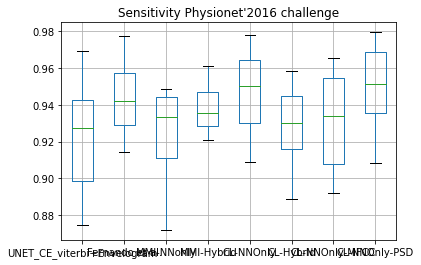

In [11]:
# TODO: show the different features used (env, psd, mfcc)
df = pd.DataFrame({'UNET_CE_viterbi+Envelogram': ph16_crosse_unet_env[2],
                   'Fernando et al.': ph16_fernando_CE_mfcc[2],
                   'MMI-NNonly': ph16_hmm_nnonly_mmi_env[2], # run at 1e-3
                   'MMI-Hybrid': ph16_hmm_hybrid_mmi_env[2],
                   'CL-NNOnly': ph16_hmm_nnonly_cl_env[2], # run at 1e-3 maybe try 1e-4,
                   'CL-Hybrid': ph_16_hmm_hybird_cl_env[2],
                   'CL-NNOnly-MFCC': ph_16_hmm_nnonly_cl_mfcc[2],
                   'CL-NNOnly-PSD': ph_16_hmm_nnonly_cl_psd[2]
                   }) # no grads CL, no grads MMI,  CL envelogram, corrected fernando
boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('Sensitivity Physionet\'2016 challenge')

In [12]:
val_dict = {'MMI-NNonly': ph16_hmm_nnonly_mmi_env, 
           'MMI-Hybrid': ph16_hmm_hybrid_mmi_env,
           'CL-NNOnly': ph16_hmm_nnonly_cl_env,
           'CL-Hybrid': ph_16_hmm_hybird_cl_env,
           'CL-NNonly-MFCC': ph_16_hmm_nnonly_cl_mfcc,
           'CL-NNonly-PSD': ph_16_hmm_nnonly_cl_psd}

## Statistical analysis: Find best Markov Model PH16 10-fold
### pair-wise matrix (paired t-test)


# T-Test PPV and Sensitivity
Note how only the CL-NNonly is statistically different from MM-NN only for their two variants

['$a$', '$b$', '$c$', '$\\alpha$']


<Figure size 7680x5760 with 0 Axes>

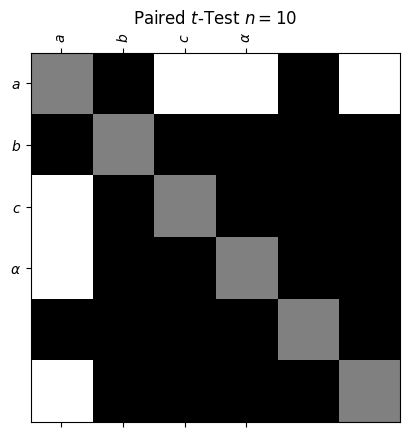

In [18]:
#plt.rcParams.update({
#     "text.usetex": True,
#    "font.family": "Helvetica"
#  })
import itertools
ppv = tuple((x, tuple(y[1])) for x, y in val_dict.items())
sens = tuple((x, tuple(y[2])) for x, y in val_dict.items())
    
pairs, t_stats, mat = paired_t_test_statistics(ppv)
ticks = [name[1] for name in pairs[:6]]
ticks = [r'$a$', 
         r'$b$', 
         r'$c$',
         r'$\alpha$']
print(ticks)
plt.figure(dpi=1200)
plot_t_test_matrix(mat, ticks)

In [ ]:
pairs_sens, t_stats_sens, mat_sens = paired_t_test_statistics(sens)
ticks = [name[1] for name in pairs[:6]]
plt.figure(dpi=1200)
plot_t_test_matrix(mat_sens, ticks)

### Best model: 'CL-NNOnly': ph16_hmm_nnonly_cl_env,
Now compute differences with other models!

## MNN vs other models: PH16 10 fold
MNN Complete Likelihood NN only + Envelogram
U-NET windowed crossentropy + Envelogram
Fernando Bi-LSTM+Attention + MFCCC

MNN is statisitcally difference from U-Net and Fernando in PPV, and from U-Net in 

In [148]:
ph16_dict = {'CL-NNOnly': ph16_hmm_nnonly_cl_env,
             'U-NET': ph16_crosse_unet_env,
             'Fernando': ph16_fernando_CE_mfcc}

ppv = tuple((x, tuple(y[1])) for x, y in ph16_dict.items())
sens = tuple((x, tuple(y[2])) for x, y in ph16_dict.items())

In [523]:


def plot_t_test_matrix(mat, ticks, metric_name=''):
    mat_ = mat.copy().astype(np.float32)
    for i in range(mat.shape[0]):
        mat_[i, i] = 0.5
    fig, ax = plt.subplots()
    ax.matshow(mat_, cmap='gray', vmin=0, vmax=1, )
    
    ax.set_xticks(range(len(ticks)))
    ax.set_xticklabels(ticks, rotation='vertical')
    ax.set_yticks(range(len(ticks)))
    ax.set_yticklabels(ticks, rotation='horizontal')
    #ax.set_title(f'{metric_name} Paired $t$-Test $n=10$')
    plt.xlabel(f'{metric_name}' + r' Paired $t$-Test $\alpha=0.05$')
    # plt.savefig(f'{metric_name}.png', dpi=1200, bbox_inches='tight',)
    


[('CL-NNOnly', 'CL-NNOnly'), ('CL-NNOnly', 'U-NET'), ('CL-NNOnly', 'Fernando'), ('U-NET', 'CL-NNOnly'), ('U-NET', 'U-NET'), ('U-NET', 'Fernando'), ('Fernando', 'CL-NNOnly'), ('Fernando', 'U-NET'), ('Fernando', 'Fernando')]


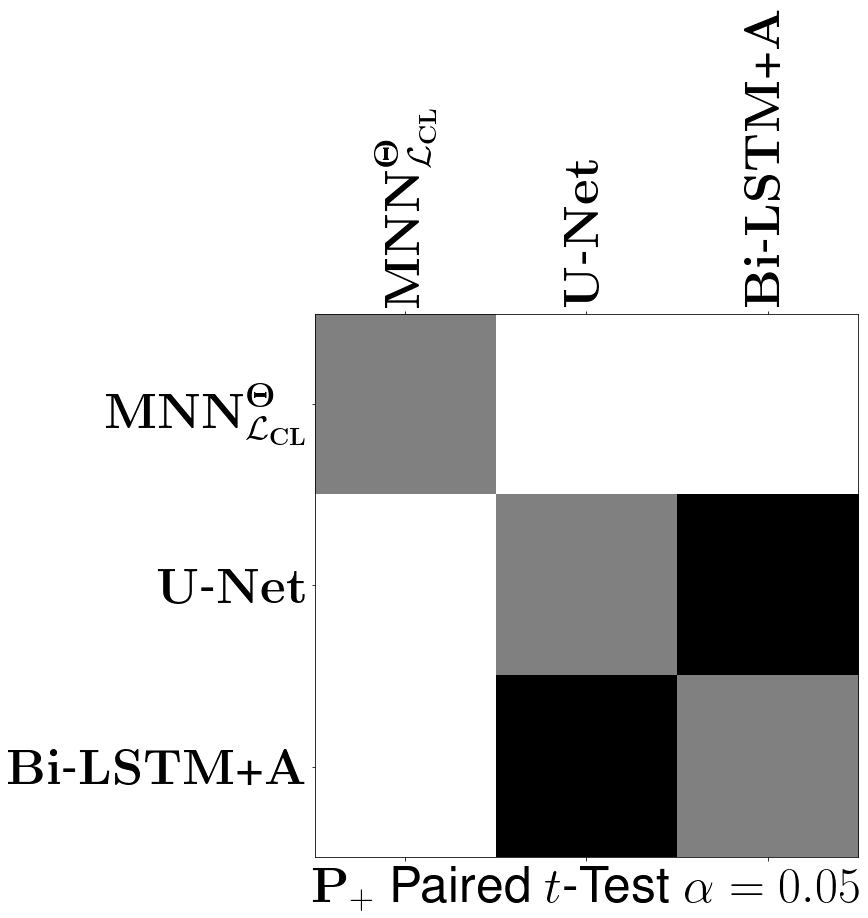

In [625]:
ph16_dict = {'CL-NNOnly': ph16_hmm_nnonly_cl_env,
             'U-NET': ph16_crosse_unet_env,
             'Fernando': ph16_fernando_CE_mfcc}

ppv = tuple((x, tuple(y[1])) for x, y in ph16_dict.items())
sens = tuple((x, tuple(y[2])) for x, y in ph16_dict.items())


pairs_ppv, t_stats_ppv, mat_ppv = paired_t_test_statistics(ppv)
print(pairs_ppv)
ticks = [r'$\mathrm{\mathbf{MNN}}^{\mathbf{\Theta}}_{\mathcal{L}_\mathrm{\mathbf{CL}}}$','$\mathbf{U}$-$\mathbf{Net}$', '$\mathbf{Bi}$-$\mathbf{LSTM}$+$\mathbf{A}$']
plot_t_test_matrix(mat_ppv, ticks, '$\mathbf{P_+}$')

plt.savefig('ph16-ppv', dpi=400, bbox_inches='tight',)

[('CL-NNOnly', 'CL-NNOnly'), ('CL-NNOnly', 'U-NET'), ('CL-NNOnly', 'Fernando'), ('U-NET', 'CL-NNOnly'), ('U-NET', 'U-NET'), ('U-NET', 'Fernando'), ('Fernando', 'CL-NNOnly'), ('Fernando', 'U-NET'), ('Fernando', 'Fernando')]


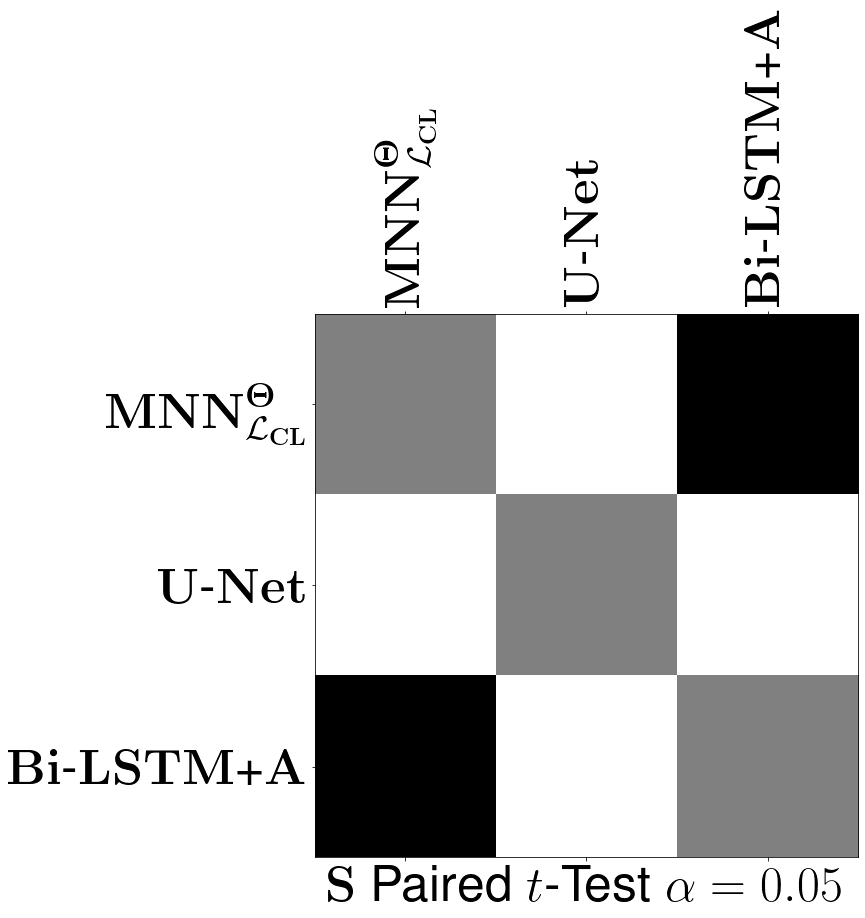

In [624]:
pairs_ppv, t_stats_ppv, mat_ppv = paired_t_test_statistics(sens)
print(pairs_ppv)
ticks = [r'$\mathrm{\mathbf{MNN}}^{\mathbf{\Theta}}_{\mathcal{L}_\mathrm{\mathbf{CL}}}$','$\mathbf{U}$-$\mathbf{Net}$', '$\mathbf{Bi}$-$\mathbf{LSTM}$+$\mathbf{A}$']
plot_t_test_matrix(mat_ppv, ticks, '$\mathbf{S}$')
plt.savefig('ph16-s', dpi=400, bbox_inches='tight',)

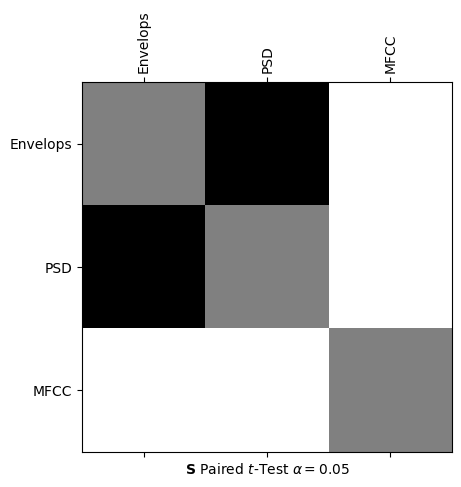

In [179]:
pairs_sens, t_stats_sens, mat_sens = paired_t_test_statistics(sens)
ticks = ['Envelops', 'PSD', 'MFCC']
plot_t_test_matrix(mat_sens, ticks, '$\mathbf{S}$')

In [168]:
models_circor = {'MNN': circor_nn_only_env_cl,
                 'U-Net': circor_unet_cre_env,
                 'Fernando': circor_fernando,
                 }


ppv = tuple((x, tuple(y[1])) for x, y in models_circor.items())
sens = tuple((x, tuple(y[2])) for x, y in models_circor.items())


def plot_t_test_matrix(mat, ticks, metric_name=''):
    mat_ = mat.copy().astype(np.float32)
    for i in range(mat.shape[0]):
        mat_[i, i] = 0.5
    fig, ax = plt.subplots()
    ax.matshow(mat_, cmap='gray', vmin=0, vmax=1, )
    
    ax.set_xticks(range(len(ticks)))
    ax.set_xticklabels(ticks, rotation='vertical')
    ax.set_yticks(range(len(ticks)))
    ax.set_yticklabels(ticks, rotation='horizontal')
    #ax.set_title(f'{metric_name} Paired $t$-Test $n=10$')
    plt.xlabel(f'{metric_name}' + r' Paired $t$-Test $\alpha=0.05$')
    plt.savefig(f'{metric_name}.png', dpi=1200, bbox_inches='tight',)

In [608]:
pairs_ppv, t_stats_ppv, mat_ppv = paired_t_test_statistics(ppv)
print(pairs_ppv)
ticks = ['$\mathrm{MNN}^\Theta_{\mathcal{L}_\mathrm{CL}}$', 'Renna $et$ $al.$', 'Fernando $et$ $al.$',]
plot_t_test_matrix(mat_ppv, ticks, '$\mathbf{P_+}$')

[('CL-NNOnly', 'CL-NNOnly'), ('CL-NNOnly', 'CL-NNonly-PSD'), ('CL-NNOnly', 'CL-NNonly-MFCC'), ('CL-NNonly-PSD', 'CL-NNOnly'), ('CL-NNonly-PSD', 'CL-NNonly-PSD'), ('CL-NNonly-PSD', 'CL-NNonly-MFCC'), ('CL-NNonly-MFCC', 'CL-NNOnly'), ('CL-NNonly-MFCC', 'CL-NNonly-PSD'), ('CL-NNonly-MFCC', 'CL-NNonly-MFCC')]


AttributeError: 'list' object has no attribute 'astype'

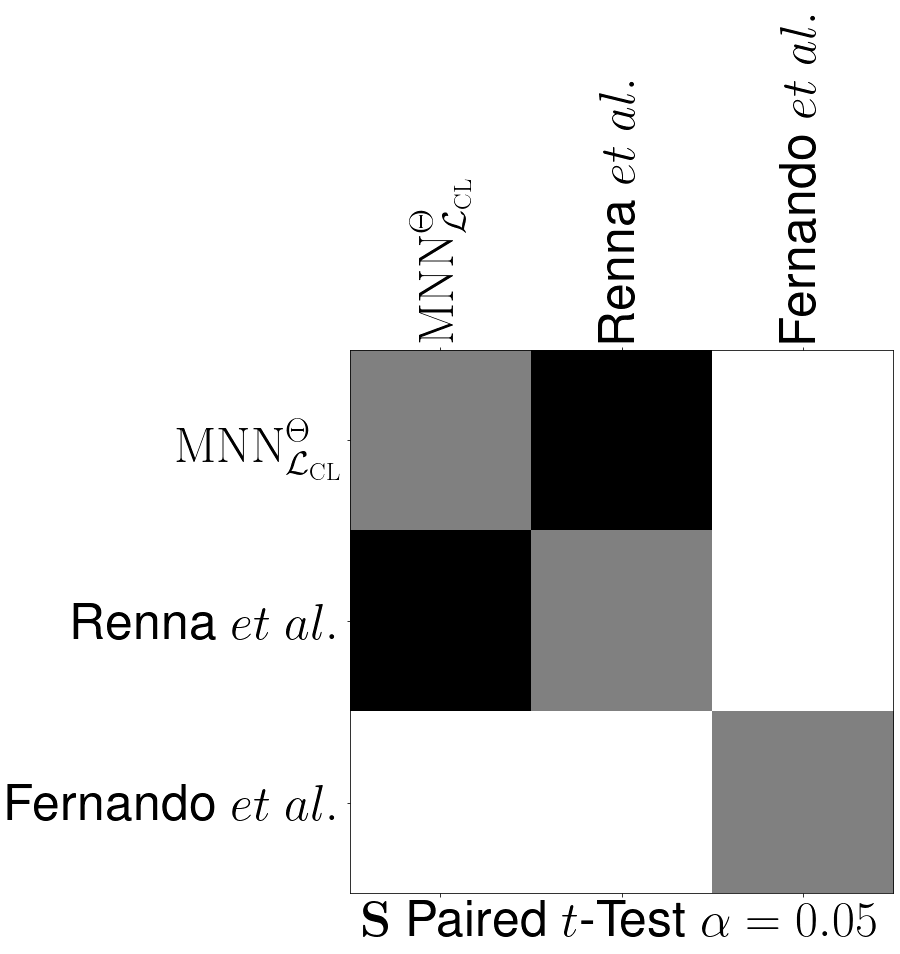

In [607]:
pairs_sens, t_stats_sens, mat_sens = paired_t_test_statistics(sens)
ticks = [ '$\mathrm{MNN}^\Theta_{\mathcal{L}_\mathrm{CL}}$', 'Renna $et$ $al.$', 'Fernando $et$ $al.$']
plot_t_test_matrix(mat_sens, ticks, '$\mathbf{S}$')

# Transfer

In [173]:
# unet_ph16_circor = metrics_model('results/rerun/unet/unet_transfer_ph16_circor/2022-09-28_09_38_17')
# unet_ph16_circor = metrics_model('results/rerun/unet/unet_transfer_ph16_circor/2022-09-28_14_45_49')
unet_ph16_circor = metrics_model('results/rerun/unet/unet_transfer_ph16_circor/2022-09-29_14_42_54')
hmm_ph16_circor = metrics_model('results/rerun/hybrid/hmm_cl_ph16_circor/2022-09-29_10_51_18')
fernando_ph16_circor = metrics_model('results/rerun/fernando/fernando_ph16_circor/2022-09-29_11_20_39')
hmm_ft = metrics_model('results/rerun/hybrid/hmm_finetune_ph16_circor/2022-09-30_12:06:09')
ft2 = metrics_model('results/rerun/hybrid/hmm_finetune_ph16_circor/2022-10-01_18:28:45')


In [174]:
ft3 = metrics_model('results/rerun/hybrid/hmm_finetune_ph16_circor/2022-10-01_19_40_08')  # 100 1e-3
ft4 = metrics_model('results/rerun/hybrid/hmm_finetune_ph16_circor/2022-10-03_10_11_12') # 50 1e-3
ft5 = metrics_model('results/rerun/hybrid/hmm_finetune_ph16_circor/2022-10-03_14_48_32') # 1 1e-3
ft6 = metrics_model('results/rerun/hybrid/hmm_finetune_ph16_circor/2022-10-03_15_03_07')

In [ ]:
# maybe try hmm parameters only`Ωaqwassºsºss



In [ ]:
!ls results/rerun/hybrid/hmm_finetune_ph16_circor/2022-09-30_12:06:09
sio.loadmat('results/rerun/hybrid/hmm_finetune_ph16_circor/2022-09-30_12:06:09/trans_mat.mat')

Text(0.5, 1.0, 'PPV Physionet->Circor')

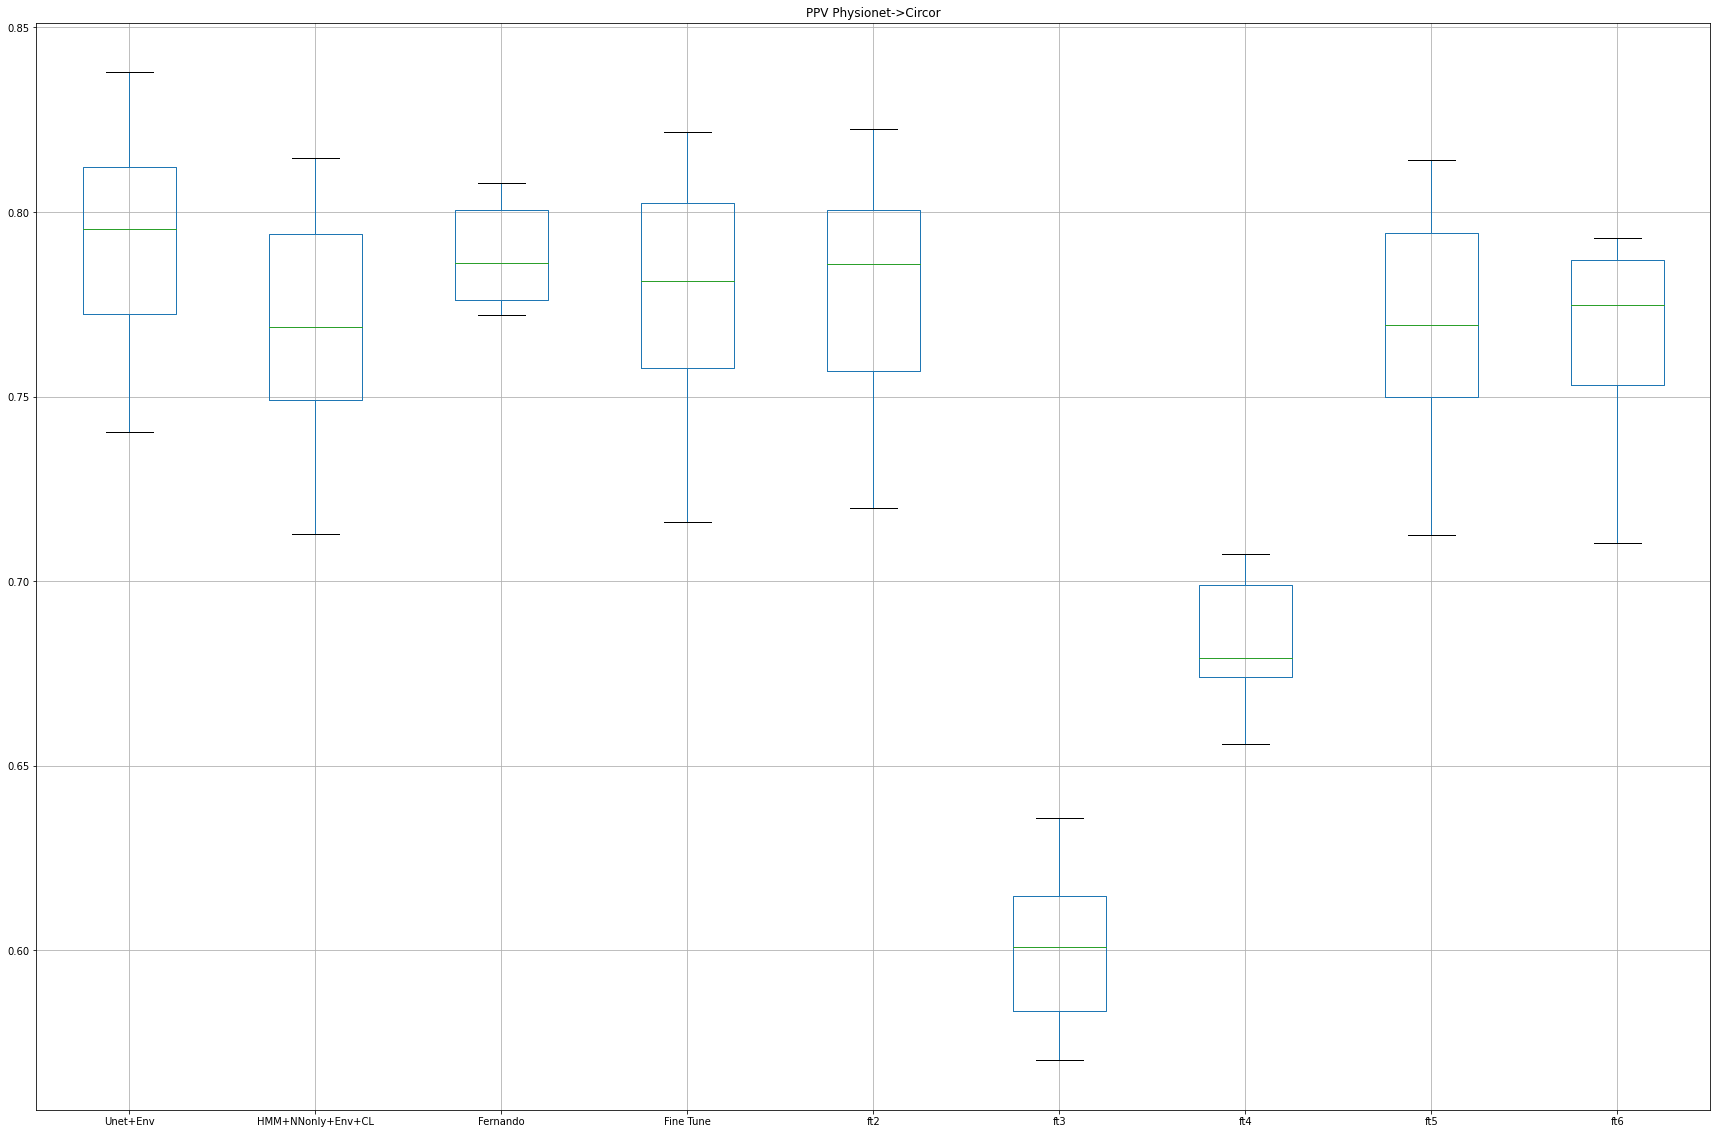

In [76]:
df = pd.DataFrame({'Unet+Env': unet_ph16_circor[1],
                   'HMM+NNonly+Env+CL': hmm_ph16_circor[1],
                   'Fernando': fernando_ph16_circor[1],
                   'Fine Tune': hmm_ft[1],  # 10 epochs 1e-3,
                   'ft2': ft2[1],
                   'ft3': ft3[1],
                   'ft4': ft4[1],
                   'ft5': ft5[1],
                   'ft6': ft6[1]
                   }) # no grads CL, no grads MMI,  CL envelogram, corrected fernando
boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('PPV Physionet->Circor')


Text(0.5, 1.0, 'Sensivity Physionet->Circor')

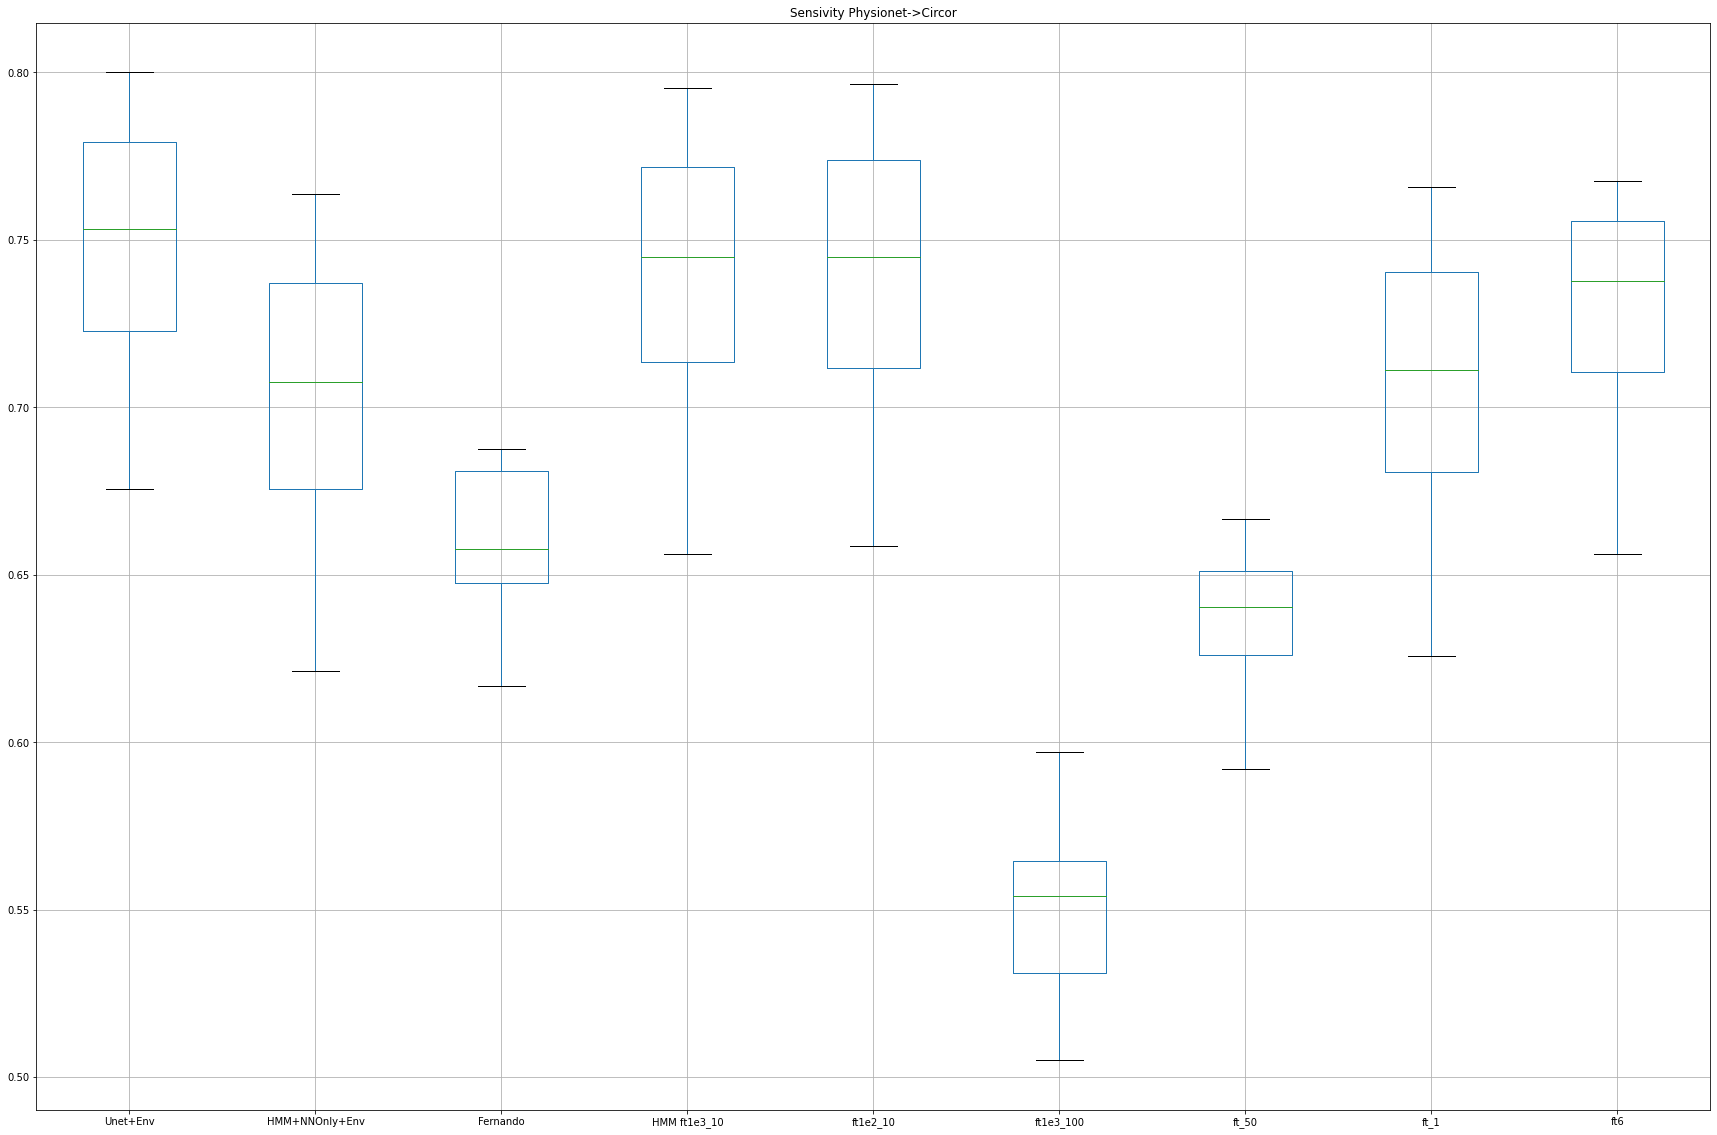

In [77]:
df = pd.DataFrame({'Unet+Env': unet_ph16_circor[2],
                   'HMM+NNOnly+Env': hmm_ph16_circor[2],
                   'Fernando': fernando_ph16_circor[2],
                   'HMM ft1e3_10': hmm_ft[2],
                   'ft1e2_10': ft2[2],
                   'ft1e3_100': ft3[2],
                   'ft_50': ft4[2],
                   'ft_1': ft5[2],
                   'ft6': ft6[2]
                   }) # no grads CL, no grads MMI,  CL envelogram, corrected fernando
boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('Sensivity Physionet->Circor')

In [ ]:
np.std(ft2[1])

In [ ]:
df = pd.DataFrame({'UNET_CE_viterbi+Envelogram': ph16_crosse_unet_env[1],
                   'TrueHybridHMM+Envelogram': ph16_true_hybrid_cnn_env[1],
                   'CompleteHybridMMI+Envelogram': ph16_completemmi_hybrid_cnn_env[1],
                   'CompleteLikelihood+Envelogram':ph16_completelikelihood_hybrid_cnn_env[1],
                   # 'NoGradsCL+Envelogram': ph16_completelikelihood_nograds_cnn_env[0], 
                   'CompleteLikelihood+PSD': ph16_completelikelihood_hybrid_cnn_psd[1],
                   'NoGradsCL+PSD': ph16_completelikelihood_cnngrads_psd[1],
                   'CompleteLikelihood+MFCC': ph16_completelikelihood_hybrid_cnn_mfcc[1],
                   'Fernando et al.': ph16_fernado_mfcc_joint[1],
                   }) # no grads CL, no grads MMI,  CL envelogram, corrected fernando
    
# fine tune best HMM
# transfer u-net, fernando and springer

boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('PPV Physionet\'2016 challenge')
plt.show()

In [ ]:
df = pd.DataFrame({'UNET_CE_viterbi+Envelogram': ph16_crosse_unet_env[2],
                   'TrueHybridHMM+Envelogram': ph16_true_hybrid_cnn_env[2],
                   'CompleteHybridMMI+Envelogram': ph16_completemmi_hybrid_cnn_env[2],
                   'CompleteLikelihood+Envelogram':ph16_completelikelihood_hybrid_cnn_env[2],
                   # 'NoGradsCL+Envelogram': ph16_completelikelihood_nograds_cnn_env[0], 
                   'CompleteLikelihood+PSD': ph16_completelikelihood_hybrid_cnn_psd[2],
                   'NoGradsCL+PSD': ph16_completelikelihood_cnngrads_psd[2],
                   'CompleteLikelihood+MFCC': ph16_completelikelihood_hybrid_cnn_mfcc[2],
                   'Fernando et al.': ph16_fernado_mfcc_joint[2],
                   }) # no grads CL, no grads MMI,  CL envelogram, corrected fernando
    
# fine tune best HMM
# transfer u-net, fernando and springer

boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('Accuracy Physionet\'2016 challenge')
plt.show()

In [ ]:
df = pd.DataFrame({'UNET_CE_viterbi+Envelogram': ph16_crosse_unet_env[2],
                   'HybridGradients+Envelogram': ph16_hybrid_cnn_env[2],
                   'HybridGradients+PSD': ph16_hybrid_cnn_psd[2],
                   'TrueHybridHMM+Envelogram': ph16_true_hybrid_cnn_env[2],
                   'CompleteHybridMMI+Envelogram': ph16_completemmi_hybrid_cnn_env[2],
                   'CompleteLikelihood+Envelogram':ph16_completelikelihood_hybrid_cnn_env[2],
                   'NoGradsCL+Envelogram': ph16_completelikelihood_nograds_cnn_env[2], 
                   'CompleteLikelihood+PSD': ph16_completelikelihood_hybrid_cnn_psd[2],
                   'NoGradsCL+PSD': ph16_completelikelihood_cnngrads_psd[2],
                   'FtHMMCL+PSD20': ph16_psd_fine_tune_hmm20[2],
                   'CompleteLikelihood+MFCC': ph16_completelikelihood_hybrid_cnn_mfcc[2],
                   'Fernando et al.': ph16_fernado_mfcc_joint[1],
                   })

boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('Sensitivity Physionet\'2016 challenge')
plt.show()

In [ ]:
!ls results/hybrid/hmm_completlikelihood1e3_physio16_envelops_joint/2022-03-20_12:55:33

In [ ]:
!ls results/unet/unet/2022-02-26_07:49:39

In [48]:
x =  np.array([[0.2, 0.5, .3], [0.2, 0.5, .3], [0.2, 0.5, .3]])

y =  np.array([[0.2, 0.5, .3], [1., 1., 1.], [0.2, 0.5, .3]])


distance(x, y)

array([0.        , 1.72406351, 0.        ])

In [ ]:
ph16_psd_fine_tune[0]

In [ ]:
ph16_psd_fine_tune2[0]

In [ ]:
ph16_psd_ft_hmm_cnn[2]

In [ ]:
np.sum(ph16_psd_ft_hmm_cnn[1]) / 8

In [ ]:
[1, 2, 3, 4] + [5]

In [172]:
df = pd.DataFrame({'UNET_CE_viterbi+Envelogram': ph16_crosse_unet_env[1],
                   'HybridGradients+Envelogram': ph16_hybrid_cnn_env[1],
                   'HybridGradients+PSD': ph16_hybrid_cnn_psd[1],
                   'TrueHybridHMM+Envelogram': ph16_true_hybrid_cnn_env[1],
                   'CompleteHybridMMI+Envelogram': ph16_completemmi_hybrid_cnn_env[1],
                   'CompleteLikelihood+Envelogram':ph16_completelikelihood_hybrid_cnn_env[1],
                   'NoGradsCL+Envelogram': ph16_completelikelihood_nograds_cnn_env[1], 
                   'CompleteLikelihood+PSD': ph16_completelikelihood_hybrid_cnn_psd[1],
                   'NoGradsCL+PSD': ph16_completelikelihood_cnngrads_psd[1],
                   'FtHMMCL+PSD20': ph16_psd_fine_tune_hmm20[1],
                   'CompleteLikelihood+MFCC': ph16_completelikelihood_hybrid_cnn_mfcc[1],
                   'NoGradsCL+PSD': ph16_completelikelihood_nograds_cnn_psd[1], 
                   'Fernando et al.': ph16_fernado_mfcc_joint[1],
                   })

boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('PPV Physionet\'2016 challenge')
plt.show()

NameError: name 'ph16_crosse_unet_env' is not defined

In [ ]:
!ls results/rerun/circor/hmm_range_1_100_finetune_pretained_ph16_circor20/2022-10-07_16_31_41


In [ ]:
f = h5py.File('results/rerun/circor/hmm_range_1_100_finetune_pretained_ph16_circor20/2022-10-07_16_31_41/results.hdf5', 'r')

In [ ]:
attributes_fold = list(f['fold0/data/'].attrs.keys())

In [ ]:
sorted(gt_fold, key=lambda x: int(re.search('\d+',x).group()))

In [ ]:




preds_fold

In [ ]:
p = [x for x in preds_fold  if int(re.findall('\d+', x)[-1]) == 10]
p

In [ ]:
f['/fold0/data/'].attrs['gt_0']

In [ ]:
f['/fold0/data/'].attrs['preds0_10'], f['/fold0/data/'].attrs['preds0_40']

In [ ]:
re.findall('\d+', 'preds200_10')[-1]

In [10]:
import h5py
import re
from tqdm import tqdm

def get_attribute_names(fold_ptr, fold):
    attributes_fold = list(fold_ptr.attrs.keys())
    gt_fold = [x for x in attributes_fold if x.startswith('gt')]
    preds_fold = [x for x in attributes_fold if x.startswith('preds')]
    gt_fold = sorted(gt_fold, key=lambda x: int(re.search('\d+',x).group()))
    preds_fold = sorted(preds_fold, key=lambda x: 
                        (50 * int(re.findall('\d+', x)[0])) + int(re.findall('\d+', x)[-1]))
    return gt_fold, preds_fold

def process_hdf5(filename, number_folds=10, nreps=50):
    f = h5py.File(filename, 'r')
    fold_gt, fold_preds, fold_ppv, fold_sens = [], [], [], []
    for fold in range(number_folds):
        fold_data = f[f'fold{fold}/data/']
        gts, preds = get_attribute_names(fold_data, fold)
        obs_gt, obs_preds, obs_ppv, obs_sens = [], [], [], []
        for idx, gt_name in tqdm(enumerate(gts)):
            start = idx * nreps
            predictions, ft_ppv, ft_sens = [], [], []
            gt = fold_data.attrs[gt_name]
            obs_gt.append(gt)
            for i in range(nreps):
                pred = fold_data.attrs[preds[start + i]]
                predictions.append(pred)
                ppv_, sensitivity_ = schmidt_metrics(gt, pred)
                ft_ppv.append(ppv_)
                ft_sens.append(sensitivity_)
            obs_preds.append(predictions)
            obs_ppv.append(ft_ppv)
            obs_sens.append(ft_sens)
        fold_ppv.append(obs_ppv)
        fold_preds.append(obs_preds)
        fold_sens.append(obs_sens)
        fold_gt.append(obs_gt)
    return fold_gt, fold_preds, fold_ppv, fold_sens

In [11]:
# Fine-tune 

directory = 'results/rerun/hybrid/fine_tune/results(1).hdf5'
f = h5py.File(directory, 'r')

In [12]:
gt, preds, ppv, sens = process_hdf5(directory)


327it [00:29, 11.20it/s]
327it [00:30, 10.70it/s]
327it [00:35,  9.22it/s]
327it [00:48,  6.79it/s]
327it [00:32, 10.16it/s]
327it [00:26, 12.14it/s]
327it [00:28, 11.44it/s]
327it [00:33,  9.70it/s]
327it [00:31, 10.49it/s]
327it [00:29, 11.25it/s]


In [13]:
gt, preds, ppv, sens = np.array(gt), np.array(preds), np.array(ppv), np.array(sens) 

<ipython-input-13-15545ecc00a9>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gt, preds, ppv, sens = np.array(gt), np.array(preds), np.array(ppv), np.array(sens)


In [54]:
gt.shape, preds.shape, ppv.shape, sens.shape

((10, 327), (10, 327, 50), (10, 327, 50), (10, 327, 50))

In [48]:
gt.shape

(10, 327)

(50,) (50,)


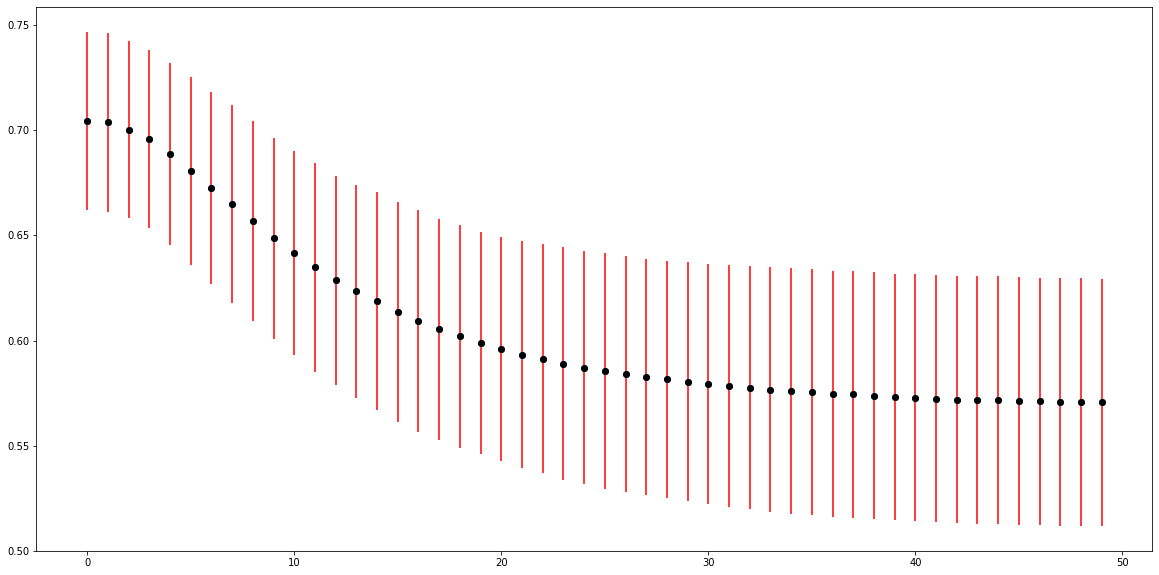

In [328]:
plot_fine_tune(sens)

(50,) (50,)


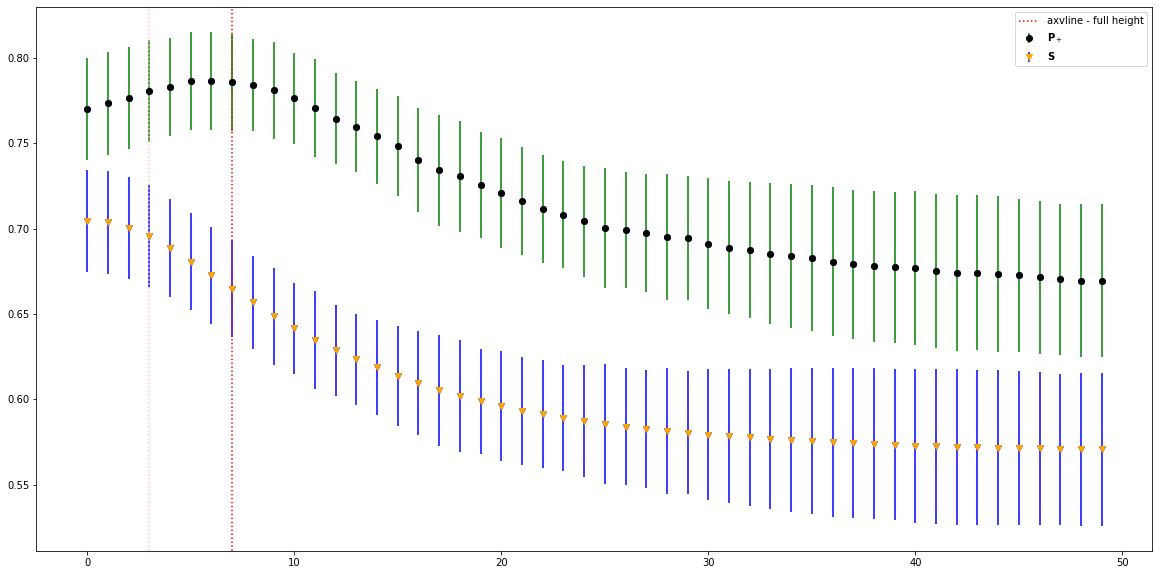

In [323]:
ppv, sens = np.array(ppv), np.array(sens) 
def plot_fine_tune_both(results, results2, num_epochs=50):
    y = np.mean(np.mean(results, axis=1), axis=0)
    y_error = np.std(np.mean(results, axis=1), axis=0)
    
    y_2 = np.mean(np.mean(results2, axis=1), axis=0)
    y_error_2 = np.std(np.mean(results2, axis=1), axis=0)
    print(y.shape, y_error.shape)
    x = [i for i in range(num_epochs)]
    plt.scatter(x, y)
    plt.errorbar(x, y, yerr = y_error,fmt='o',ecolor = 'green',color='black', label='$\mathbf{P}_+$')
    
    plt.scatter(x, y_2, color='blue', marker='v')
    plt.errorbar(x, y_2, yerr = y_error,fmt='v',ecolor = 'blue',color='orange',  label='$\mathbf{S}$')
    
    plt.axvline(x = 3, color = 'pink', linestyle='dotted')
    plt.axvline(x = 7, color = 'red', linestyle='dotted', label = 'axvline - full height')
    plt.legend()
    plt.show()
    

plot_fine_tune_both(ppv, sens, 50)
# plt.savefig(f'{metric_name}.png', dpi=1200, bbox_inches='tight',)

(50,) (50,)


Ttest_relResult(statistic=-16.16506374594127, pvalue=5.8816384060845975e-08)

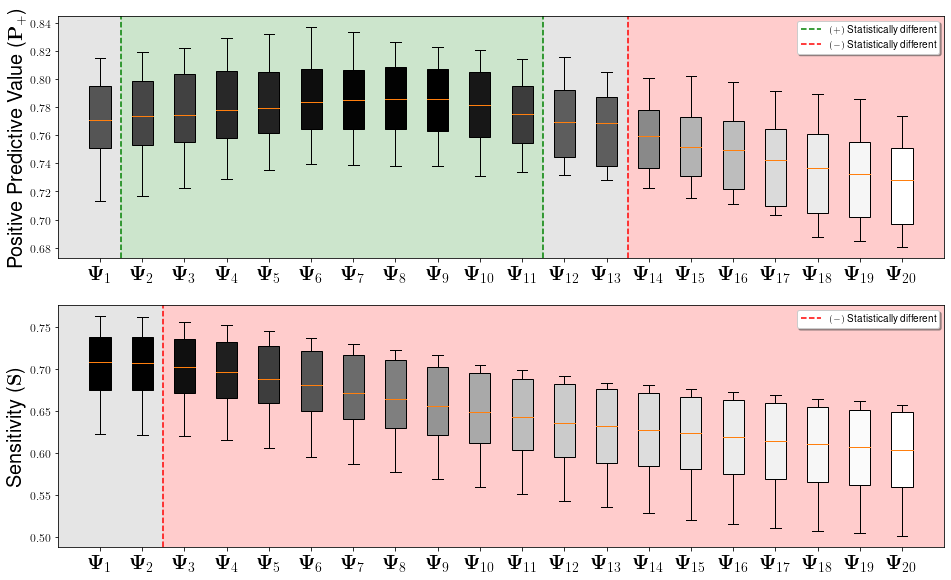

In [464]:
def best_diff(results, results2, num_epochs=50):
    y = np.mean(np.mean(results, axis=1), axis=0)
    y_error = np.std(np.mean(results, axis=1), axis=0)
    
    y_2 = np.mean(np.mean(results2, axis=1), axis=0)
    y_error_2 = np.std(np.mean(results2, axis=1), axis=0)
    
    print((y-y_error) - (y_2+y_error_2))
    print((2*y*y_2/(y+y_2))) 

import matplotlib.cm as cm

def plot_violins(results, results2, num_epochs=50):
    plt.rcParams["figure.figsize"] = (20,12)
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=12) 
    plt.rc('axes', labelsize=SMALL_SIZE)# fontsize of the tick labels
    plt.rc('legend', fontsize=10)
    plt.rc('font', size=SMALL_SIZE)
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
        })
    y = np.mean(np.mean(results, axis=1), axis=0)
    y_error = np.std(np.mean(results, axis=1), axis=0)
    
    y_2 = np.mean(np.mean(results2, axis=1), axis=0)
    y_error_2 = np.std(np.mean(results2, axis=1), axis=0)
    print(y.shape, y_error.shape)
    x = [i for i in range(num_epochs)]
    
    plot1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    #plot3 = plt.subplot2grid((3, 3), (0, 2), rowspan=2, colspan=2)
    plot2 = plt.subplot2grid((3, 3), (1, 0), colspan=2)
    #plt.subplot(3, 1, 1) 
    fig = plot1.boxplot(fold_ppv[:, :20], patch_artist=True)
    #t11 = [''] + [f'{i}' for i in range(20)]
    #plot1.set_xlim(0, 10)
    #fig.ylim(0, 10)
    #plot1.set_ylim(np.min(np.median(fold_ppv, axis=1)), np.max(np.median(fold_ppv, axis=1)), 10)
   

    

    #plot1.set_xticks(range(len(t11)), t11, size='medium')
    # Fill with colors
    cmap = cm.ScalarMappable(cmap='Greys')
    #print(dir(plot1.axes['boxes']))
    test_mean = np.median(fold_ppv[:, :20],axis=0)
    for patch, color in zip(fig['boxes'], cmap.to_rgba(test_mean)):
        patch.set_facecolor(color)
    np.zeros
    #plt.subplot(3, 1, 2) 
    
    fig2 = plot2.boxplot(fold_sens[:, :20], patch_artist=True)
    
    cmap = cm.ScalarMappable(cmap='Greys')
    #print(dir(plot1.axes['boxes']))
    test_mean = np.median(fold_sens[:, :20],axis=0)
    for patch, color in zip(fig2['boxes'], cmap.to_rgba(test_mean)):
        patch.set_facecolor(color)
    
    #plt.subplot(3, 1, 3)
    plot1.set_xticks(np.arange(1, 21), [r'$\mathbf{\Psi}_{%d}$' % x for x in range(1,21)])
    plot2.set_xticks(np.arange(1, 21), [r'$\mathbf{\Psi}_{%d}$' % x for x in range(1,21)])
    
    plot1.axvline(x = 1.5, color = 'green', linestyle='dashed')
    plot1.axvline(x = 11.5, color = 'green', linestyle='dashed', label=r'$(+)$ Statistically different')
    plot1.axvline(x = 13.5, color = 'red', linestyle='dashed', label=r'$(-)$ Statistically different')
    plot1.axvline(x = 43.5, color = 'red', alpha=0.2)
    plot2.axvline(x = 2.5, color = 'red', linestyle='dashed',label=r'$(-)$ Statistically different') # make line invisible
    
    
    plot1.set_xlim(0, 21)
    plot1.axvspan(0., 1.5, facecolor='gray', alpha=.2)
    plot1.axvspan(1.5, 11.5, facecolor='green', alpha=.2)
    plot1.axvspan(11.5, 13.5, facecolor='gray', alpha=.2)
    plot1.axvspan(13.5, 21, facecolor='red', alpha=.2)
    plot2.set_xlim(0, 21)
    plot2.axvspan(0.0, 2.5, facecolor='gray', alpha=.2)
    plot2.axvspan(2.5, 21, facecolor='red', alpha=.2) 
    #plot1.set_xlabel(r'$\mathbf{\Psi}_{k}$' + r' after $k$ epochs')
    #plot2.set_xlabel(r'$\mathbf{\Psi}_{k}$'+ r' after $k$ epochs')
    plot1.set_ylabel(r'Positive Predictive Value ($\mathbf{P}_+$)')
    plot2.set_ylabel(r'Sensitivity ($\mathbf{S}$)')

    plot1.legend(shadow=True)
    plot2.legend(shadow=True)
    plt.tight_layout()
    plt.plot()
    plt.savefig('fine_tune_final.png', dpi=600, bbox_inches='tight')

fold_ppv, fold_sens = np.mean(ppv, axis=1), np.mean(sens, axis=1)
plot_violins(ppv, sens, 50)
#


baseline_ppv, baseline_sens = fold_ppv[:, 0], fold_sens[:, 0]

#compute_pair_test(fold_ppv[:, 8], np.array(unet_ph16_circor[1])[np.newaxis, ...]), compute_pair_test(baseline_sens, fold_sens)
stats.ttest_rel(fold_sens[:, 8], fold_sens[:, 0])

In [22]:
circor_folds_idx = sio.loadmat('results/rerun/hybrid/fine_tune/test_indexes.mat')['test_indexes']

In [73]:
features[test_indices[254]].shape


(1545, 4)

In [33]:
from data_processing.signal_extraction import *
fold_ppv = np.mean(ppv, axis=1)
fold_sens = np.mean(sens, axis=1)
def compute_pair_test(baseline, models, alpha=0.05):
    print(baseline, models[:,2])
    
    paired_t_tests = [stats.ttest_rel(baseline, models[:, i]) for i in range(0, models.shape[1])]
    return [(1, i+1) if (p_v:= pair.pvalue) <= alpha else (0,i+1) for i, pair in enumerate(paired_t_tests)]


baseline_ppv  = fold_ppv[:, 0]
baseline_sens = fold_sens[:, 0]
compute_pair_test(baseline_sens, fold_sens)
from data_processing.data_transformation import HybridPCGDataPreparer, prepare_validation_data, get_train_test_indices
train_indices, test_indices = get_train_test_indices(good_indices=good_indices,
                                                             number_folders=10,
                                                             patient_ids=patient_ids,
                                                             fold=1)
dataset = DataExtractor.extract_circor_raw('datasets/PCG/circor_final/training_data/', extension='tsv')
sample =dataset [dataset[ :, 0] == patient_ids[test_indices[254]]]
sample_1 = DataExtractor.resample_signal([sample[1][1]], 4000, 50)

Skipping 50782_MV_1.wav	No label file.


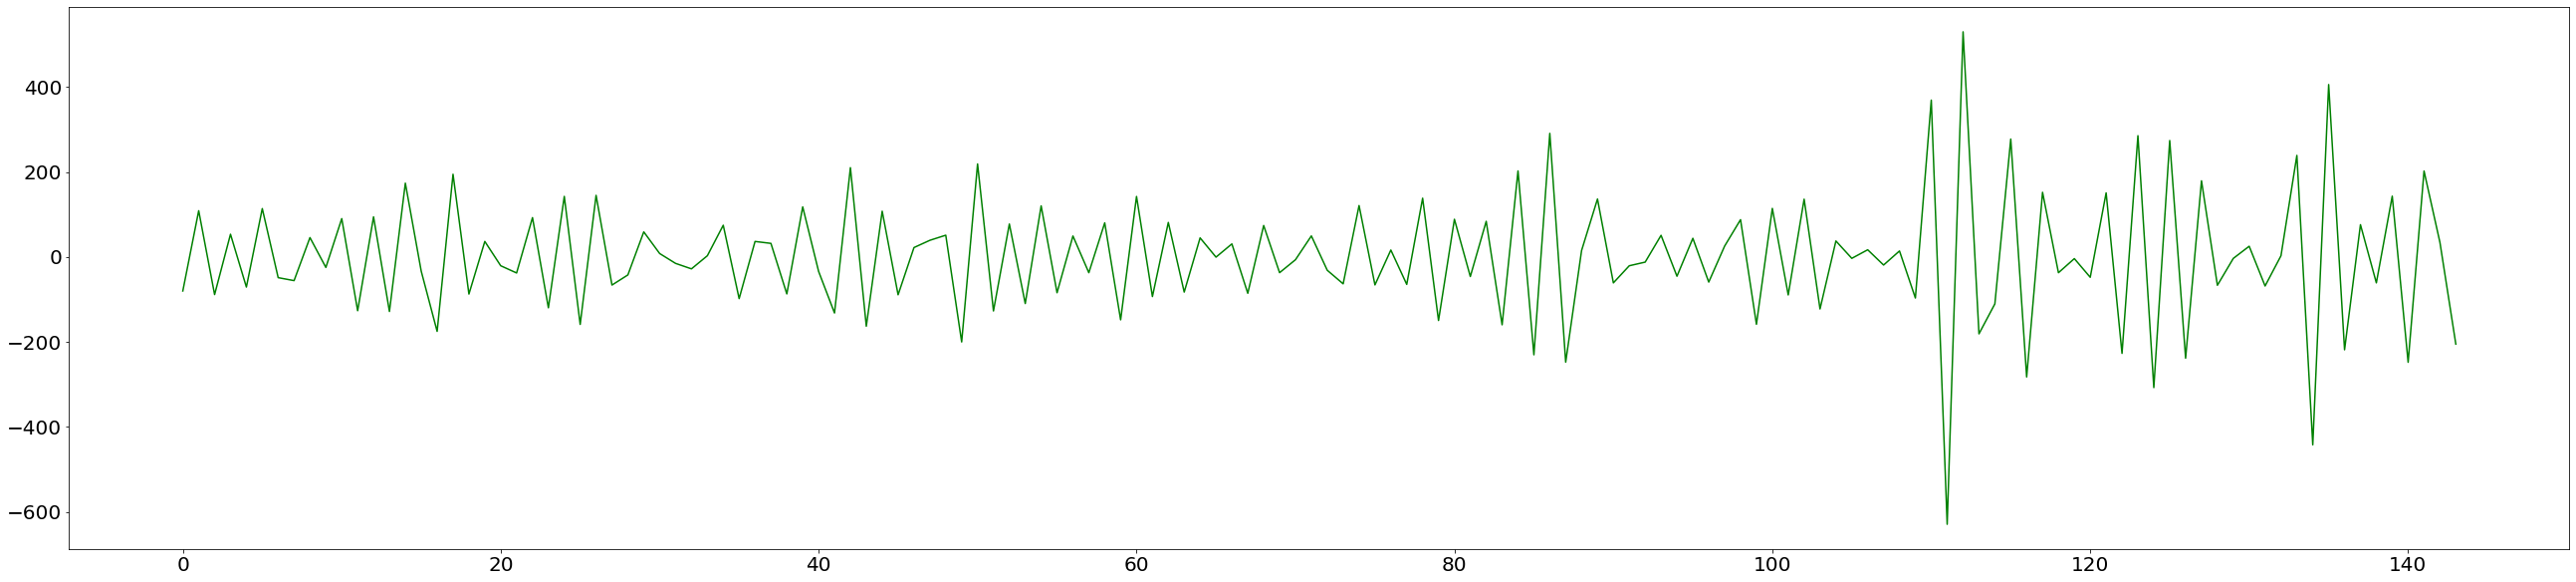

In [126]:
import scipy.signal
sample_1 = np.squeeze(sample_1)
norm_1 = (sample_1 - np.mean(sample_1)) / np.std(sample_1)
plt.plot(sample_1[1400:], color="green")


320:321
880:881
1280:1281


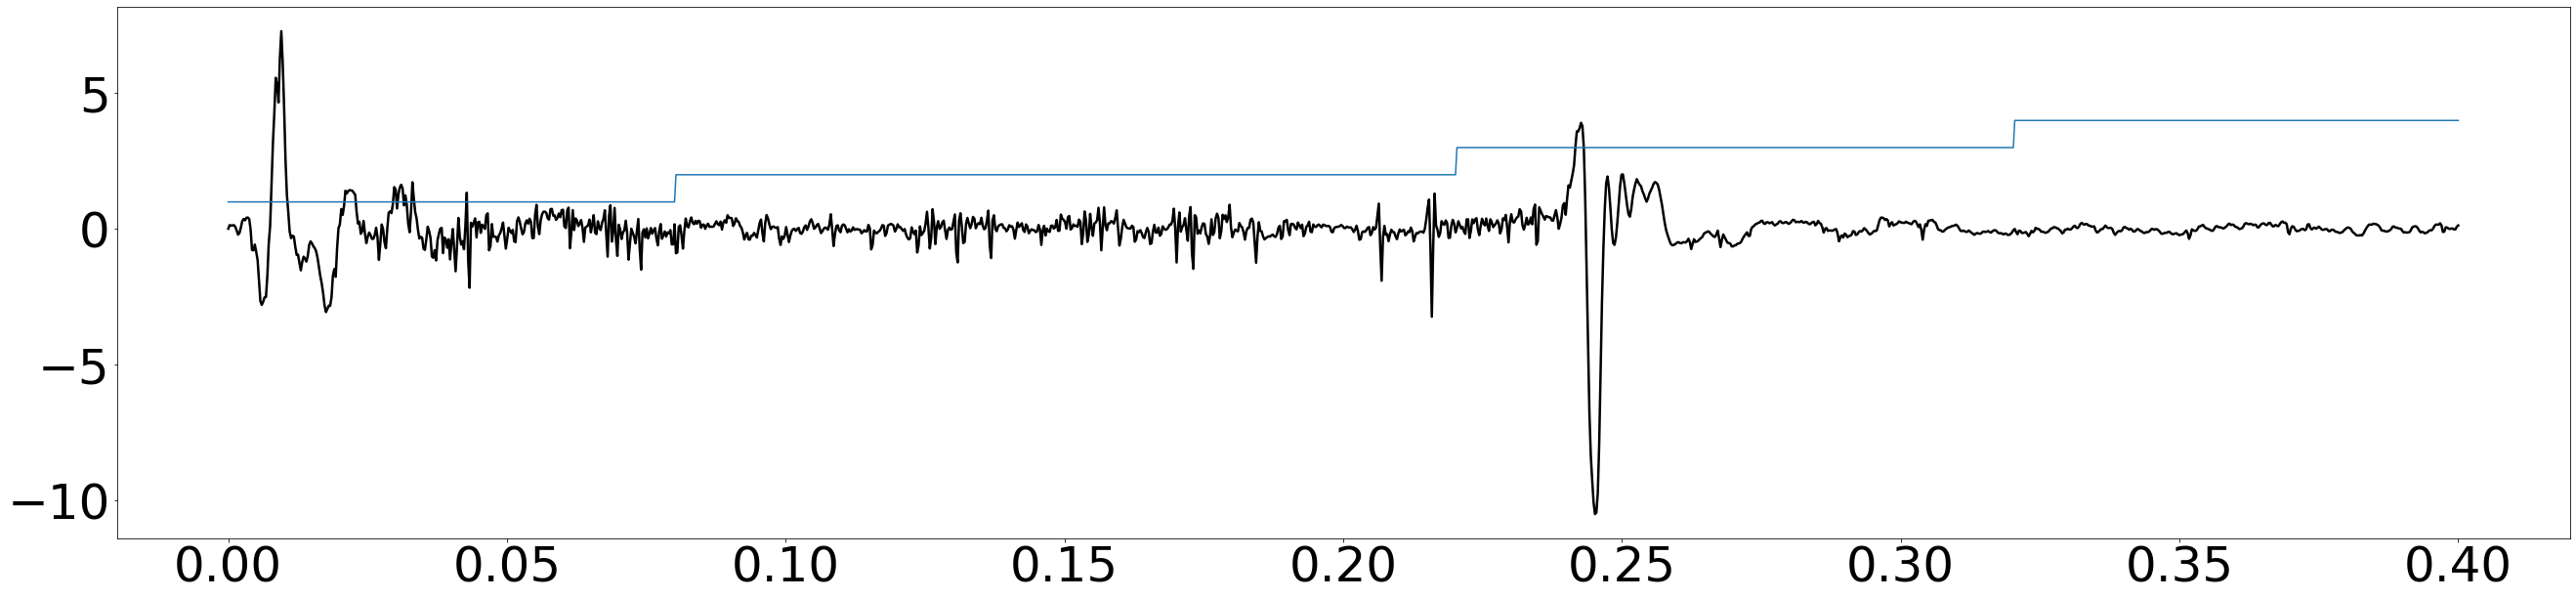

In [226]:
for i in range(1,len(l:=sample[1][2][a:b])):
    if l[i-1] != l[i]:
        print(f"{i-1}:{i}")
        
1281+ ((1600 - 1281) / 2)


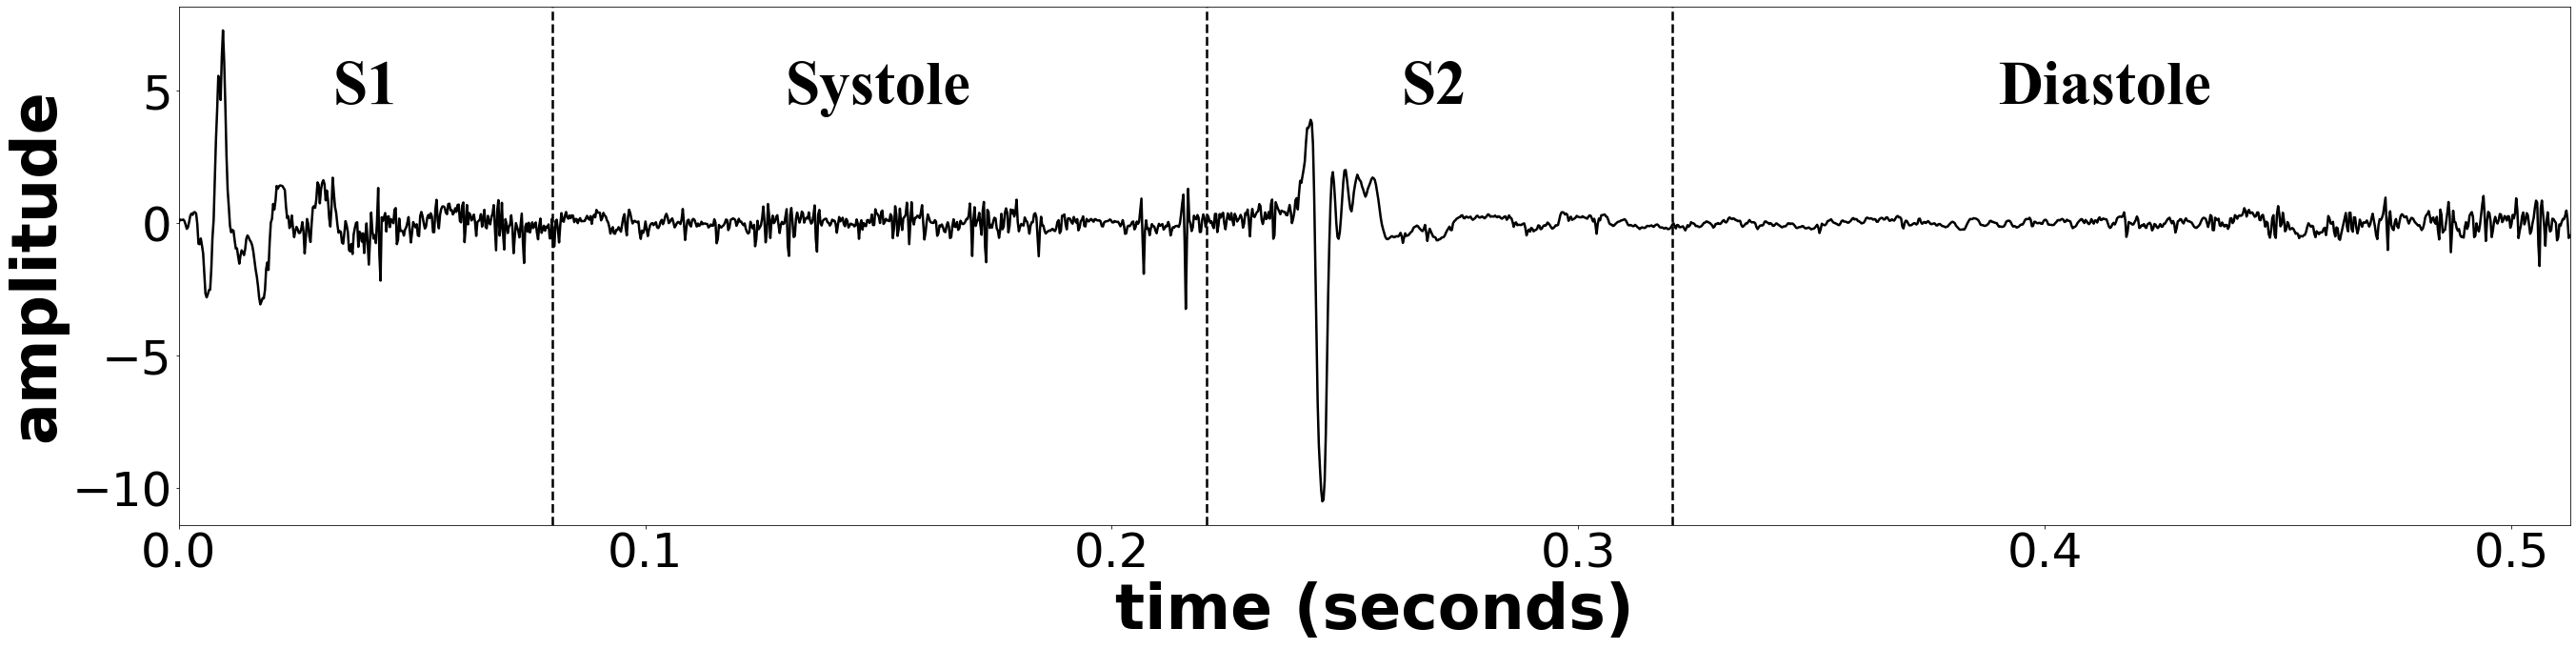

In [415]:
a,b = 2400, 4450

norm_original = (sample[1][1] - np.mean(sample[1][1])) / np.std(sample[1][1])
#plt.plot(norm_original[a:b], color='black', linewidth=2.5)
A = np.linspace(0, 0.5125, 2050)
plt.plot(A, norm_original[a:b], color='black', linewidth=2.5)
#plt.plot(A, sample[1][2][a:b])
plt.axvline(x = 0.08, color = 'black', linestyle='dashed', linewidth=2.5)
plt.axvline(x = 0.2203, color = 'black', linestyle='dashed', linewidth=2.5)
plt.axvline(x = 0.32005, color = 'black', linestyle='dashed', linewidth=2.5)
font = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'bold',
        'size': 65,
        }
plt.text(x=0.033, y=4.5, s='S1', fontdict=font)
plt.text(x=0.130, y=4.5, s='Systole', fontdict=font)
plt.text(x=0.262, y=4.5, s='S2', fontdict=font)
plt.text(x=0.39, y=4.5, s='Diastole', fontdict=font)
plt.xlim((0,0.5125))

plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE) 
plt.rc('axes', labelsize=MEDIUM_SIZE)# fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('font', size=SMALL_SIZE) 
plt.xlabel('time (seconds)', **{'weight':'bold', 'size': 65})
plt.ylabel('amplitude', **{'weight':'bold', 'size': 65})
plt.savefig('PCG_example.png', dpi=400, bbox_inches='tight')
#plt.tight_layout()

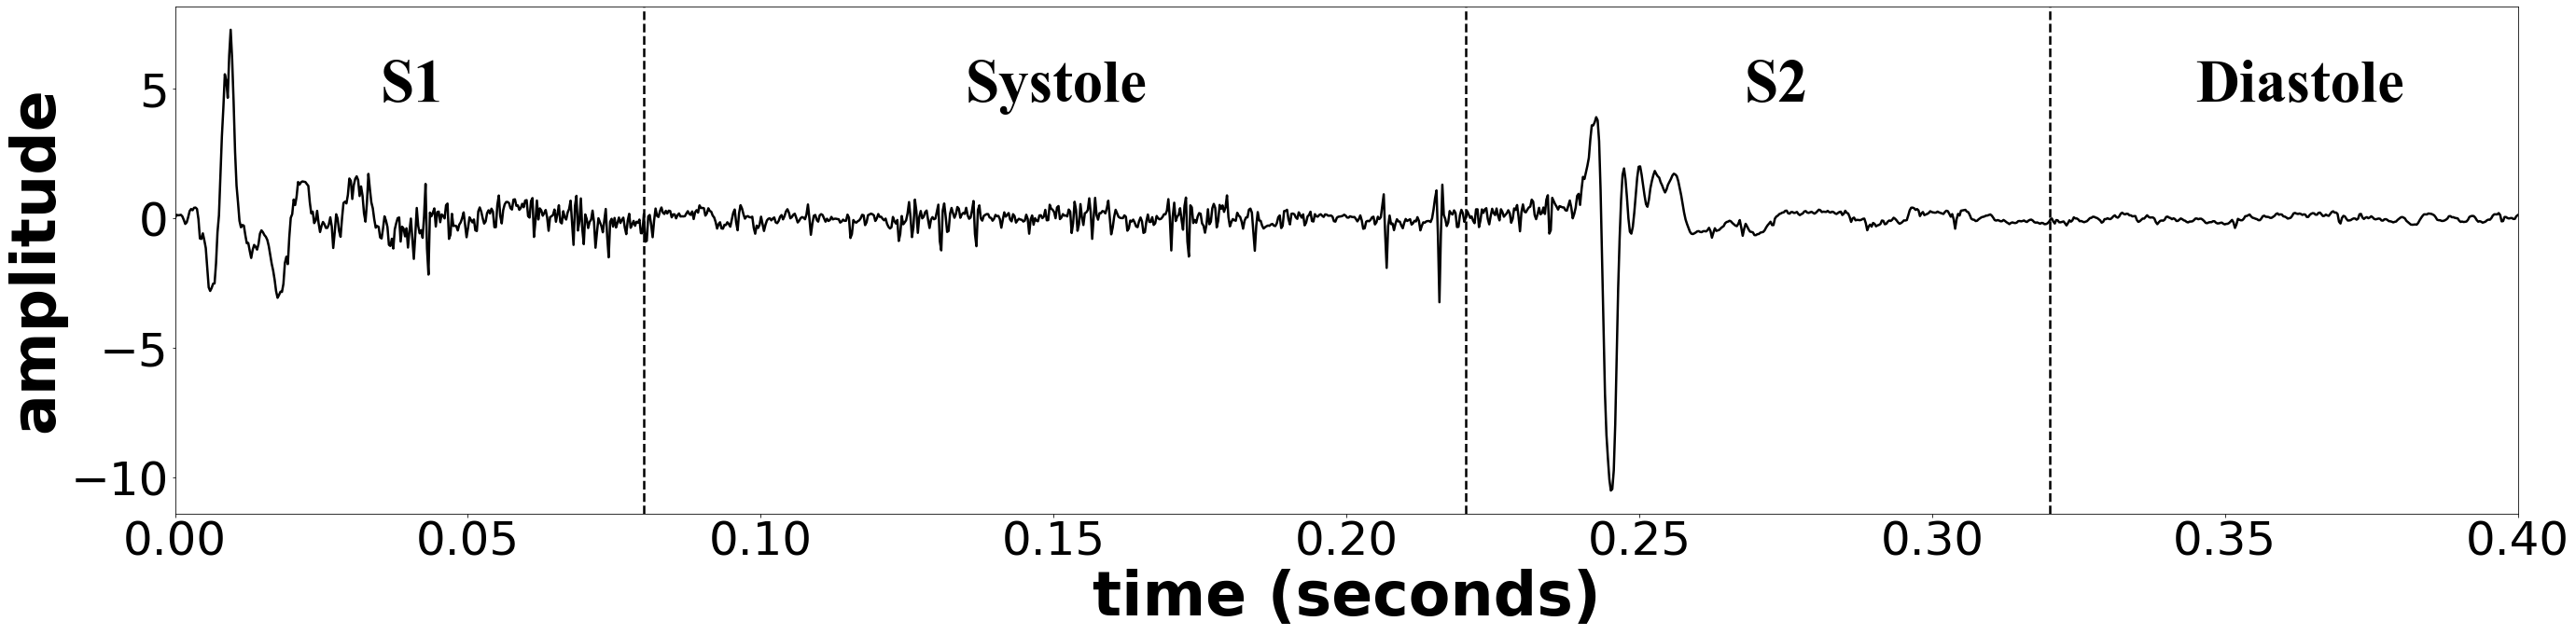

In [297]:
a,b = 2400, 4000

norm_original = (sample[1][1] - np.mean(sample[1][1])) / np.std(sample[1][1])
#plt.plot(norm_original[a:b], color='black', linewidth=2.5)
A = np.linspace(0, 0.4, 1600)
plt.plot(A, norm_original[a:b], color='black', linewidth=2.5)
#plt.plot(A, sample[1][2][a:b])
plt.axvline(x = 0.08, color = 'black', linestyle='dashed', linewidth=2.5)
plt.axvline(x = 0.2203, color = 'black', linestyle='dashed', linewidth=2.5)
plt.axvline(x = 0.32005, color = 'black', linestyle='dashed', linewidth=2.5)
font = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'bold',
        'size': 65,
        }
plt.text(x=0.035, y=4.5, s='S1', fontdict=font)
plt.text(x=0.135, y=4.5, s='Systole', fontdict=font)
plt.text(x=0.268, y=4.5, s='S2', fontdict=font)
plt.text(x=0.345, y=4.5, s='Diastole', fontdict=font)
plt.xlim((0,0.4))

plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE) 
plt.rc('axes', labelsize=MEDIUM_SIZE)# fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('font', size=SMALL_SIZE) 
plt.xlabel('time (seconds)', **{'weight':'bold', 'size': 65})
plt.ylabel('amplitude', **{'weight':'bold', 'size': 65})
plt.savefig('PCG_example.png', dpi=400, bbox_inches='tight')
#plt.tight_layout()

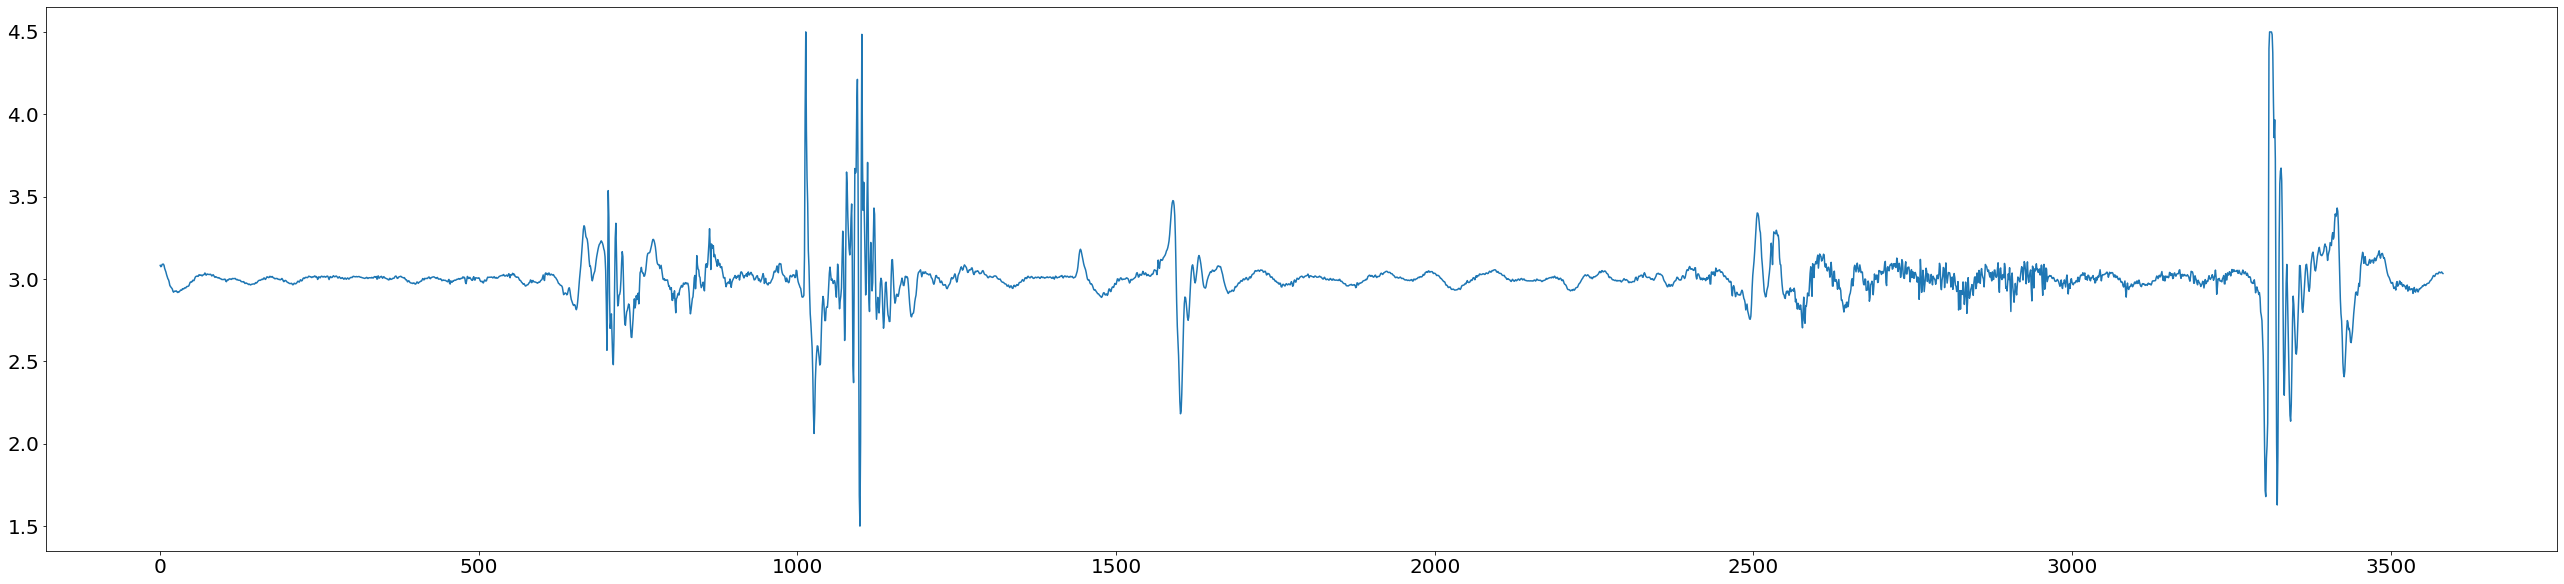

In [374]:
sig = sample[1][1]
norm_original = ((sample[1][1] - np.mean(sample[1][1])) / np.std(sample[1][1])) 
norm_standardized = (sig - np.min(sig)+1.5) / ((np.max(sig)+4.5) - np.min(sig)+1.5)



# newvalue= (1)/(np.max(norm_original) - np.min(norm_original))*(norm_original-np.max(norm_original))+np.max(norm_original)
plt.plot(norm_2[120000:128000])

60 60 6


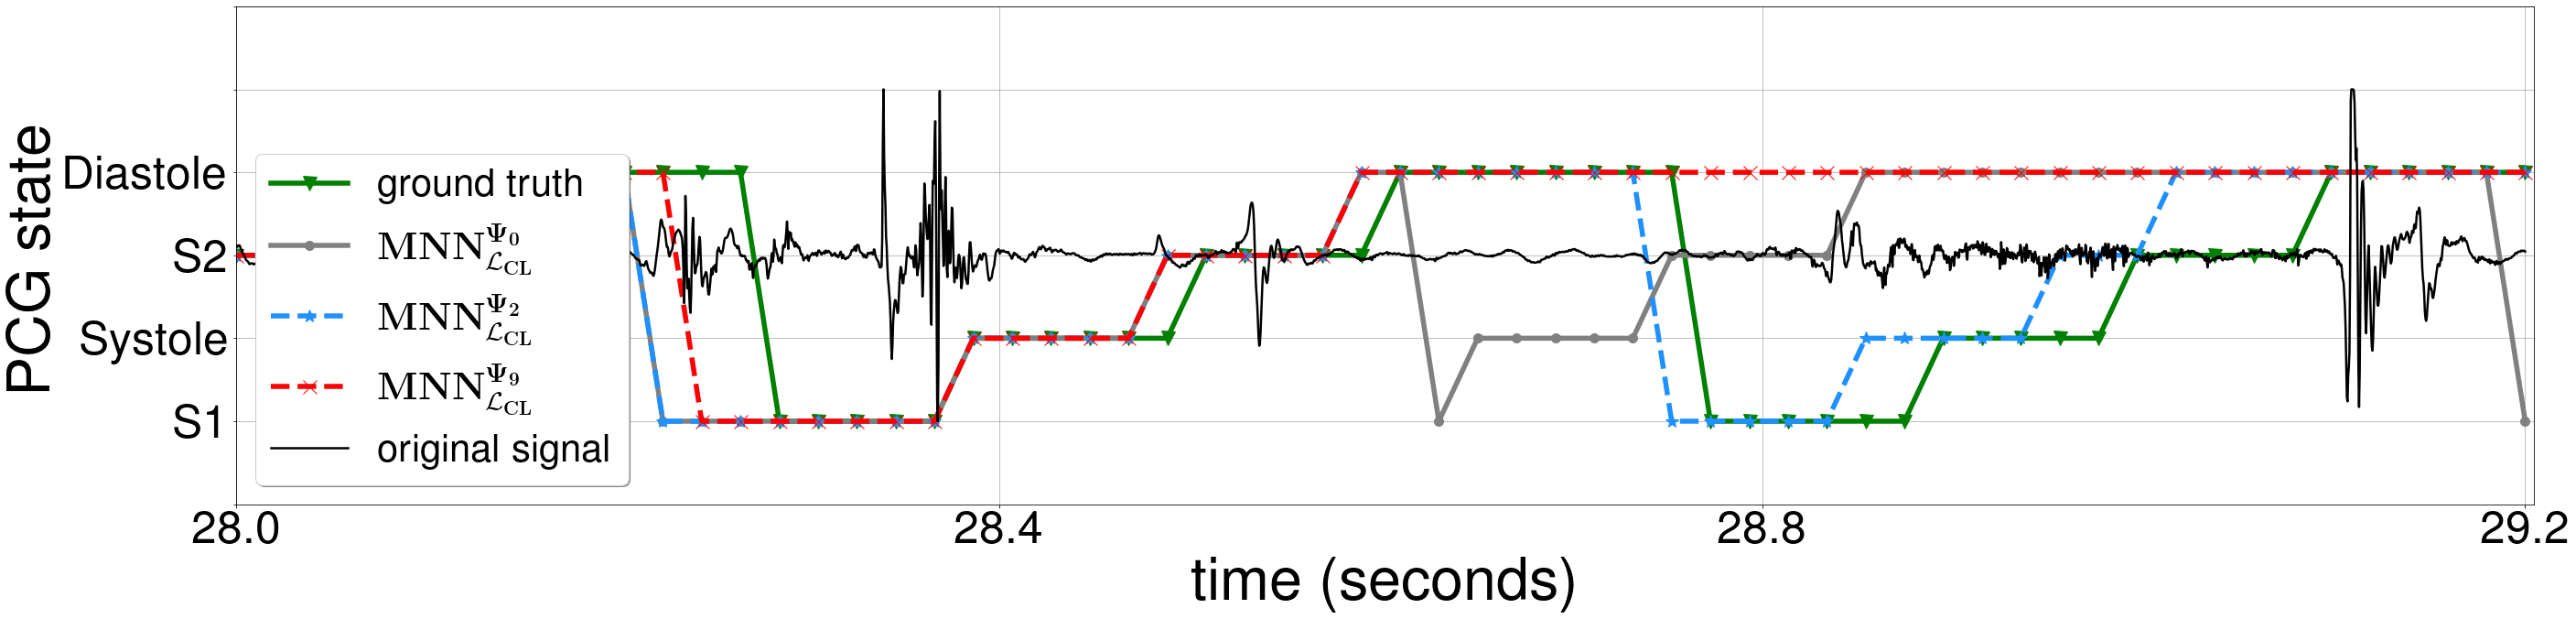

In [635]:
SMALL_SIZE = 20
MEDIUM_SIZE = 50
S = 20
a, b = 4, 0.
norm_2 = (a-b)/(np.max(sig) - np.min(sig))*(sig-np.max(sig))+a
def show_outputs(fold, obs, idx1, idx2, a=1400, b=1460):
    x1, x2 = [np.linspace(0, 60, num) for num in [60, 3583]]
    plt.rcParams["figure.figsize"] = (45,10)
    print(len(gt[fold, obs][a:b]), len(np.arange(0, 60, 1)), len(np.arange(28, 29.2, .2)))
    plt.plot(x1, gt[fold, obs][a:b], color='green', label='ground truth', marker='v', linewidth=5.5, markersize=15) # gt
    plt.plot(x1, preds[fold, obs, 0][a:b], color='gray', label='$\mathrm{\mathbf{MNN}}^{\mathbf{\Psi}_\mathbf{0}}_{\mathcal{L}_\mathrm{\mathbf{CL}}}$', marker='.', linewidth=5.5,  markersize=20)
    plt.plot(x1, preds[fold, obs, 2][a:b], color='dodgerblue', linestyle='dashed', label='$\mathrm{\mathbf{MNN}}^{\mathbf{\Psi}_\mathbf{2}}_{\mathcal{L}_\mathrm{\mathbf{CL}}}$', marker='*',  linewidth=5.5,  markersize=15)
    plt.plot(x1, preds[fold, obs, idx1][a:b], color='red', linestyle='dashed', label='$\mathrm{\mathbf{MNN}}^{\mathbf{\Psi}_\mathbf{9}}_{\mathcal{L}_\mathrm{\mathbf{CL}}}$', marker='x',  linewidth=5.5,  markersize=15)
    #plt.plot(features[test_indices[254]][:, 0][1400:1460], color='black', label='homomorphic envelogram')
    plt.plot(x2, norm_2[120000:128000], color='black', label='original signal', linewidth=2.5)

    plt.yticks([-1, 0, 1, 2, 3, 4, 5], ['','S1', 'Systole', 'S2', 'Diastole', '', ''])
    #plt.xticks(np.arange(0, 60, 1), np.arange(1400/50, 1460/50, 1/50))
    plt.xticks([0, 20, 40, 60], [28.0, 28.4, 28.8, 29.2])
    
    plt.xlabel('time (seconds)', **{'weight':'bold', 'size': 65})
    plt.ylabel('PCG state', **{'weight':'bold', 'size': 65})
    #plt.tick_params(
    #    axis='x',          # changes apply to the x-axis
    #    which='both',      # both major and minor ticks are affected
    #    bottom=False,      # ticks along the bottom edge are off
    #    top=False,         # ticks along the top edge are off
    #    labelbottom=False

    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE) 
    plt.rc('axes', labelsize=MEDIUM_SIZE)# fontsize of the tick labels
    plt.rc('legend', fontsize=42)
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.weight": "bold",
        })
    plt.rc('font', size=MEDIUM_SIZE) 
    plt.locator_params(axis='x', nbins=4)
    plt.xlim((0,60.23))
    plt.legend(shadow=True, loc='lower left', prop={'weight':'bold'})
    plt.grid(visible=True)
    #plt.savefig('fine_tune_comparison_less_dpi_fancy.png', dpi=400, bbox_inches='tight')
    #plt.plot(preds[fold, obs, idx2])
    
show_outputs(1, 254, 9, 13)

#0.8198198198198198 0.8867924528301887 0.9117647058823529 0.9285714285714286
#0.7459016393442623 0.8867924528301887 0.7622950819672131 0.7459016393442623

In [570]:
!open .

In [340]:
x1, x2

(array([ 0.        ,  1.01694915,  2.03389831,  3.05084746,  4.06779661,
         5.08474576,  6.10169492,  7.11864407,  8.13559322,  9.15254237,
        10.16949153, 11.18644068, 12.20338983, 13.22033898, 14.23728814,
        15.25423729, 16.27118644, 17.28813559, 18.30508475, 19.3220339 ,
        20.33898305, 21.3559322 , 22.37288136, 23.38983051, 24.40677966,
        25.42372881, 26.44067797, 27.45762712, 28.47457627, 29.49152542,
        30.50847458, 31.52542373, 32.54237288, 33.55932203, 34.57627119,
        35.59322034, 36.61016949, 37.62711864, 38.6440678 , 39.66101695,
        40.6779661 , 41.69491525, 42.71186441, 43.72881356, 44.74576271,
        45.76271186, 46.77966102, 47.79661017, 48.81355932, 49.83050847,
        50.84745763, 51.86440678, 52.88135593, 53.89830508, 54.91525424,
        55.93220339, 56.94915254, 57.96610169, 58.98305085, 60.        ]),
 array([0.00000000e+00, 7.50093762e-03, 1.50018752e-02, ...,
        5.99849981e+01, 5.99924991e+01, 6.00000000e+01]))

In [573]:
dataset 

array([[13918,
        array([-330, -190, -227, ..., -78, 130, 235], dtype=object),
        array([1, 1, 1, ..., 3, 3, 3], dtype=object)],
       [13918, array([528, 570, 723, ..., 340, 382, 471], dtype=object),
        array([1, 1, 1, ..., 1, 1, 1], dtype=object)],
       [13918,
        array([-31, -228, -329, ..., 1274, 889, 700], dtype=object),
        array([1, 1, 1, ..., 3, 3, 3], dtype=object)],
       ...,
       [9983, array([4, 80, 34, ..., -454, 1596, 2595], dtype=object),
        array([4, 4, 4, ..., 4, 4, 4], dtype=object)],
       [9983, array([33, 13, -3, ..., 212, 122, 49], dtype=object),
        array([2, 2, 2, ..., 1, 1, 1], dtype=object)],
       [9983,
        array([-907, -916, -339, ..., 1133, 923, 1164], dtype=object),
        array([4, 4, 4, ..., 4, 4, 4], dtype=object)]], dtype=object)

Filter+Resampling recordings: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


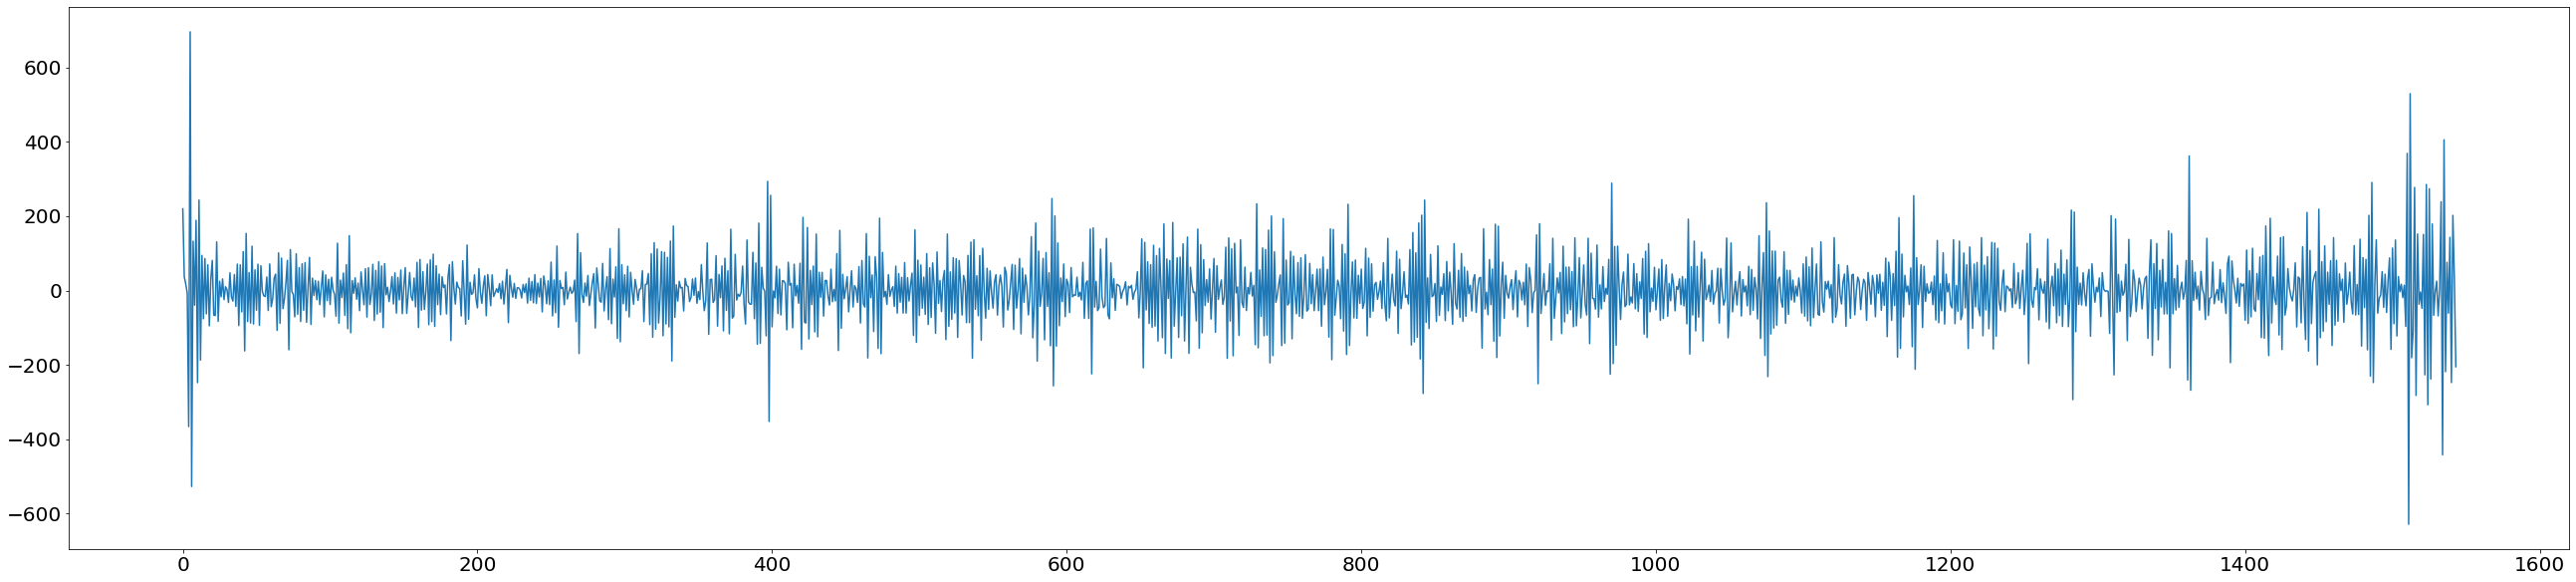

In [75]:
features[test_indices[254]].shape

(1545, 4)

In [86]:
.shape


(20960,)

In [ ]:
dataset[dataset[0] == ]

In [ ]:
def show_outputs(fold, obs, idx1, idx2, a=1400, b=1460):
    
    plt.rcParams["figure.figsize"] = (45,10)
    plt.plot(gt[fold, obs][a:b], color='green', label='ground truth') # gt
    plt.plot(preds[fold, obs, 0][a:b], color='pink')
    plt.plot(preds[fold, obs, 2][a:b], color='cyan', linestyle='dotted')
    plt.plot(preds[fold, obs, idx1][a:b], color='red', linestyle='dotted')
    
    #plt.plot(preds[fold, obs, idx2])
    
show_outputs(1, 254, 10, 13)

In [138]:
def check_results(fold, obs, idx, idx2):
    print(ppv[fold, obs, 0], ppv[fold, obs, idx], ppv[fold, obs, idx2])
    print(sens[fold, obs,0], sens[fold,obs, idx], sens[fold, obs, idx2])

#fold 0 7 epochs; 12; 18*; 25; 27*; 44* 

for i in range(ppv.shape[1]):
    print(i)
    print(check_results(0, i, 3, 6))
    
# 86 seems good for inspecy max_epochs 4 vs 7

#fold 0 7 epochs; 12; 18*; 25; 27*; 44* 

for i in range(ppv.shape[1]):
    print(i)
    print(check_results(1, i, 3, 6))
    
# 86 seems good for inspecy max_epochs 4 vs 7
# fold 1: 233; 239

0
0.8 0.8 0.75 0.6666666666666666
0.5 0.8 0.375 0.25
None
1
0.8958333333333334 0.8958333333333334 0.8958333333333334 0.9166666666666666
0.8269230769230769 0.8958333333333334 0.8269230769230769 0.8461538461538461
None
2
0.8888888888888888 0.8888888888888888 0.7894736842105263 0.9230769230769231
0.5925925925925926 0.8888888888888888 0.5555555555555556 0.4444444444444444
None
3
0.9 0.9 0.9 0.9
0.84375 0.9 0.84375 0.84375
None
4
0.5 0.5 0.5 0.5
0.2 0.5 0.2 0.2
None
5
0.2 0.2 0.2 0.2
0.07692307692307693 0.2 0.07692307692307693 0.07692307692307693
None
6
1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0
None
7
0.5714285714285714 0.5714285714285714 0.5714285714285714 0.5714285714285714
0.4 0.5714285714285714 0.4 0.4
None
8
0.875 0.875 0.875 0.875
0.875 0.875 0.875 0.875
None
9
1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0
None
10
0.6 0.6 0.7 0.7
0.5 0.6 0.5833333333333334 0.5833333333333334
None
11
0.95 0.95 0.95 1.0
0.95 0.95 0.95 1.0
None
12
0.7857142857142857 0.7857142857142857 0.7857142857142857 0.8571428571428571
0.785

1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0
None
197
0.8979591836734694 0.90625 0.925531914893617 0.9468085106382979
0.9263157894736842 0.90625 0.9157894736842105 0.9368421052631579
None
198
0.9418604651162791 0.9418604651162791 0.9418604651162791 0.9418604651162791
0.9204545454545454 0.9418604651162791 0.9204545454545454 0.9204545454545454
None
199
0.9791666666666666 0.9791666666666666 0.9791666666666666 0.9791666666666666
0.9591836734693877 0.9791666666666666 0.9591836734693877 0.9591836734693877
None
200
0.8936170212765957 0.8936170212765957 0.8936170212765957 0.8936170212765957
0.8842105263157894 0.8936170212765957 0.8842105263157894 0.8842105263157894
None
201
1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0
None
202
1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0
None
203
0.6842105263157895 0.6842105263157895 0.7058823529411765 0.71875
0.6842105263157895 0.6842105263157895 0.631578947368421 0.6052631578947368
None
204
1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0
None
205
0.89 0.8921568627450981 0.9019607843137255 0.9029126213592233
0.82

In [15]:
from data_processing.signal_extraction import DataExtractor, CircorExtractor
good_indices, features, labels, patient_ids = CircorExtractor.read_from_np(
        'datasets/PCG/circor_final/springer_circor_dataset.npy',
        patch_size=64)

[0.73536393 0.73349573 0.74406716 0.76293031 0.68205305 0.6220857
 0.67350037 0.67076428 0.73908645 0.68169172] [0.72708198 0.73513906 0.74247775 0.75580807 0.67736795 0.62046629
 0.66979033 0.6632627  0.73569818 0.67661853]


In [27]:
features_train = features[train_indices]
features_test = features[test_indices]

labels_train = labels[train_indices]
labels_test = labels[test_indices]

50138

{'whiskers': [<matplotlib.lines.Line2D at 0x7fdabe837220>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdabe8377c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdabe820f10>,
 'medians': [<matplotlib.lines.Line2D at 0x7fdabe837d60>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fdabe833070>,
 'means': []}

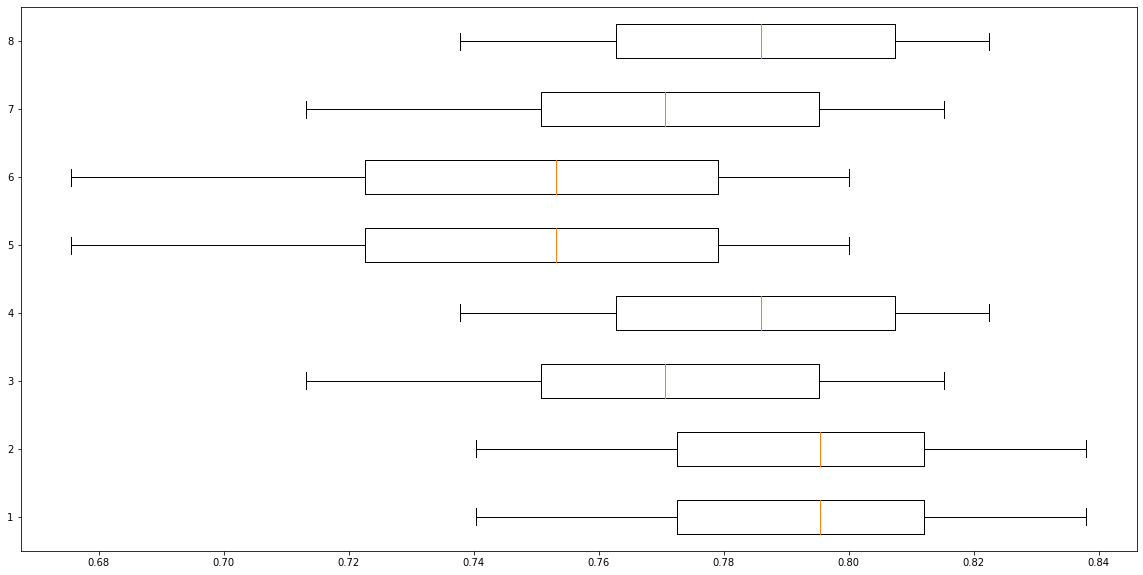

In [225]:
plt.boxplot([unet_ph16_circor[1], unet_ph16_circor[1], fold_ppv[:, 0], fold_ppv[:, 8],
                unet_ph16_circor[2], unet_ph16_circor[2], fold_sens[:, 0], fold_sens[:, 8]], vert=False)

Text(0.5, 1.0, 'PPV Physionet->Circor')

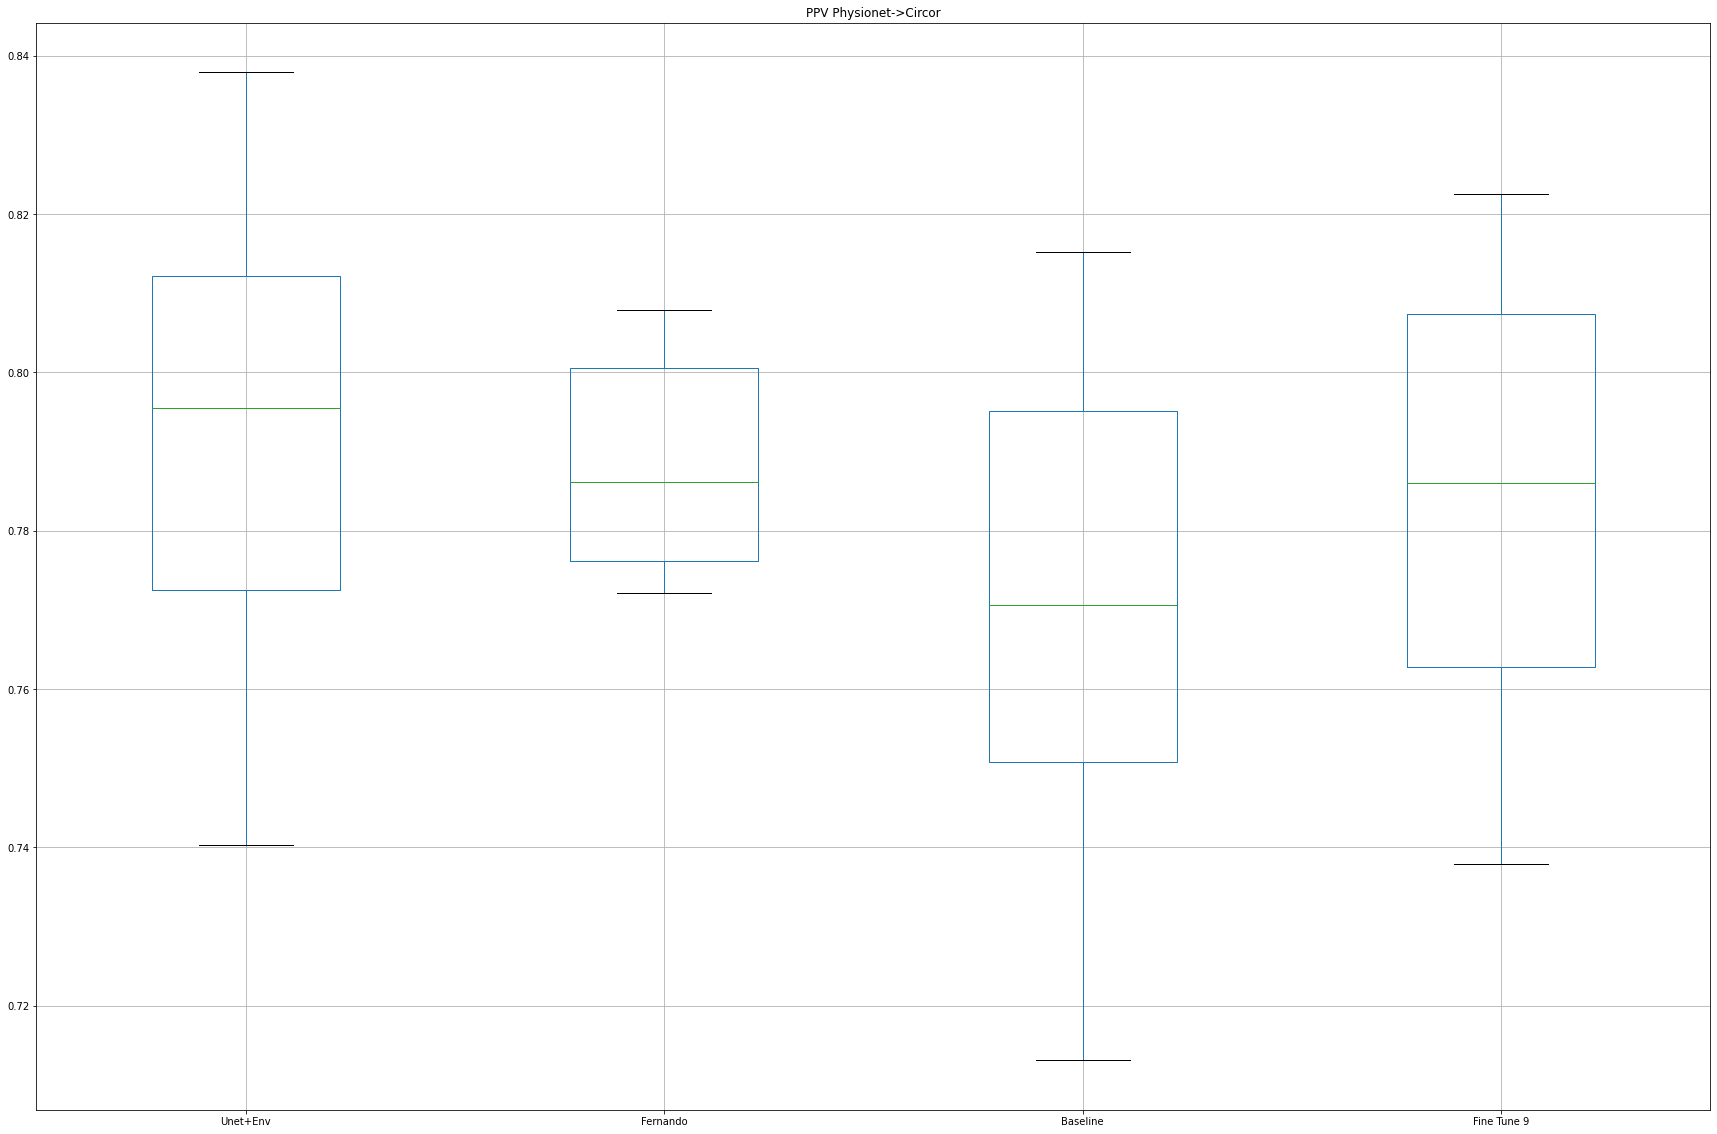

In [181]:
df = pd.DataFrame({'Unet+Env': unet_ph16_circor[1],
                   'Fernando': fernando_ph16_circor[1],
                   'Baseline': fold_ppv[:, 0],
                   'Fine Tune 9': fold_ppv[:, 8]
                   }) # no grads CL, no grads MMI,  CL envelogram, corrected fernando
boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('PPV Physionet->Circor')

Text(0.5, 1.0, 'PPV Physionet->Circor')

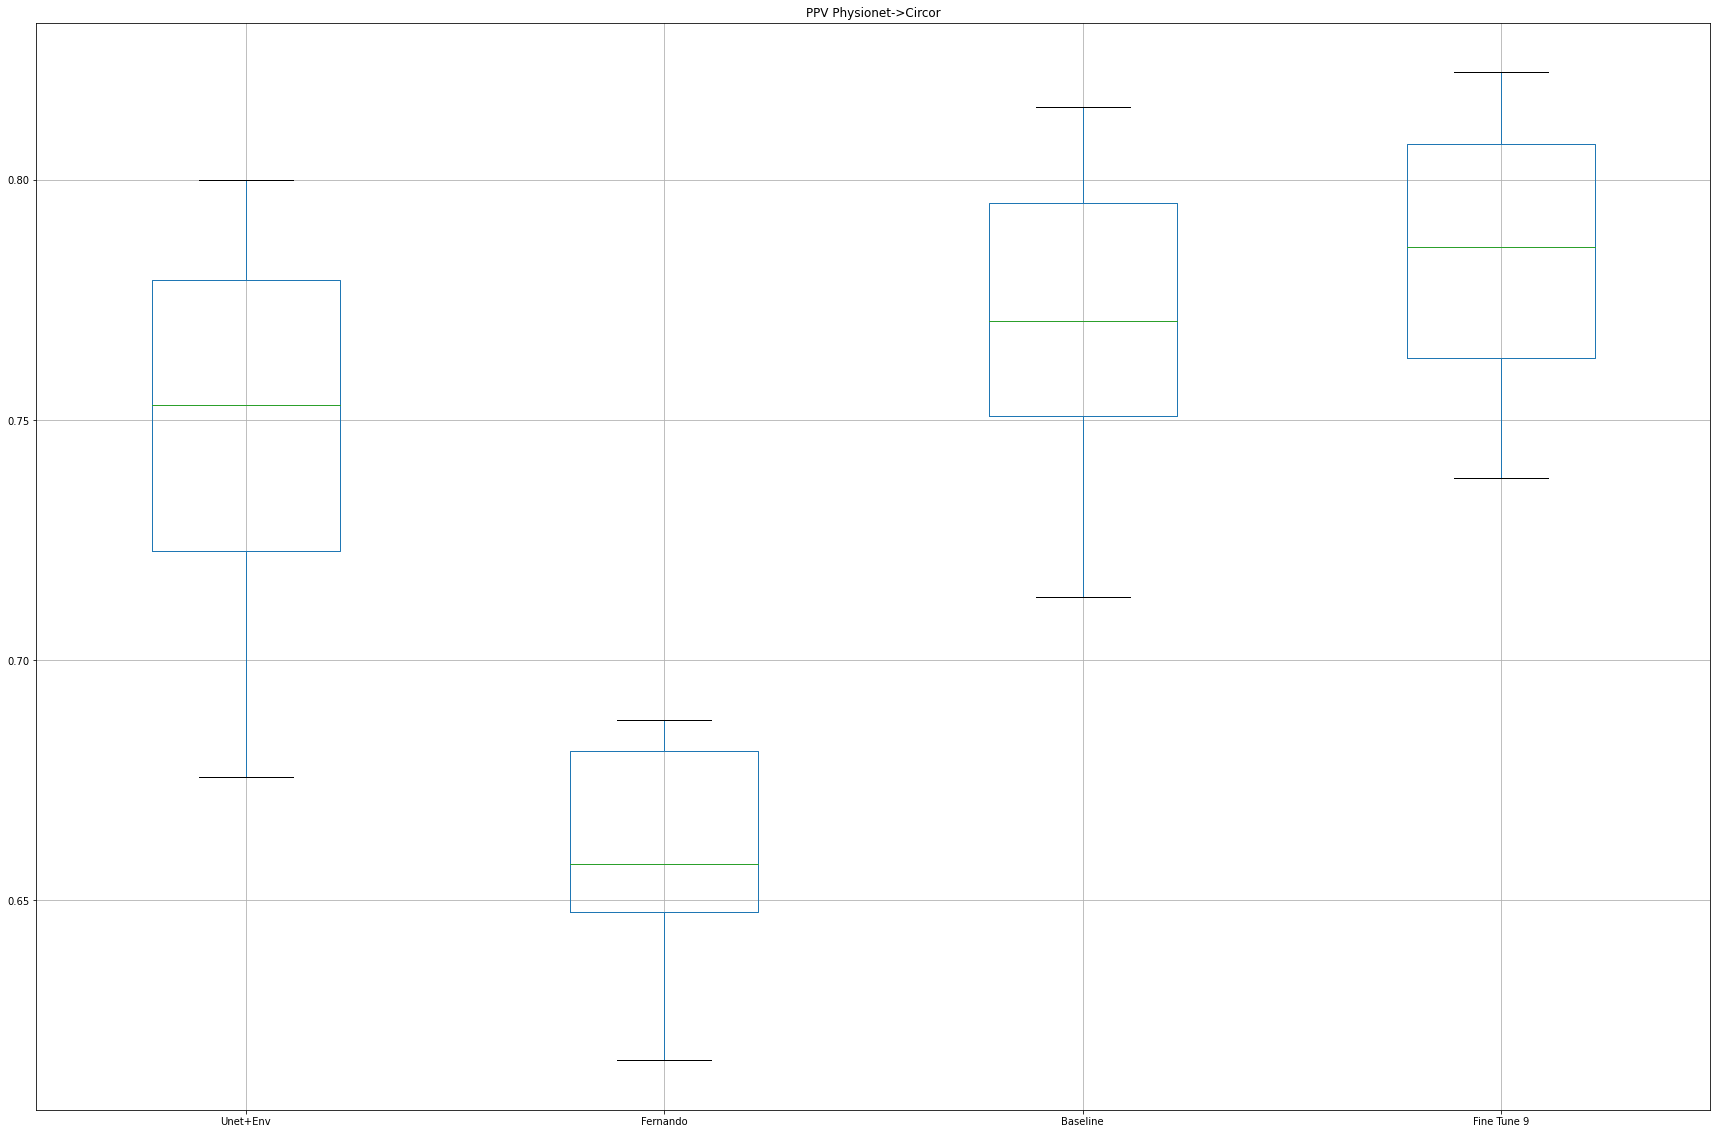

In [180]:
df = pd.DataFrame({'Unet+Env': unet_ph16_circor[2],
                   'Fernando': fernando_ph16_circor[2],
                   'Baseline': fold_sens[:, 0],
                   'Fine Tune 9': fold_sens[:, 8]
                   }) # no grads CL, no grads MMI,  CL envelogram, corrected fernando
boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('PPV Physionet->Circor')

Text(0.5, 1.0, 'PPV Physionet->Circor')

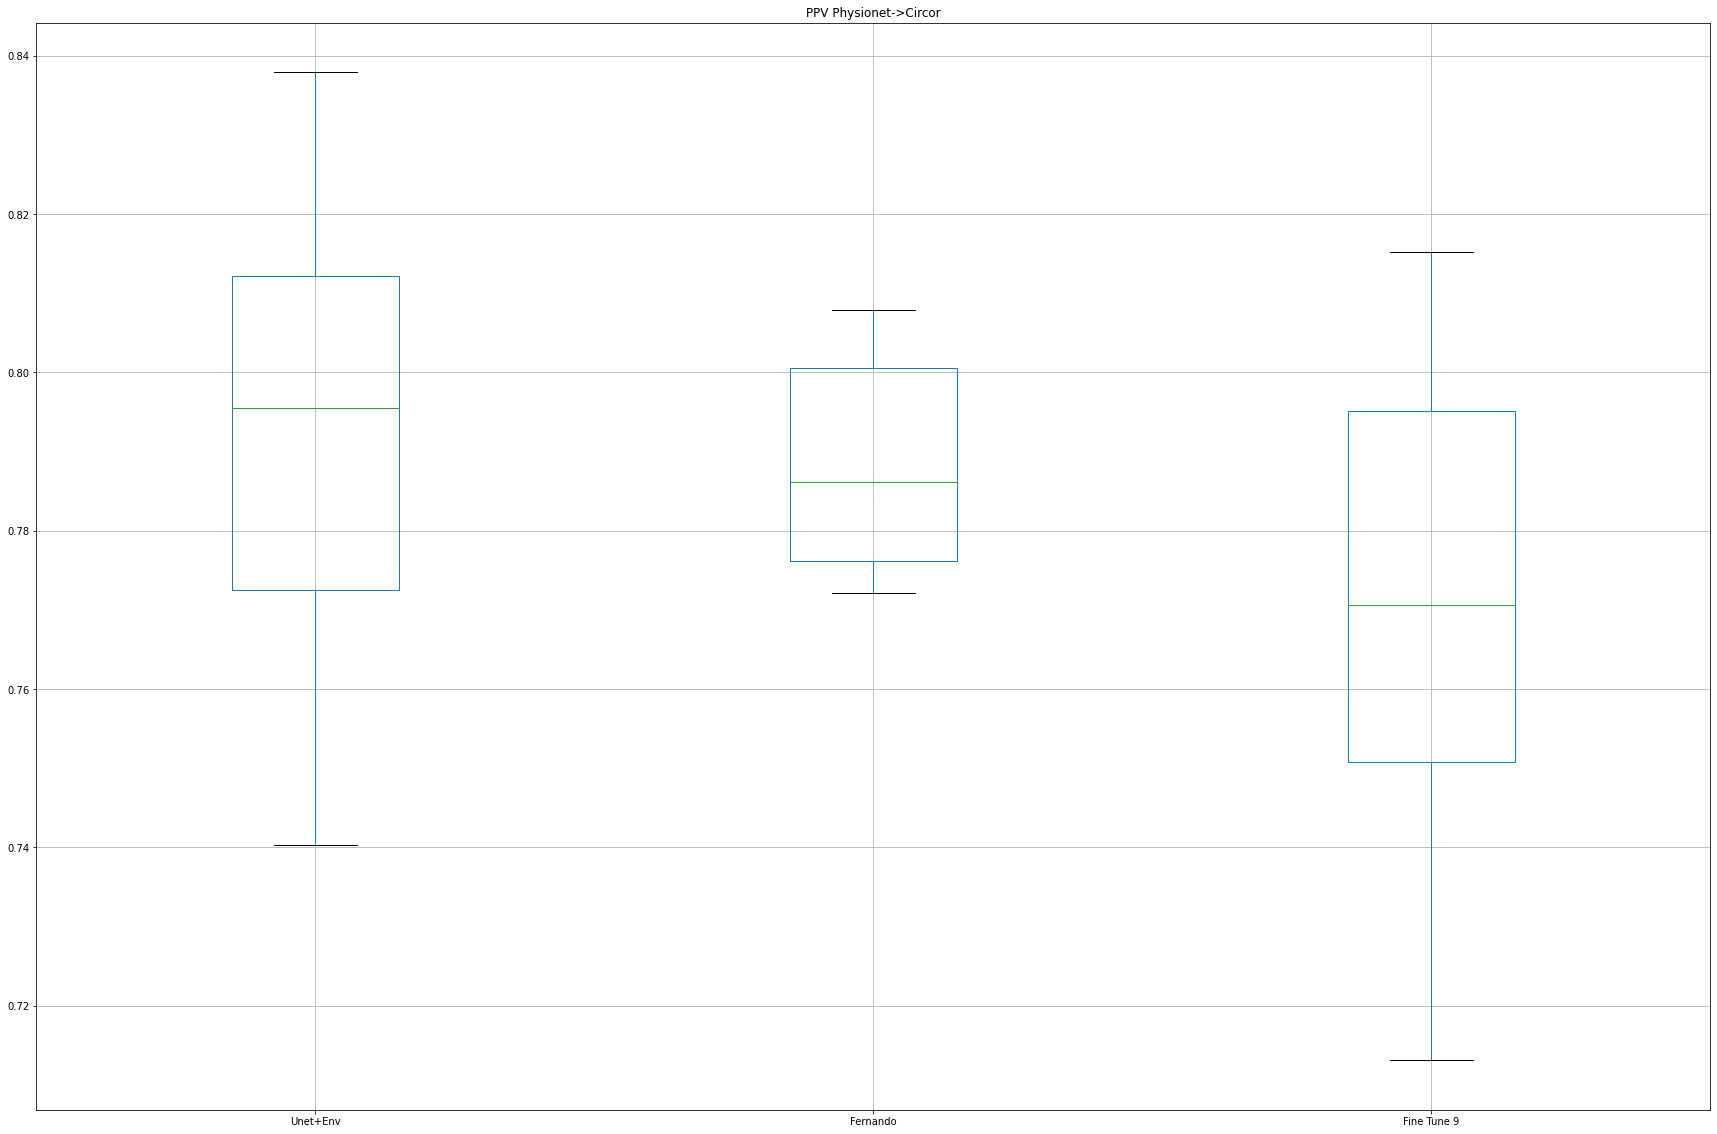

In [176]:
df = pd.DataFrame({'Unet+Env': unet_ph16_circor[1],
                   'Fernando': fernando_ph16_circor[1],
                   'Fine Tune 9': fold_ppv[:, 0]
                   }) # no grads CL, no grads MMI,  CL envelogram, corrected fernando
boxplot = df.boxplot(column=list(df.keys()), figsize=(30,20))
plt.title('PPV Physionet->Circor')

(10, 50)

In [ ]:
def paired_t_test_statistics(samples, alpha=0.05):
    n = len(samples)
    pairings = tuple(prod for prod in itertools.product(samples, samples))
    name_pairs = [(pair[0][0], pair[1][0]) for pair in pairings]
    paired_t_test = [stats.ttest_rel(pair[0][1], pair[1][1]) for pair in pairings]
    matrix = [1 if (p_v:= pair.pvalue) <= alpha else 0 for pair in paired_t_test]
    return name_pairs, paired_t_test, np.array(matrix).reshape((n,n))


def plot_t_test_matrix(mat, ticks, metric_name=''):
    mat_ = mat.copy().astype(np.float32)
    for i in range(mat.shape[0]):
        mat_[i, i] = 0.5
    fig, ax = plt.subplots()
    ax.matshow(mat_, cmap='gray', vmin=0, vmax=1, )
    
    ax.set_xticks(range(len(ticks)))
    ax.set_xticklabels(ticks, rotation='vertical')
    ax.set_yticks(range(len(ticks)))
    ax.set_yticklabels(ticks, rotation='horizontal')
    ax.set_title(r'Paired $t$-Test $n=10$')
    plt.savefig('filename.png', dpi=1200)

models_circor = {'MNN': circor_nn_only_env_cl,
                 'U-Net': circor_unet_cre_env,
                 'Fernando': circor_fernando,
                 }


ppv = tuple((x, tuple(y[1])) for x, y in models_circor.items())
sens = tuple((x, tuple(y[2])) for x, y in models_circor.items())

pairs_sens, t_stats_sens, mat_sens = paired_t_test_statistics(sens)
ticks = [ '$\mathrm{MNN}^\Theta_{\mathcal{L}_\mathrm{CL}}$', 'Renna $et$ $al.$', 'Fernando $et$ $al.$']
plot_t_test_matrix(mat_sens, ticks, '$\mathbf{S}$')


def plot_t_test_matrix(mat, ticks, metric_name=''):
    mat_ = mat.copy().astype(np.float32)
    for i in range(mat.shape[0]):
        mat_[i, i] = 0.5
    fig, ax = plt.subplots()
    ax.matshow(mat_, cmap='gray', vmin=0, vmax=1, )
    

In [82]:
ppv.shape# importing the modules
import matplotlib.pyplot as plt
import numpy as np
 
# specifying the plot size
plt.figure(figsize = (10, 5))
 
# only one line may be specified; full height

 
# rendering plot
plt.show()

(10, 327, 50)

(50,) (50,)


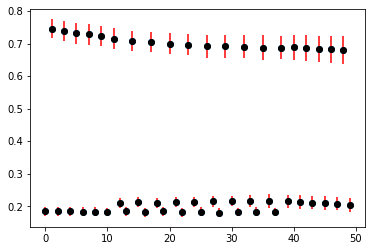

In [67]:

plot_fine_tune(ppv)


In [20]:
directory = 'results/rerun/circor/hmm_diagnositcs_finetune/2023-02-13_11_49_54/results.hdf5'
f = h5py.File(directory, 'r')

In [36]:
attributes_fold = f['fold0/data/'].attrs.keys()
gt_fold = [x for x in attributes_fold if x.startswith('gt')]
preds_fold = [x for x in attributes_fold if x.startswith('preds')]
loss_fold = [x for x in attributes_fold if x.startswith('loss_value')]
trans_fold = [x for x in attributes_fold if x.startswith('learned_trans')]
target_trans_fold = [x for x in attributes_fold if x.startswith('target_trans')]

gt_fold = sorted(gt_fold, key=lambda x: int(re.search('\d+',x).group()))
preds_fold = sorted(preds_fold, key=lambda x: 
                    (20 * int(re.findall('\d+', x)[0])) + int(re.findall('\d+', x)[-1]))
loss_fold = sorted(loss_fold, key=lambda x: 
                    (20 * int(re.findall('\d+', x)[0])) + int(re.findall('\d+', x)[-1]))
trans_fold = sorted(trans_fold, key=lambda x: 
                    (20 * int(re.findall('\d+', x)[0])) + int(re.findall('\d+', x)[-1]))
target_trans_fold = sorted(target_trans_fold, key=lambda x: 
                    (20 * int(re.findall('\d+', x)[0])) + int(re.findall('\d+', x)[-1]))

In [182]:
from tqdm import tqdm
def distance(x, y):
    dist = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        dist[i] = np.dot(x[i, :] - y[i, :] , x[i, :] - y[i, :])
    return dist

def get_attribute_names_diagnostics(fold_ptr, fold):
    attributes_fold = f['fold0/data/'].attrs.keys()
    gt_fold = [x for x in attributes_fold if x.startswith('gt')]
    preds_fold = [x for x in attributes_fold if x.startswith('preds')]
    loss_fold = [x for x in attributes_fold if x.startswith('loss_value')]
    trans_fold = [x for x in attributes_fold if x.startswith('learned_trans')]
    target_trans_fold = [x for x in attributes_fold if x.startswith('target_trans')]

    gt_fold = sorted(gt_fold, key=lambda x: int(re.search('\d+',x).group()))
    preds_fold = sorted(preds_fold, key=lambda x: 
                        (20 * int(re.findall('\d+', x)[0])) + int(re.findall('\d+', x)[-1]))
    loss_fold = sorted(loss_fold, key=lambda x: 
                        (20 * int(re.findall('\d+', x)[0])) + int(re.findall('\d+', x)[-1]))
    trans_fold = sorted(trans_fold, key=lambda x: 
                        (20 * int(re.findall('\d+', x)[0])) + int(re.findall('\d+', x)[-1]))
    target_trans_fold = sorted(target_trans_fold, key=lambda x: 
                        (20 * int(re.findall('\d+', x)[0])) + int(re.findall('\d+', x)[-1]))
    return gt_fold, preds_fold, loss_fold, trans_fold, target_trans_fold


def process_hdf5_diagnostics(filename, number_folds=10, nreps=20):
    f = h5py.File(filename, 'r')
    fold_ppv, fold_sens = [], []
    fold_losses, fold_distances = [], []
    for fold in tqdm(range(number_folds)):
        fold_data = f[f'fold{fold}/data/']
        gts, preds, loss, trans, target_trans_mat = get_attribute_names_diagnostics(fold_data, fold)
        obs_ppv, obs_sens = [], []
        obs_losses, obs_distances = [], []
        for idx, gt_name in enumerate(gts):
            start = idx * nreps
            ft_ppv, ft_sens = [], []
            losses, distances = [], []
            gt = fold_data.attrs[gt_name]
            for i in range(nreps):
                pred = fold_data.attrs[preds[start + i]]
                trans_mat = fold_data.attrs[trans[start+i]]
                target_trans = fold_data.attrs[target_trans_mat[start+i]]
                distances.append(distance(trans_mat, target_trans))
                losses.append(fold_data.attrs[loss[start+i]])
                ppv_, sensitivity_ = schmidt_metrics(gt, pred)
                ft_ppv.append(ppv_)
                ft_sens.append(sensitivity_)
            obs_ppv.append(ft_ppv)
            obs_sens.append(ft_sens)
            obs_losses.append(losses)
            obs_distances.append(distances)
        fold_ppv.append(obs_ppv)
        fold_sens.append(obs_sens)
        fold_losses.append(obs_losses)
        fold_distances.append(obs_distances)
    return fold_ppv, fold_sens, fold_losses, fold_distances

In [183]:
directory = 'results/rerun/circor/hmm_diagnositcs_finetune/2023-02-13_11_49_54/results.hdf5'
ppv, sens, loss, dist = process_hdf5_diagnostics(directory, number_folds=10, nreps=20)

100%|██████████| 10/10 [03:03<00:00, 18.36s/it]


In [184]:
loss = np.array(loss)
avg_dec = np.mean((loss[:, :, 0] - loss[:, :, -1]), axis=1)
std_dec = np.std((loss[:, :, 0] - loss[:, :, -1]), axis=1)

avg_loss = np.mean(np.mean(loss, axis=1), axis=1)
std_loss = np.std(np.mean(loss, axis=1), axis=1)

In [215]:
dist = np.array(dist)

avg_diff = np.mean((dist[:, :, 0] - dist[:, :, -1]), axis=1)
std_diff = np.std((dist[:, :, 0] - dist[:, :, -1]), axis=1)


np.mean(np.mean(dist, axis=1), axis=1)

array([[0.00534558, 0.00728602, 0.0059159 , 0.00662656],
       [0.00754266, 0.00605372, 0.00482822, 0.00591694],
       [0.00693214, 0.00520024, 0.00556307, 0.00510615],
       [0.00479317, 0.0070538 , 0.00541966, 0.00545614],
       [0.00498171, 0.008252  , 0.00460235, 0.00772364],
       [0.00558454, 0.00908815, 0.00573859, 0.00931135],
       [0.00328041, 0.00914105, 0.00342464, 0.00865069],
       [0.00433745, 0.0079783 , 0.00454537, 0.00846151],
       [0.00419757, 0.00741844, 0.00527691, 0.00567571],
       [0.00394068, 0.00966818, 0.00533921, 0.00801529]])

In [188]:
print("Fine-tune diagnostics (log-space) 20 epochs")
for i in range(10):
    print("Fold ", i+1, " Expected:")
    print(f'\tLoss per sample: {avg_loss[i]} +- {std_loss[i]}')
    print(f'\tDecrease in loss: {avg_dec[i]} +- {std_dec[i]}')

Fine-tune diagnostics (log-space) 20 epochs
Fold  1  Expected:
	Loss per sample: 373.17913818359375 +- 0.1458415389060974
	Decrease in loss: 0.4643526077270508 +- 1.0839070081710815
Fold  2  Expected:
	Loss per sample: 337.514892578125 +- 0.10671384632587433
	Decrease in loss: 0.3409726619720459 +- 0.7456974983215332
Fold  3  Expected:
	Loss per sample: 396.4305114746094 +- 0.11562405526638031
	Decrease in loss: 0.36575478315353394 +- 0.8015916347503662
Fold  4  Expected:
	Loss per sample: 434.6669921875 +- 0.14429432153701782
	Decrease in loss: 0.4566197395324707 +- 0.9049652814865112
Fold  5  Expected:
	Loss per sample: 288.4075622558594 +- 0.10215974599123001
	Decrease in loss: 0.323182076215744 +- 0.8895230889320374
Fold  6  Expected:
	Loss per sample: 275.7066955566406 +- 0.10722390562295914
	Decrease in loss: 0.34072190523147583 +- 0.7523998618125916
Fold  7  Expected:
	Loss per sample: 277.94488525390625 +- 0.06858997046947479
	Decrease in loss: 0.21434342861175537 +- 0.34434056

In [62]:
np.array(loss).shape

(10, 327, 20)

In [39]:
directory = 'results/rerun/circor/hmm_range_1_100_finetune_pretained_ph16_circor20/2022-10-10_14_42_02/results.hdf5'
ppv, sens = process_hdf5(directory, number_folds=10, nreps=20)

In [ ]:
!ls 'results/rerun/circor/hmm_range_1_100_finetune_pretained_ph16_circor20/2022-10-10_14_42_02/results.hdf5'

In [40]:
ppv, sens = np.array(ppv), np.array(sens)

In [ ]:
process_hdf5(directory, number_folds=10, nreps=50)

In [43]:
ppv.shape

(10, 327, 20)

In [ ]:
327 * 50

In [41]:
def plot_fine_tune(results, num_epochs=50):
    y = np.mean(np.mean(results, axis=1), axis=0)
    y_error = np.std(np.mean(results, axis=1), axis=0)
    x = [i for i in range(num_epochs)]
    plt.scatter(x, y)
    plt.errorbar(x, y, yerr = y_error,fmt='o',ecolor = 'red',color='black')
    plt.show()

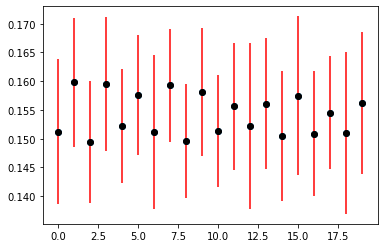

In [47]:
plot_fine_tune(ppv, num_epochs=20)

In [ ]:
plot_fine_tune(sens)

In [ ]:
np.mean(np.mean(sens, axis=1), axis=0)

In [189]:
!ls

README.md                       notebook
checkpoint                      notebooks
circor_100_nogaps_50hz.npy      ph16_ppv.png
circor_100_raw_50hz.npy         ph16_sens.png
circor_ppv.png                  random_init.data-00000-of-00001
circor_sens.png                 random_init.index
circor_springer_np.npy          requirements.txt.py
custom_train_functions          results
data_processing                 test.txt
datasets                        tests
filename.png                    train_scripts
loss_functions                  utility_functions
models


In [199]:
test = np.array([np.roll([0.4, 0.6, 0, 0], shift=i) for i in range(5)])
test2 = np.array([np.roll([0.1, 0.9, 0, 0], shift=i) for i in range(5)])
test3 = np.array([np.roll([0.6, 0.4, 0, 0], shift=i) for i in range(5)])
test, test2, test3

(array([[0.4, 0.6, 0. , 0. ],
        [0. , 0.4, 0.6, 0. ],
        [0. , 0. , 0.4, 0.6],
        [0.6, 0. , 0. , 0.4],
        [0.4, 0.6, 0. , 0. ]]),
 array([[0.1, 0.9, 0. , 0. ],
        [0. , 0.1, 0.9, 0. ],
        [0. , 0. , 0.1, 0.9],
        [0.9, 0. , 0. , 0.1],
        [0.1, 0.9, 0. , 0. ]]),
 array([[0.6, 0.4, 0. , 0. ],
        [0. , 0.6, 0.4, 0. ],
        [0. , 0. , 0.6, 0.4],
        [0.4, 0. , 0. , 0.6],
        [0.6, 0.4, 0. , 0. ]]))

In [197]:
test, test2, test3


f = lambda A, B: np.dot(x, y) for x, y in zip(A, B)

SyntaxError: invalid syntax (<ipython-input-197-2684f3b52e8c>, line 4)

In [223]:
normalize = lambda v: v/np.linalg.norm(v)

np.arccos(np.clip(), -1., 1.))

1.4901161193847656e-08

In [227]:
np.clip(np.arccos(np.dot(normalize(test[0, :]), normalize(test[0, :]))), -1, 1)

1.4901161193847656e-08